Importing required modules

In [1]:
import math
import copy
import os
import random
from collections import deque as queue
import numpy as np
from matplotlib import colors
from matplotlib import pyplot as plt
import time
import heapq
import multiprocessing
from multiprocessing import Process, Value, Array

**Values for visualisation [colors given in term of heat states on how sure we are that the node is in that location**

In [2]:
WALL = -1
OPEN = 0
COLD = 0.00000000001
ICE = 0.005
WATER = 0.009
STEAM = 0.01
FIRE = 0.02
BLAZE = 0.1
LAVA = 0.2
SUN = 1
DRONE = 1.2
bounds = [WALL, OPEN, COLD, ICE, WATER, STEAM, FIRE, BLAZE, LAVA, SUN, DRONE]
cmap = colors.ListedColormap([
    'black',  # wall
    'white',  # open
    'cyan',  # cold
    'aqua',  # ice
    'blue',  # water
    'yellow',  # steam
    'orange',  # fire
    'brown',  # blaze
    'red',  # lava
    'maroon',  # sun
    'maroon',  # drone found
])
norm = colors.BoundaryNorm(bounds, cmap.N)

**Pre-computational functions**

Here we use BFS to find distance between the most distant points, so instead of caluculating it again and again , i precompute it for the whole maze beforehand

In [3]:
#function to get shortest path from BFS
def getPath(goal, start, parent):

  result = [goal]
  while goal != start:
    goal = parent[goal]    
    result.append(goal)

  result.reverse()
  return result
  
def BFS(maze, start, goal):

  fringe = [start]
  visited = set()
  parent = {}
  visited.add(start)
  
  while(fringe):
    current = fringe.pop(0) #Queue so pop(0) implementing FIFO
    # visited.add(current) 
    if current == goal:
    #print(len(visited))
      return getPath(goal, start, parent)
    # print (parent,"current")
    children = maze.getChildren(current)
    # print(children)
    for child in children:
      if child not in visited:
        visited.add(child)
        fringe.append(child)
        parent[child] = current

  return None

**This is the BFS distance funtion that Caluculates Distance from every node to all nodes avoiding walls**

In [4]:
def bfs_distance_to_all_locations(maze):
  BFS_distance={}
  for i in range(maze.dim1):
    for j in range(maze.dim2):
      for i2 in range(maze.dim1):
        for j2 in range(maze.dim2):
          l=BFS(maze,(i,j),(i2,j2))
          if(l!=None):
            BFS_distance[(i,j),(i2,j2)]=len(l)-1
  return BFS_distance



**Maze Class**

Consists of movement restriction,heuristic caluclation on the maze, maze generation

In [43]:
class Maze:
  OPEN = 0
  WALL = -1

  def __init__(self, dim1=3,dim2=9):
    self.dim1 = dim1
    self.dim2 = dim2
    self.grid = [[0]*dim1]*dim2
    self.moves = ["UP","DOWN","RIGHT","LEFT"]

  #checks if node is blocked or unblocked
  def isUnblocked(self, node):
    row, col = node[0], node[1]
    return self.grid[row][col] >= self.OPEN
  #checks if node is in maze
  def isInMaze(self, node):
    return 0<= node[0] < self.dim1 and 0<= node[1] < self.dim2
  #A validation which checks if a node is unblocked and is in maze
  def isValid(self, node):
    return self.isInMaze(node) and self.isUnblocked(node)
  #getter
  def get(self, node):
    row, col = node[0], node[1]
    return self.grid[row][col]
  #setter
  def set(self, node, val):
    self.grid[node[0]][node[1]] = val

  def getChildren(self, current): # o/p will be a list of tuples giving us a list of possible moves
      children = []

      # down
      down = (current[0] + 1, current[1])
      if self.isValid(down):
        children.append(down)

      # right
      right = (current[0], current[1]+1)
      if self.isValid(right):
        children.append(right)
      
      # up direction
      up = (current[0] - 1, current[1])
      if self.isValid(up):
        children.append(up)

      # left 
      left = (current[0], current[1]-1)
      if self.isValid(left):
        children.append(left)

      return children

  def visualize(self): #function to print the grid

    copy_grid = np.array(self.grid).tolist()

    prev = {}
    for row in copy_grid:
      print(row)

  def visualize_grid(self):# a beautiful function which visualises the whole grid in the form of maze
    
    copy_grid = np.array(self.grid).tolist()
    prev = {}
    l = np.pad(copy_grid, [(1, 1), (1, 1)], mode='constant',constant_values=(-1))
    plt.figure(figsize=(10, 10))
    plt.pcolor(l[::-1], cmap=cmap, norm=norm, edgecolors='k', linewidths=0.1)
    plt.tick_params(axis='both', which='both', bottom=False,
                    left=False, labelbottom=False, labelleft=False)
    plt.axis('equal')
    plt.show()
    
  def Distance_between_ends(self, grid):#find distance between two most farthest points in the graph
    Dist_between_ends = 0
    m = len(grid[0])
    n = len(grid)
    for x1 in range(n):
        for y1 in range(m):
            d = 0
            if grid[x1][y1] > 0:
                for x2 in range(n):
                    for y2 in range(m):
                        if grid[x2][y2] > 0:
                            d = max(d, BFS_distance[((x1, y1), (x2, y2))])
            Dist_between_ends = max(Dist_between_ends, d)
    return Dist_between_ends

#if the value of the node(probability) is greater than 0 then it add the value to the count
  def NonZero(self, grid):
    cn = 0
    for i in grid:
        for j in i:
            if j > 0:
                cn += 1
    return cn

  def check_grid(self, grid):
      m = len(grid)
      n = len(grid[0])
      k = False
      for i in range(m):
          for j in range(n):
              if k and grid[i][j] > 0:
                  return False
              elif grid[i][j] > 0:
                  k = True
      return True

#code to generate grid from inputs of X and _ values and fill with 1/Opencell values
def take_input_and_generate_grid(input):
    grid = []
    Cells = 0
    with open(input, "r") as f:
        reader = f.readlines()
        for r in reader:
            row = []
            for c in r:
                if c == "_":
                    row.append(0)
                    Cells += 1
                elif c == "X":
                    row.append(-1)
            grid.append(row)
    for i in range(len(grid)):
        for j in range(len(grid[i])):
            if grid[i][j] != -1:
                grid[i][j] = 1 / Cells
    return grid

#Moving Probabilities in a direction
def move_one_step_in_a_direction(grid,dir):
    global xend, xstart, xdiff, ystart, yend, ydiff, iadd, jadd
    row=len(grid)
    col=len(grid[0])
    if(dir=="UP"):
      xstart,xend,xdiff=0,row-1,1
      ystart,yend,ydiff=0,col,1
      iadd,jadd=1,0
      if row <= 1:
          return copy.deepcopy(grid)
    elif(dir=="DOWN"):
      xstart,xend,xdiff=row-1,0,-1
      ystart,yend,ydiff=0,col,1
      iadd,jadd=-1,0
      if row <= 1:
          return copy.deepcopy(grid)
    elif(dir=="LEFT"):
      xstart,xend,xdiff=0,row,1
      ystart,yend,ydiff=0,col-1,1
      iadd,jadd=0,1
      if col <= 1:
          return copy.deepcopy(grid)
    elif(dir=="RIGHT"):
      xstart,xend,xdiff=0,row,1
      ystart,yend,ydiff=col-1,0,-1
      iadd,jadd=0,-1
      if col <= 1:
          return copy.deepcopy(grid)
    tempGrid = copy.deepcopy(grid)
    for i in range(xstart,xend,xdiff):
        for j in range(ystart,yend,ydiff):
            if tempGrid[i][j] != -1:
                if tempGrid[i+iadd][j+jadd] != -1:
                    tempGrid[i][j] += tempGrid[i+iadd][j+jadd]
                    tempGrid[i+iadd][j+jadd] = 0

    return tempGrid
#maze initialzing function
def generate_maze(dim1=3,dim2=9):
  maze = Maze(dim1=dim1, dim2=dim2)
  return maze

In [59]:
def greedy_heuristic_converge(maze):#Approach 2 with 215 best value and sometime infinite loop
  steps=[]
  bettermove="test"
  moves=["LEFT","RIGHT","UP","DOWN"]
  count=0
  while(1):
    prevgrid=copy.deepcopy(maze.grid)
    if(bettermove=="LEFT"):
      moves=["LEFT","UP","DOWN"]
    elif(bettermove=="RIGHT"):
      moves=["RIGHT","UP","DOWN"]
    elif(bettermove=="DOWN"):
      moves=["RIGHT","LEFT","DOWN"]
    elif(bettermove=="UP"):
      moves=["RIGHT","LEFT","UP"]
    good_heuristic=math.inf
    for i in range(len(moves)):
      grid = copy.deepcopy(maze.grid)
      grid=copy.deepcopy(move_one_step_in_a_direction(grid,moves[i]))
      # maze.visualize_grid()
      reward=maze.Distance_between_ends(grid)*maze.NonZero(grid)
      # print(moves[i],reward)
      if(reward<good_heuristic):
        good_heuristic=reward
        bettermove=moves[i]
    grid1 = copy.deepcopy(maze.grid)
    # print(bettermove)
    grid1=copy.deepcopy(move_one_step_in_a_direction(grid1,bettermove))
    steps.append(bettermove)
    maze.grid=copy.deepcopy(grid1)
    if(prevgrid==maze.grid):
        grid1 = copy.deepcopy(maze.grid)
        rand_moves=["LEFT","RIGHT","UP","DOWN"]
        if(bettermove=="LEFT"):
          rand_moves=["LEFT","UP","DOWN"]
        elif(bettermove=="RIGHT"):
          rand_moves=["RIGHT","UP","DOWN"]
        elif(bettermove=="DOWN"):
          rand_moves=["RIGHT","LEFT","DOWN"]
        elif(bettermove=="UP"):
          rand_moves=["RIGHT","LEFT","UP"]
        rand_moves.remove(bettermove)
        r=random.choices(rand_moves,k=1)[0]
        grid1=copy.deepcopy(move_one_step_in_a_direction(grid1,r))
        bettermove=r
        maze.grid=copy.deepcopy(grid1)
    maze.visualize_grid()
    count+=1
    print(count)
    if(count>360):
        print("Not Efficient")
        return steps
    if(maze.grid.count(1)==1):
      return steps

In [46]:
def heuristic_converge(maze):#Final Approach with best value 135
    heap = []
    grid = copy.deepcopy(maze.grid)
    h = maze.Distance_between_ends(grid)*4+len([])+maze.NonZero(grid)*3
    heap.append((h, [], grid))
    visited = set()
    l = []
    for i in grid:
        l.append(tuple(i))
    visited.add(hash(hash(tuple(l))))
    while heap:
        pop = heapq.heappop(heap)
        if maze.check_grid(pop[2]):
            return pop[1]
        moves,grid = pop[1],pop[2]
        for move in maze.moves:
            #to Stop wiggling
            if (moves and moves[-1] == "LEFT" and move == "RIGHT") or (moves and moves[-1] == "UP" and move == "DOWN") or (moves and moves[-1] == "RIGHT" and move == "LEFT") or (moves and moves[-1] == "DOWN" and move == "UP"):
                continue
            newGrid = copy.deepcopy(move_one_step_in_a_direction(grid,move))

            h_new = maze.Distance_between_ends(newGrid)*4+len(moves + [move])+3*maze.NonZero(newGrid)
            l = []
            for i in newGrid:
                l.append(tuple(i))
            if hash(hash(tuple(l))) not in visited:
                visited.add(hash(hash(tuple(l))))
                heapq.heappush(heap, (h_new, moves[:] + [move], newGrid))

    return []

In [48]:
#Generating maze1 and Pre-computing BFS from all points to one another
g=take_input_and_generate_grid("input1.txt")
dim1=len(g)
dim2=len(g[0])
maze1 = generate_maze(dim1,dim2)
maze1.grid=g
# maze1.visualize_grid()
BFS_distance=bfs_distance_to_all_locations(maze1)

**Q2) Perform a move "DOWN" and show states of the Grid**

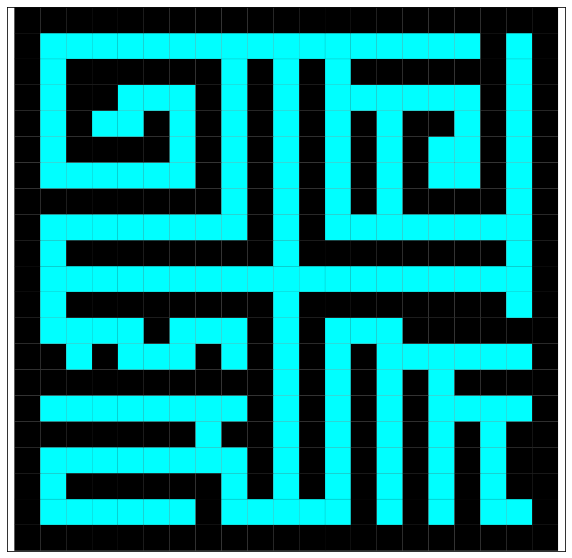

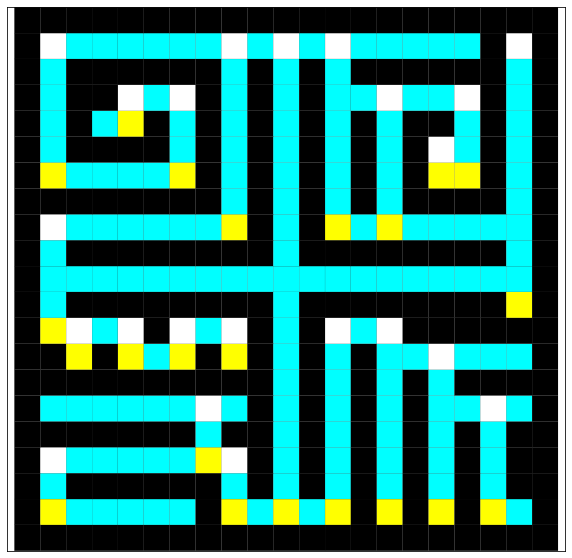

In [49]:
grid_output=take_input_and_generate_grid("input1.txt")
dim_output1=len(grid_output)
dim_output2=len(grid_output[0])
grid1 = copy.deepcopy(grid_output)
maze2 = generate_maze(dim_output1,dim_output2)
maze2.grid=grid1
maze2.visualize_grid()
# for i in steps:
newGrid = copy.deepcopy(move_one_step_in_a_direction(grid_output,"DOWN"))
grid_output = copy.deepcopy(newGrid)
maze2 = generate_maze(dim_output1,dim_output2)
maze2.grid=newGrid
maze2.visualize_grid()

**Q3) Finding the shortest sequence of steps**

['LEFT', 'LEFT', 'UP', 'UP', 'UP', 'UP', 'UP', 'LEFT', 'LEFT', 'LEFT', 'UP', 'UP', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'UP', 'RIGHT', 'RIGHT', 'UP', 'UP', 'RIGHT', 'RIGHT', 'RIGHT', 'RIGHT', 'RIGHT', 'RIGHT', 'RIGHT', 'UP', 'UP', 'UP', 'UP', 'UP', 'UP', 'UP', 'UP', 'UP', 'LEFT', 'DOWN', 'DOWN', 'LEFT', 'DOWN', 'DOWN', 'DOWN', 'DOWN', 'RIGHT', 'DOWN', 'RIGHT', 'DOWN', 'DOWN', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'DOWN', 'RIGHT', 'UP', 'RIGHT', 'RIGHT', 'DOWN', 'DOWN', 'DOWN', 'LEFT', 'LEFT', 'UP', 'LEFT', 'LEFT', 'LEFT', 'UP', 'RIGHT', 'UP', 'UP', 'UP', 'UP', 'RIGHT', 'DOWN', 'DOWN', 'RIGHT', 'RIGHT', 'UP', 'UP', 'LEFT', 'UP', 'UP', 'LEFT', 'UP', 'LEFT', 'LEFT', 'LEFT', 'UP', 'LEFT', 'LEFT', 'UP', 'RIGHT', 'RIGHT', 'UP', 'UP', 'UP', 'UP', 'RIGHT', 'RIGHT', 'RIGHT', 'RIGHT', 'RIGHT', 'UP', 'LEFT', 'UP', 'LEFT', 'UP', 'LEFT', 'UP', 'UP', 'UP', 'UP', 'RIGHT', 'RIGHT', 'RIGHT', 'RIGHT', 'RIGHT', 'RIGHT', 'RIGHT', 'RIGHT', 'RIGHT

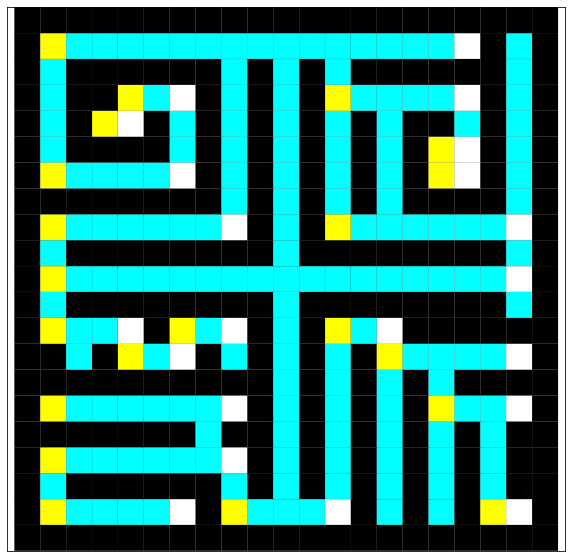

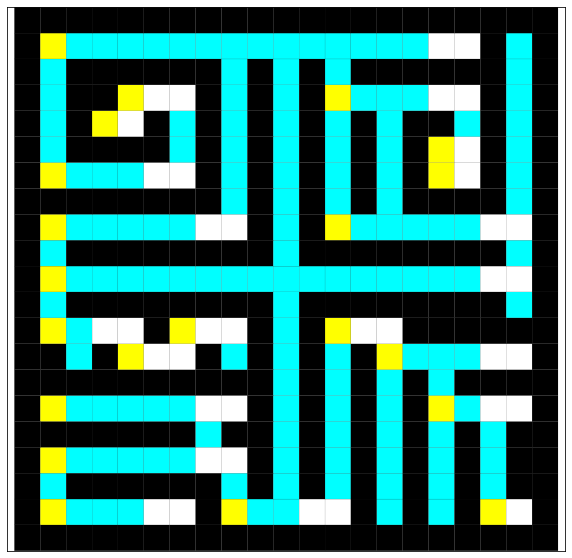

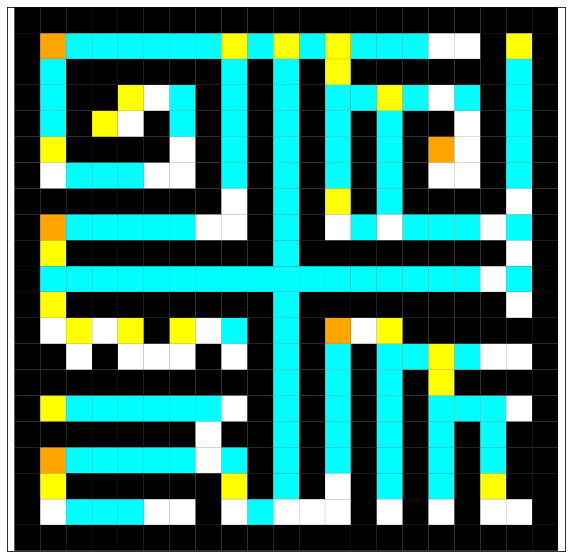

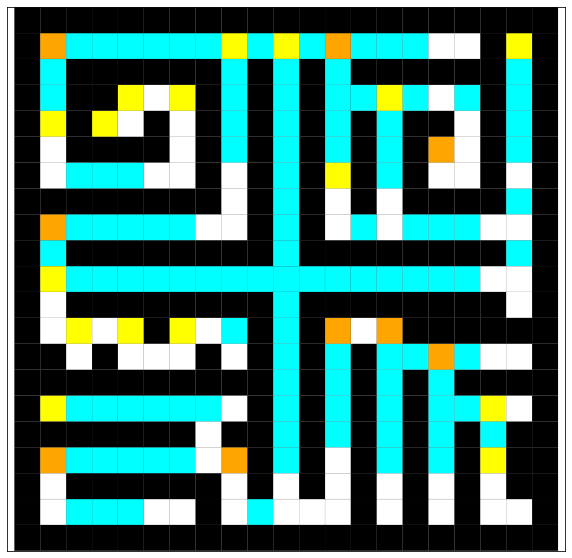

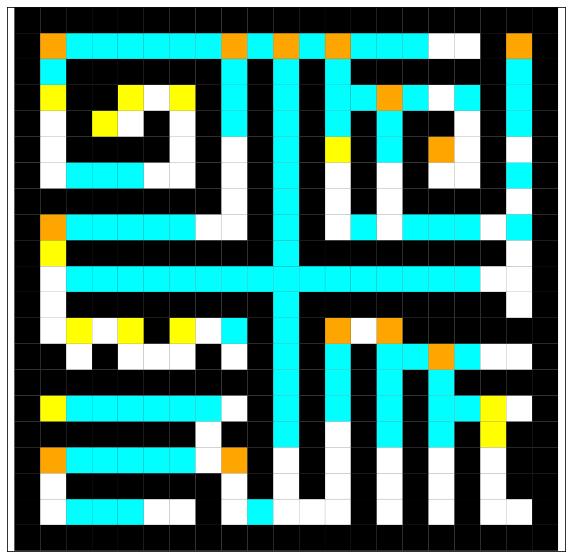

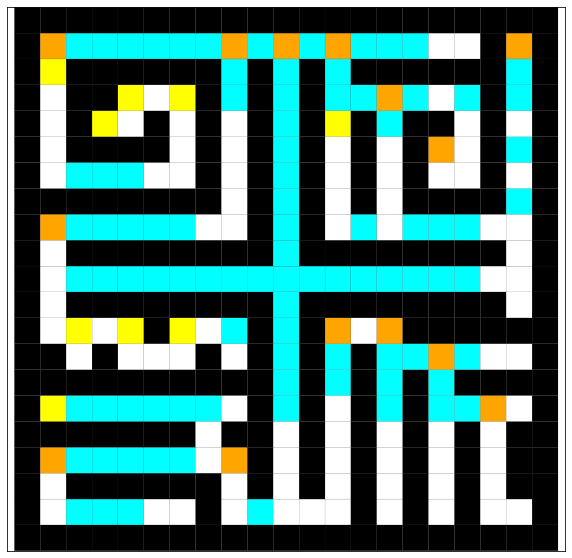

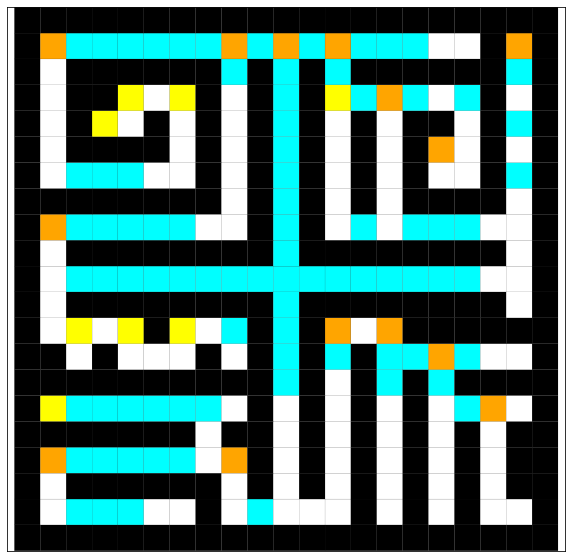

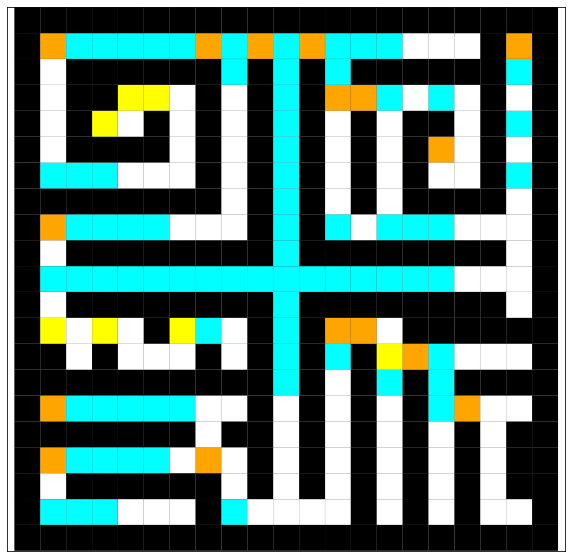

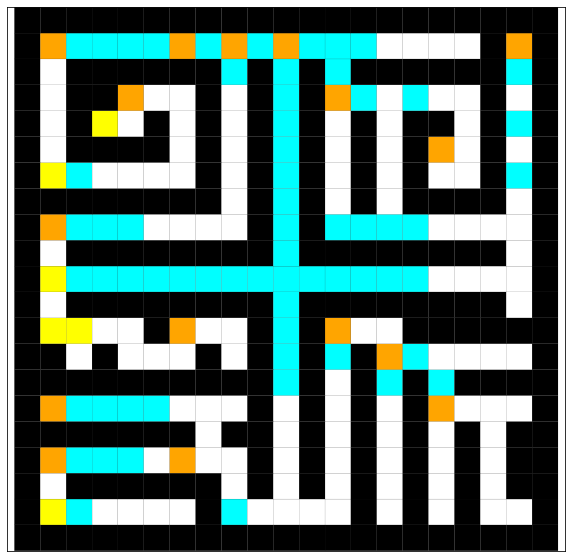

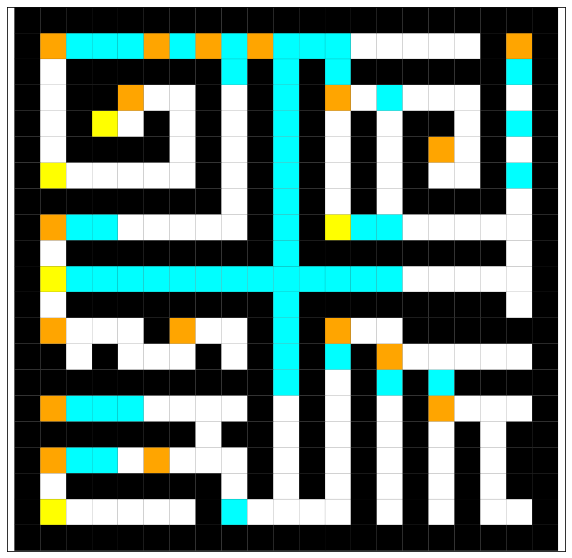

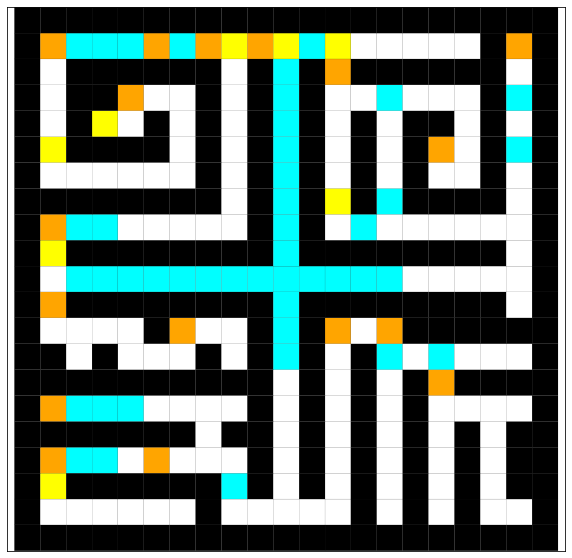

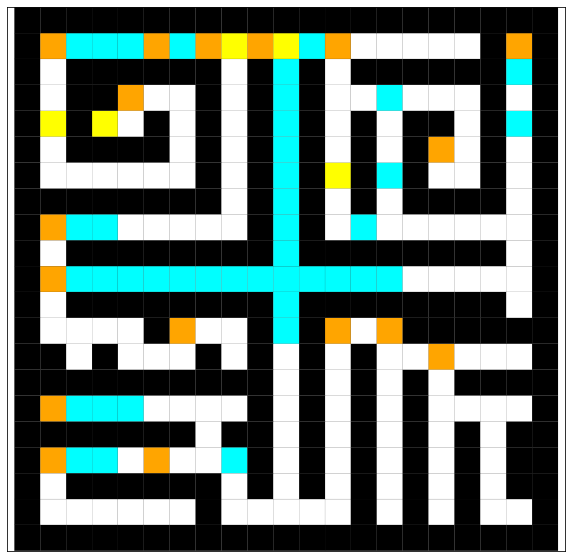

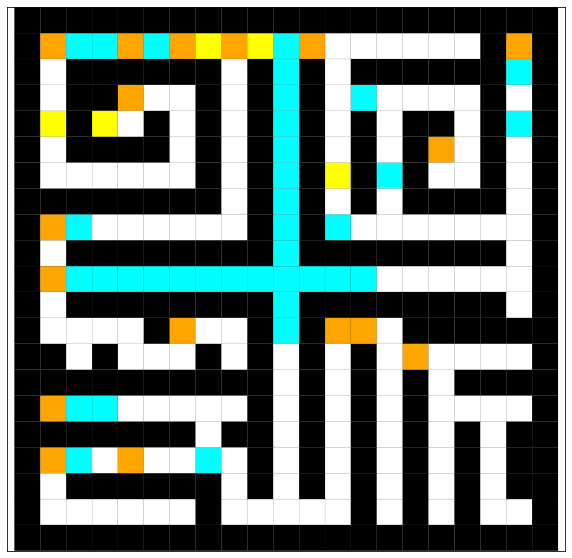

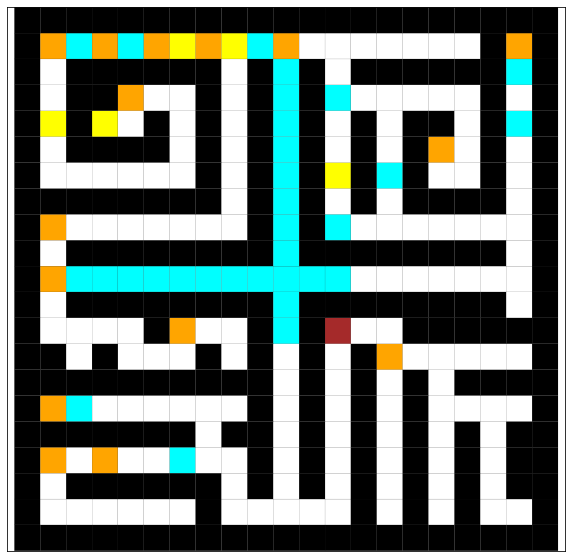

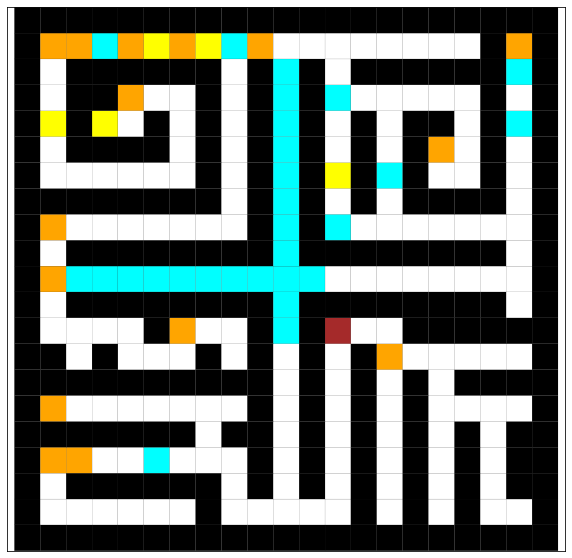

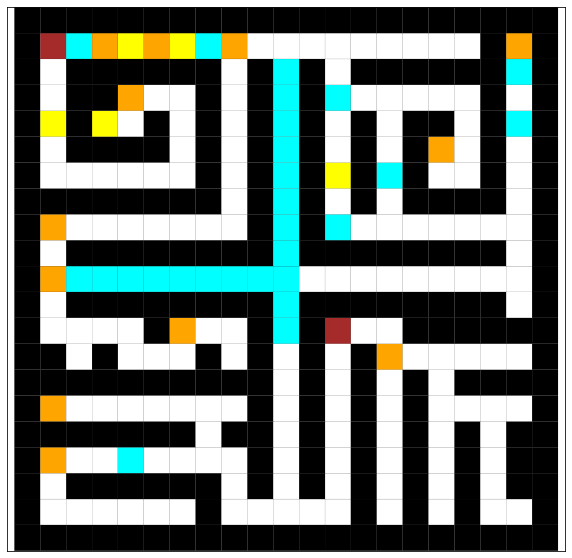

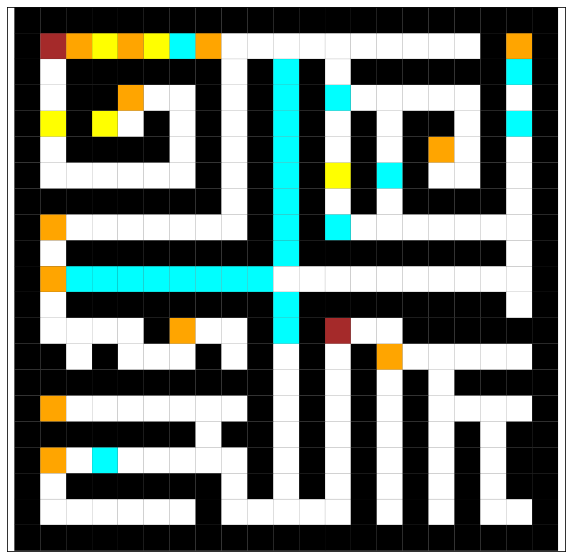

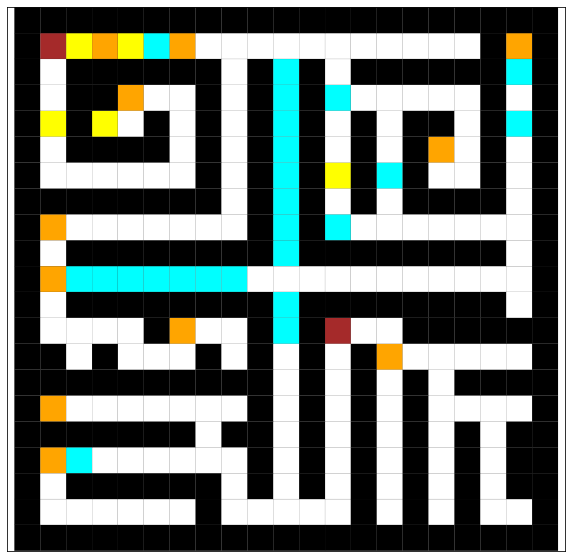

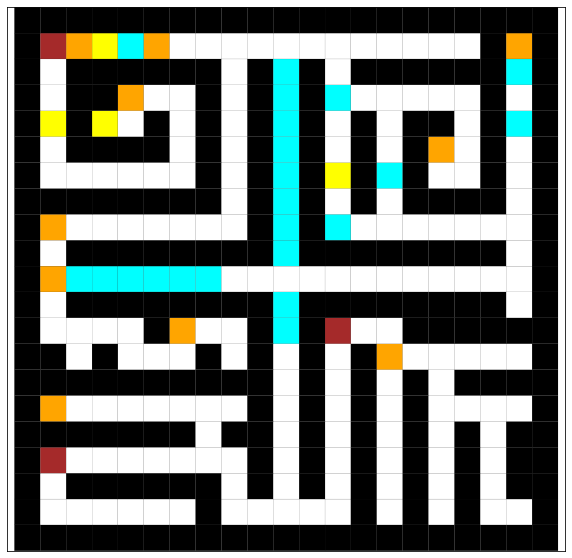

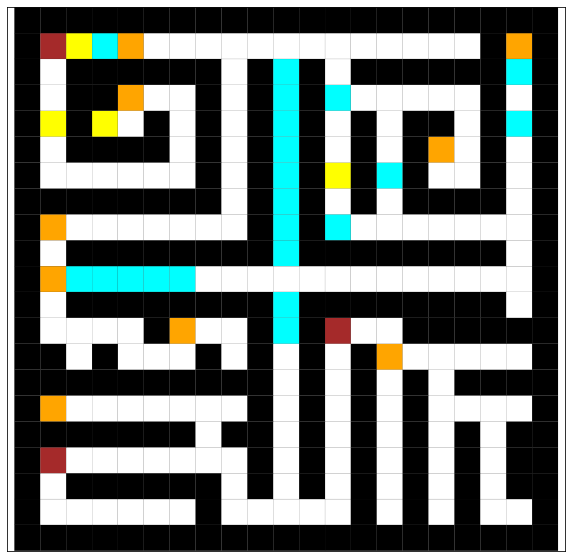

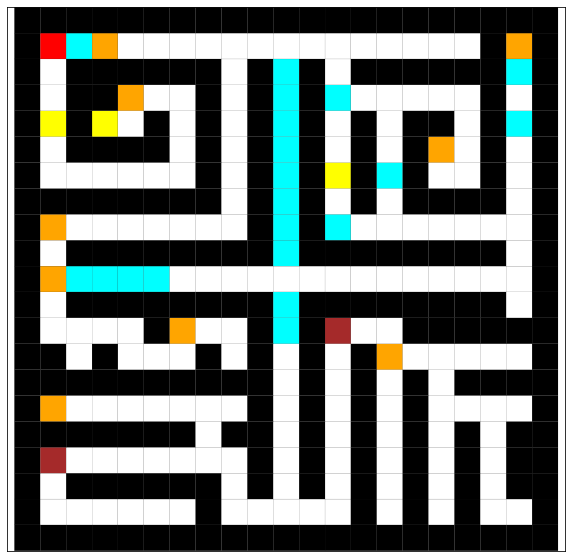

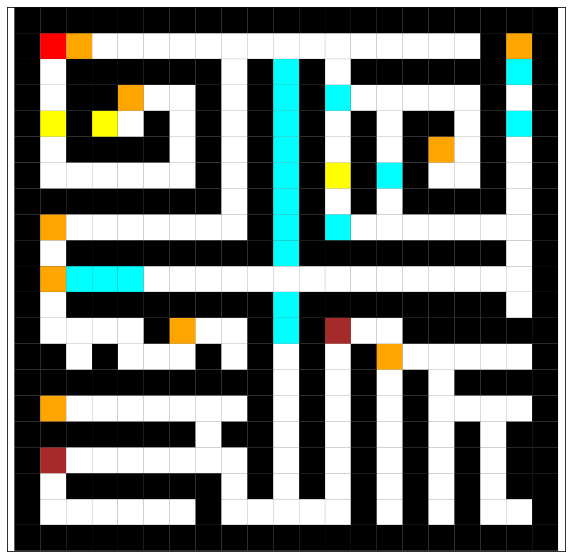

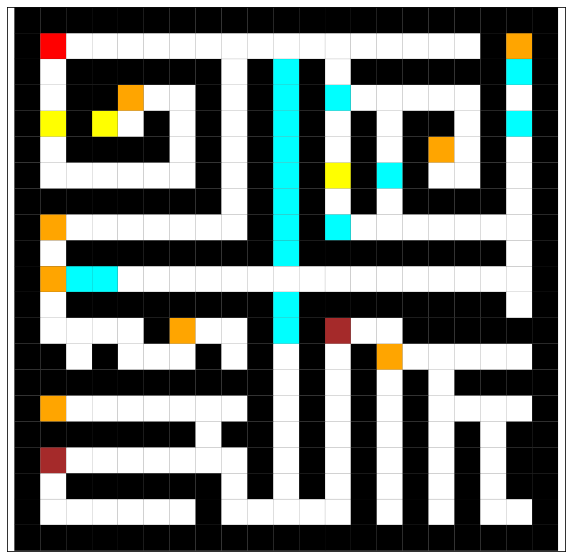

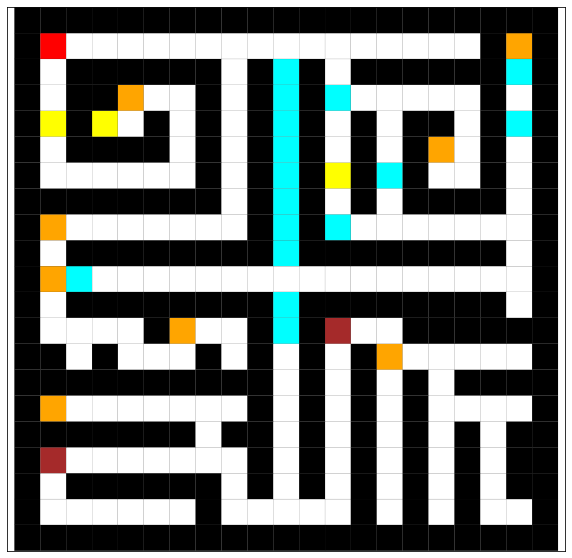

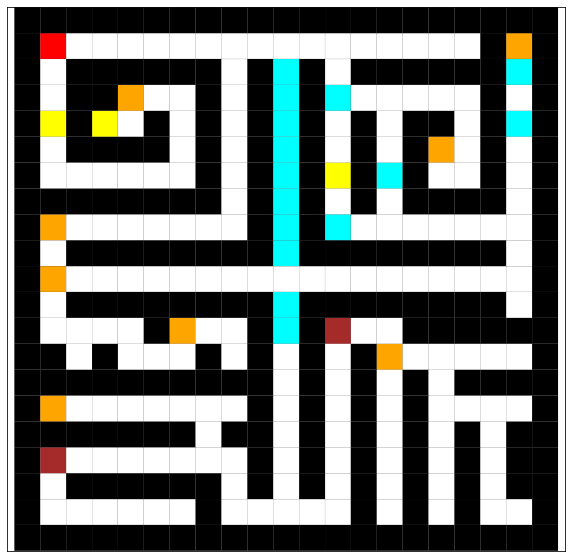

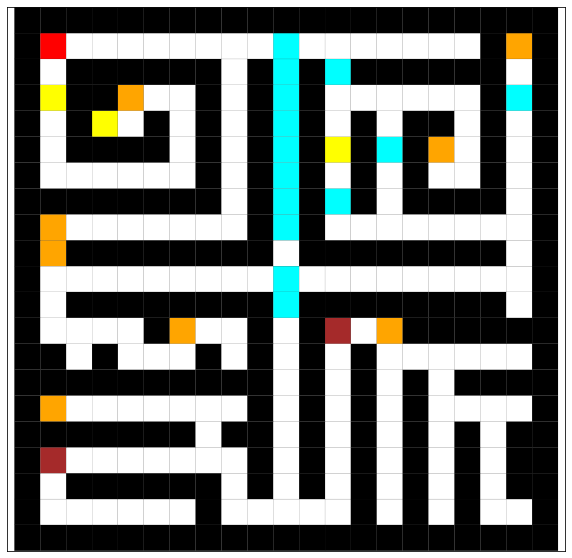

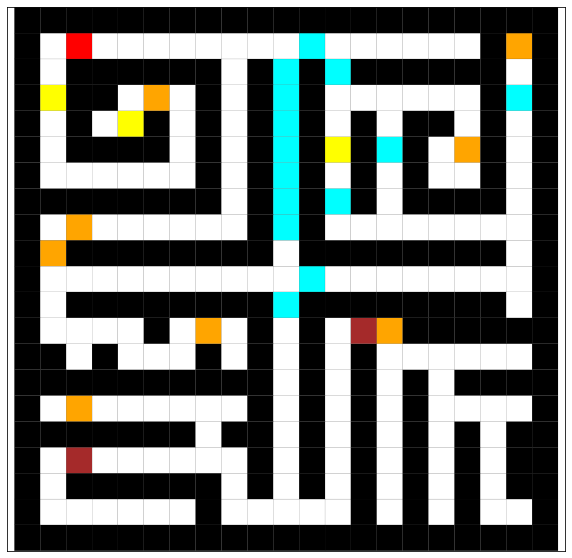

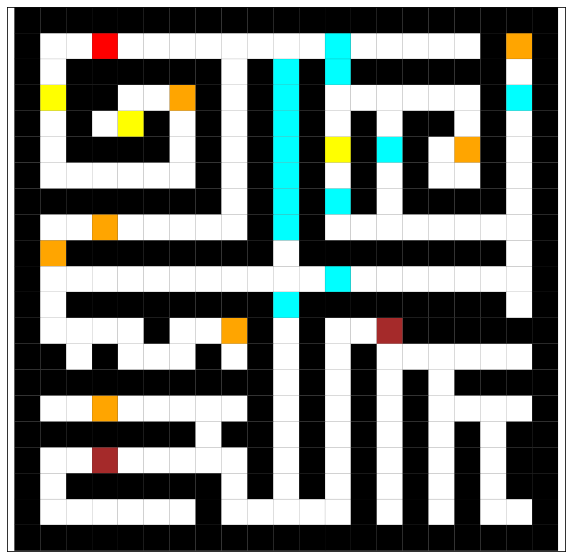

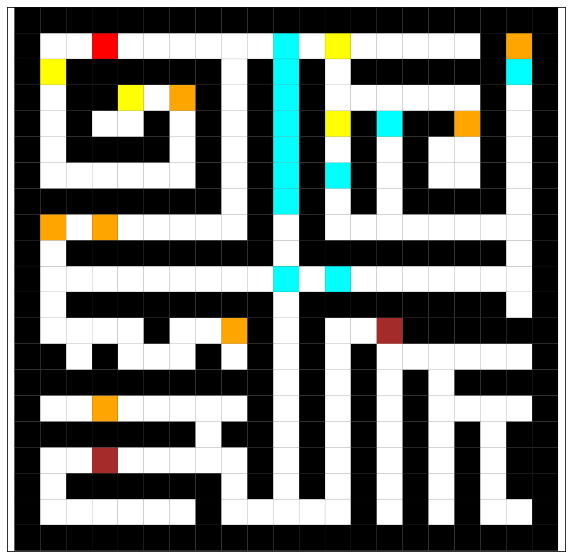

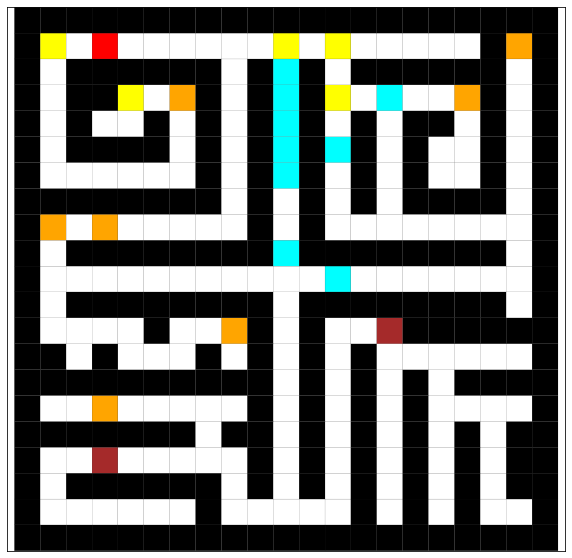

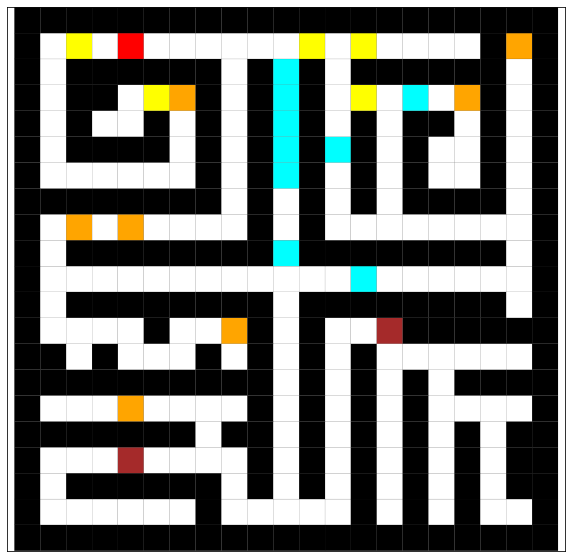

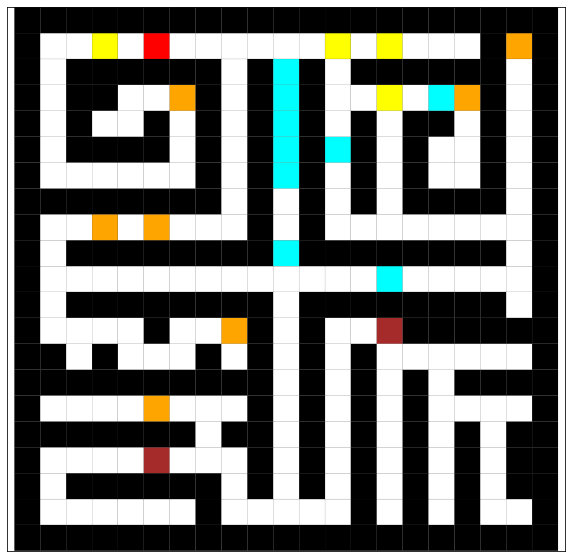

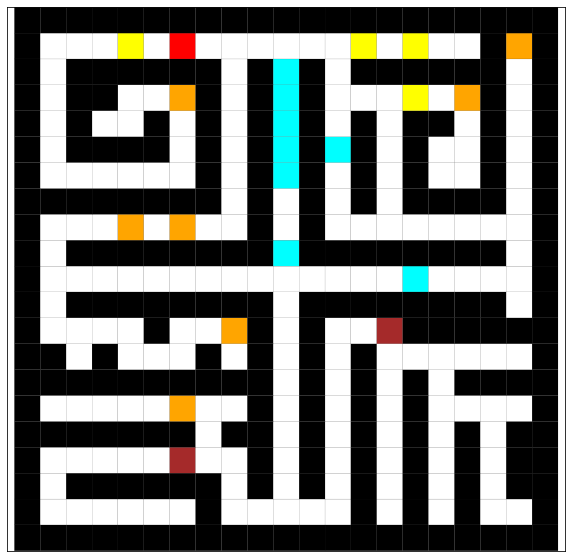

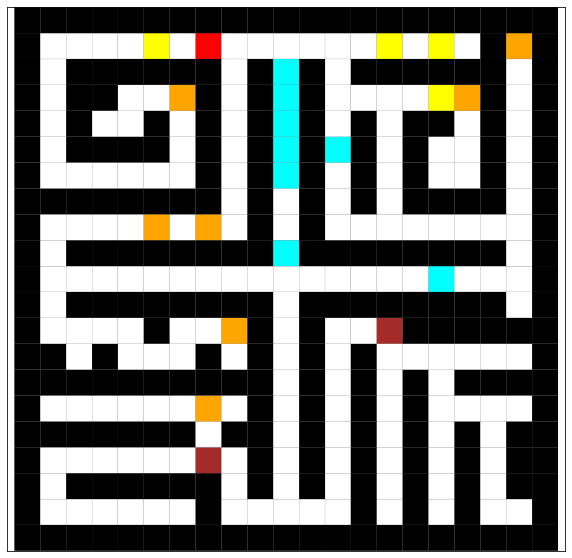

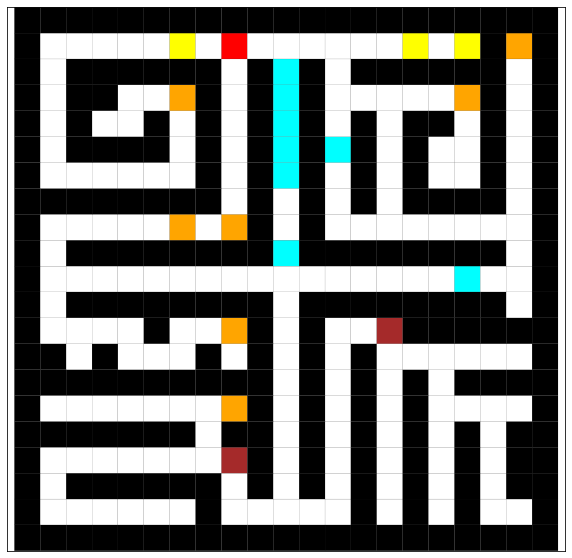

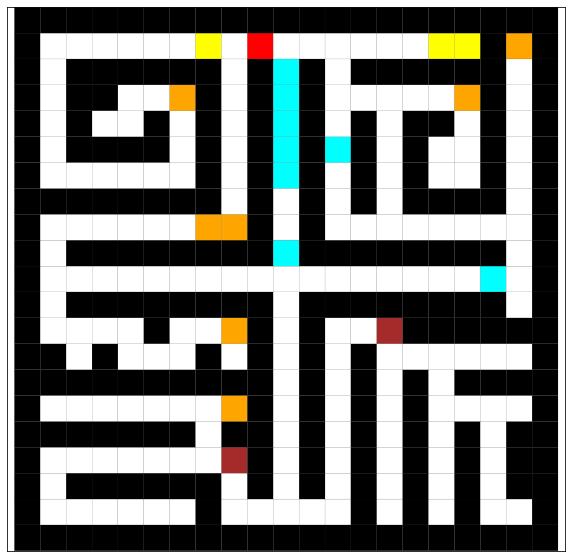

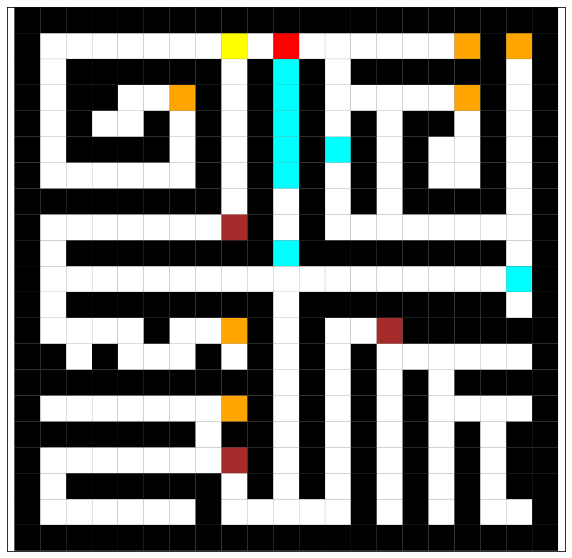

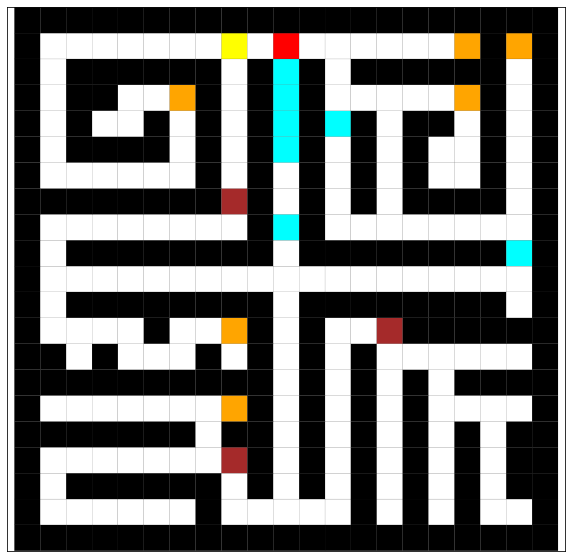

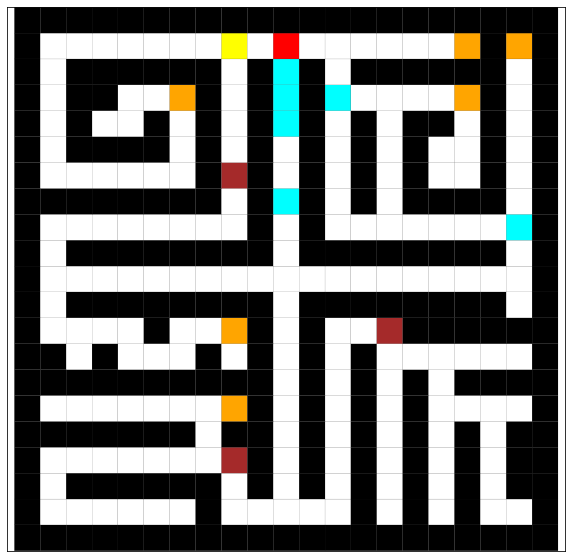

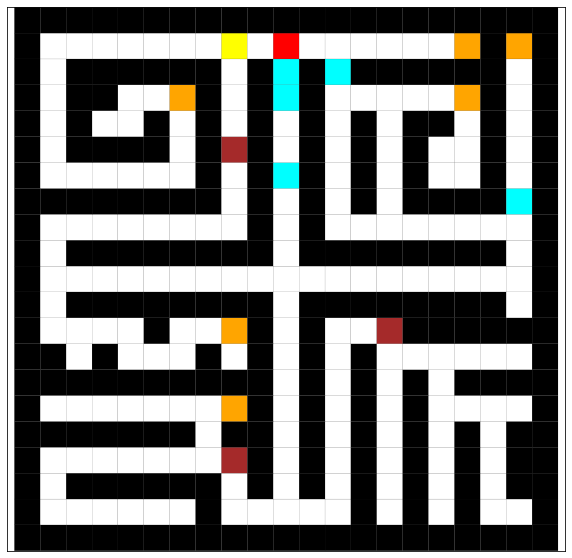

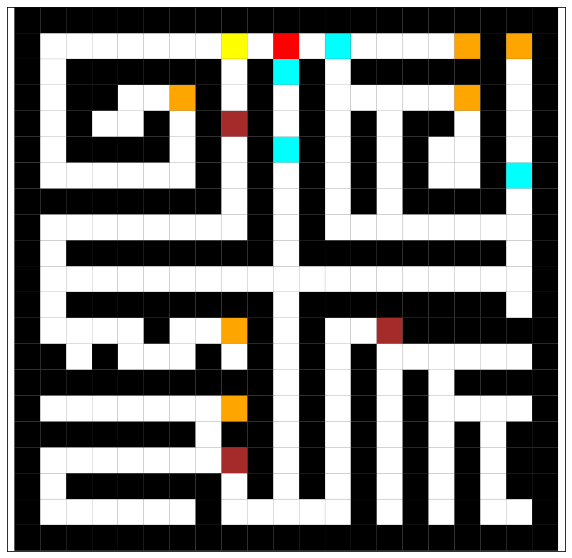

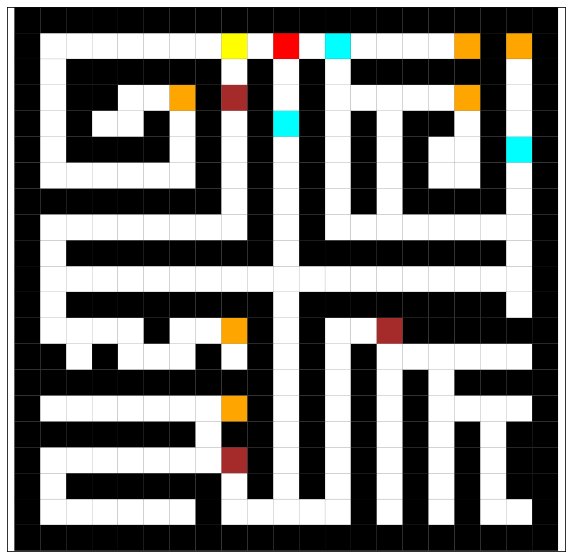

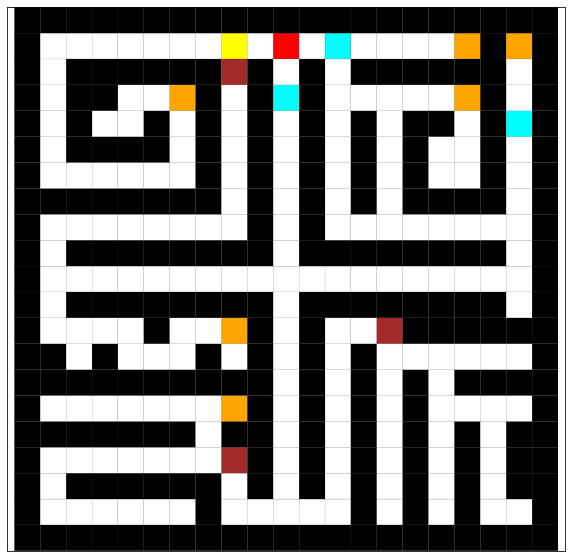

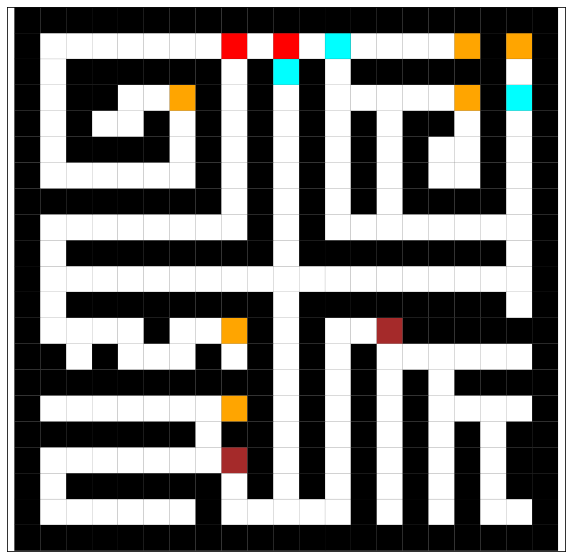

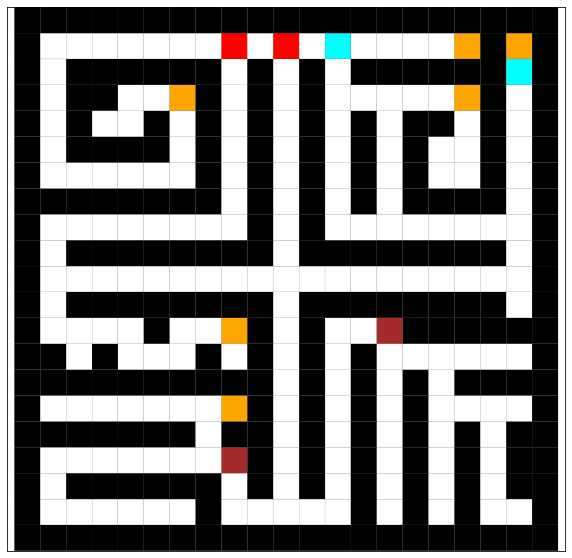

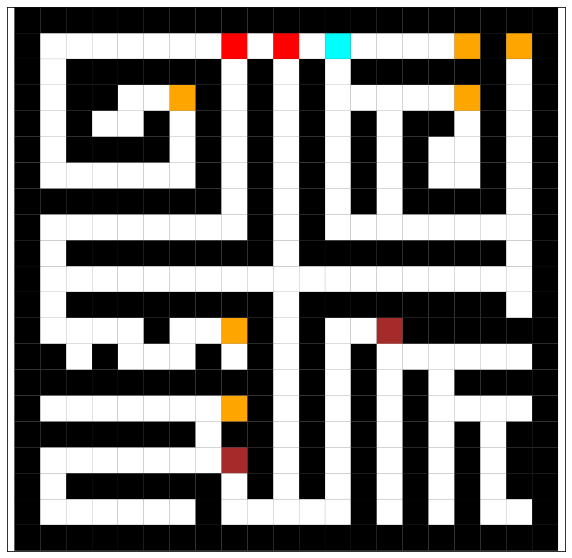

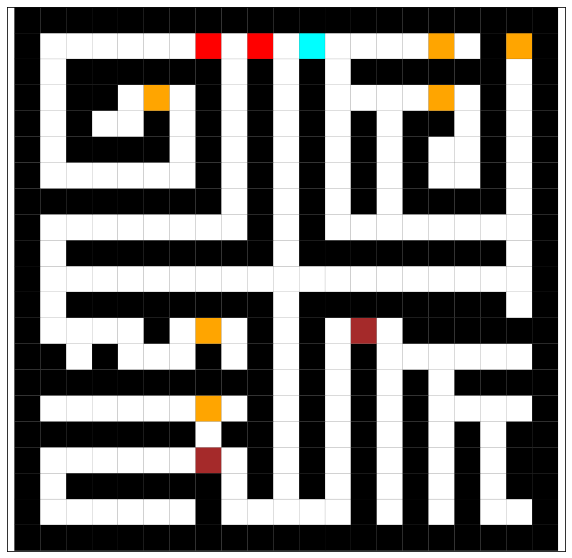

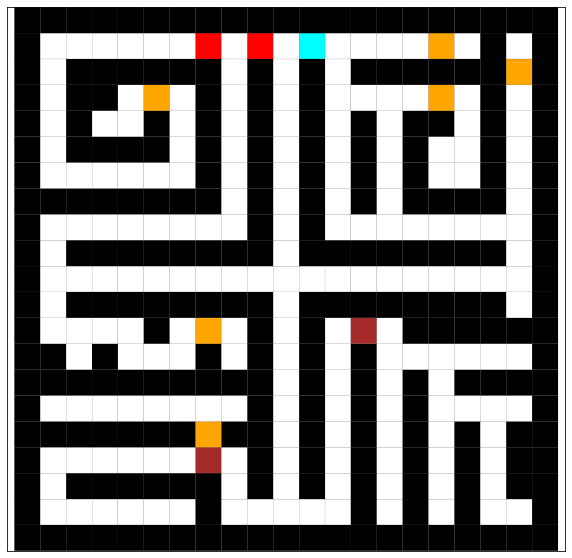

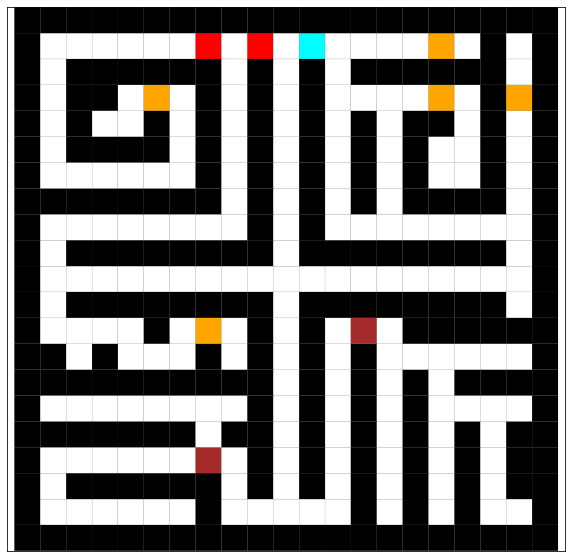

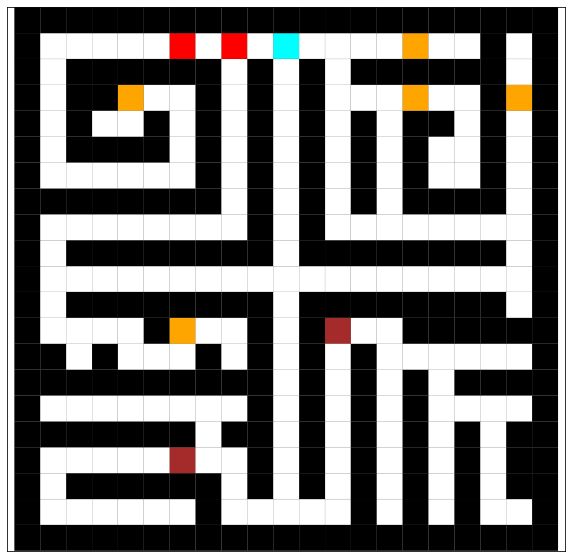

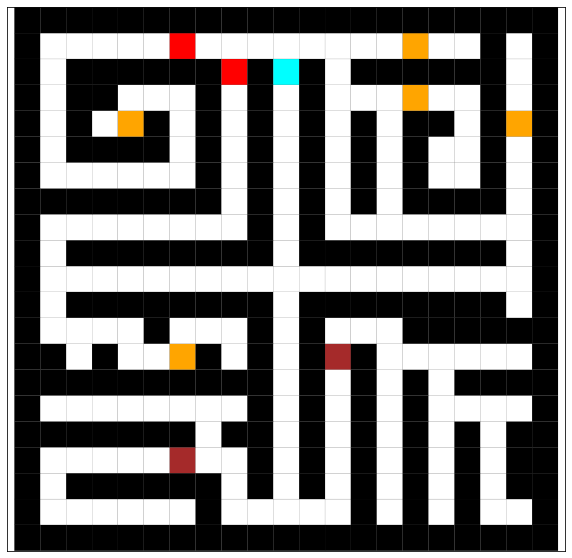

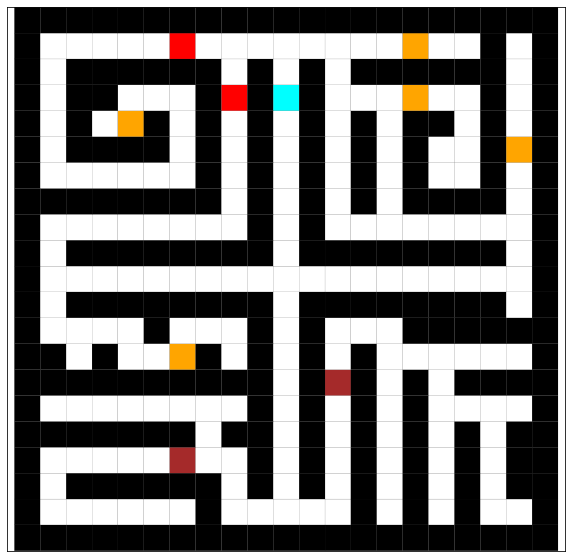

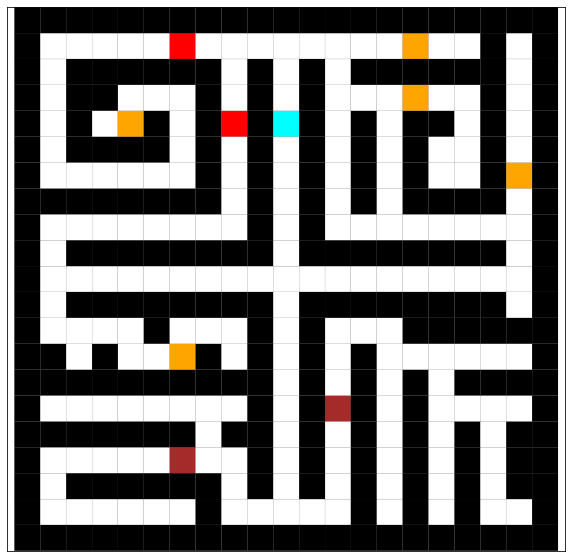

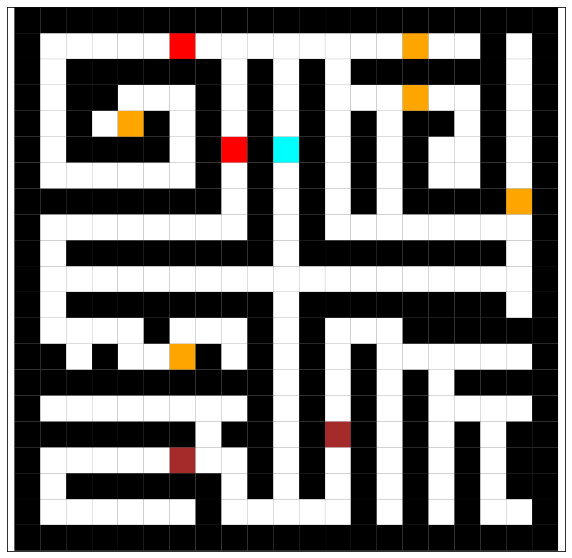

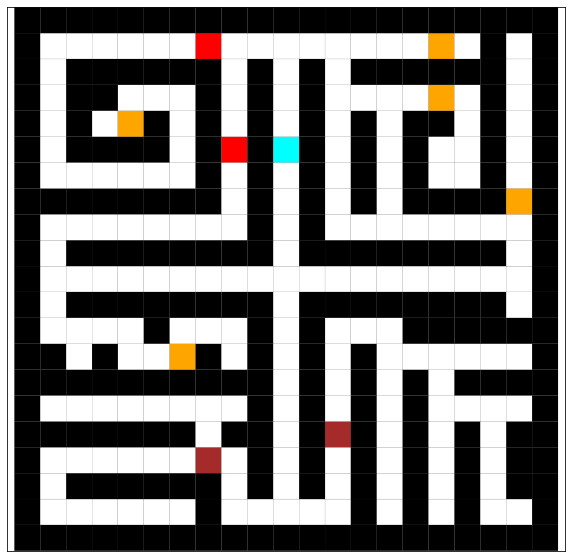

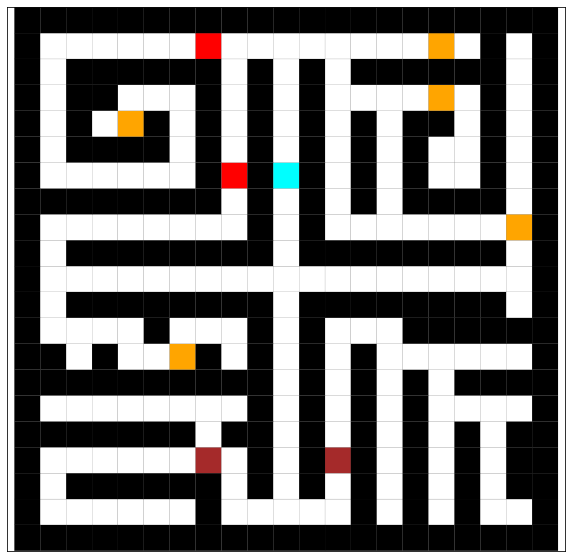

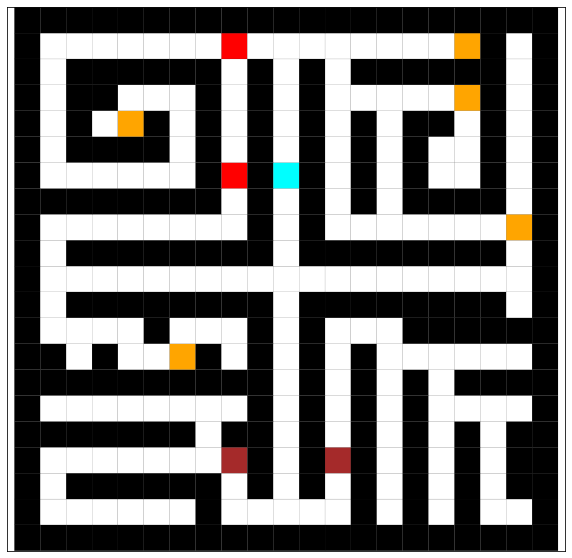

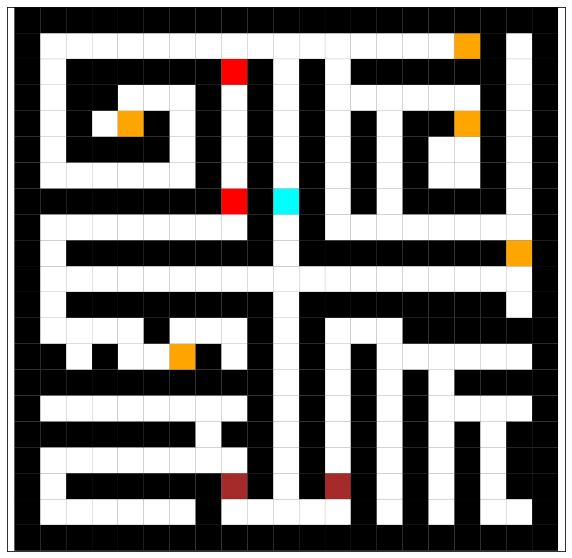

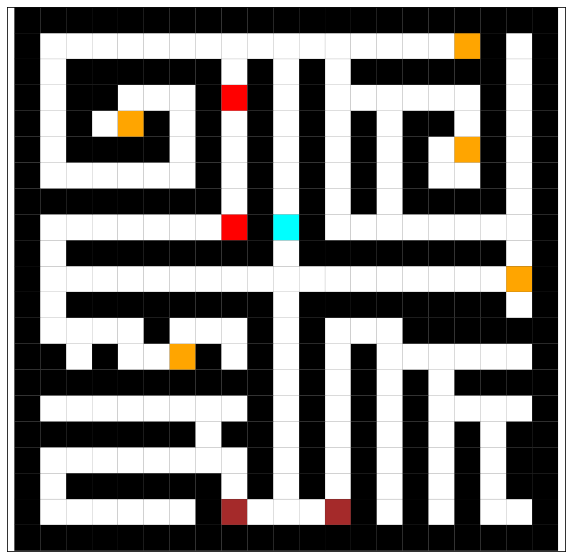

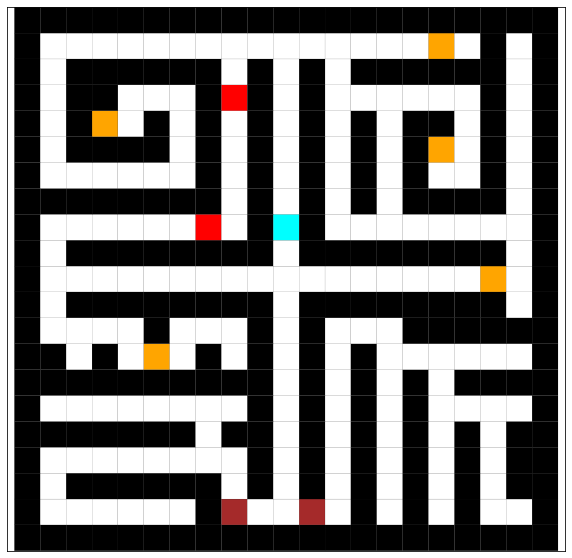

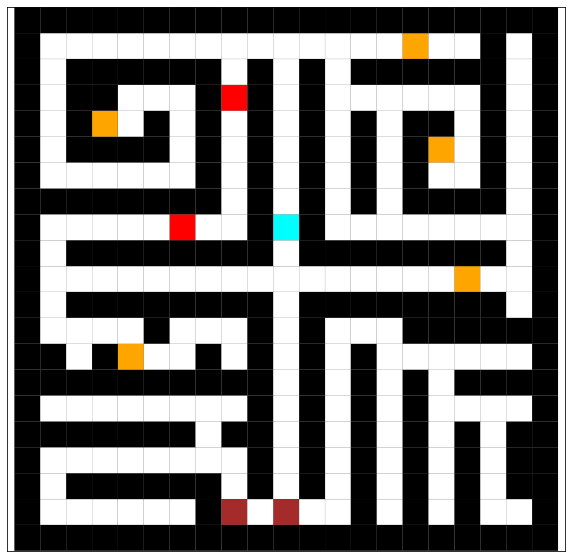

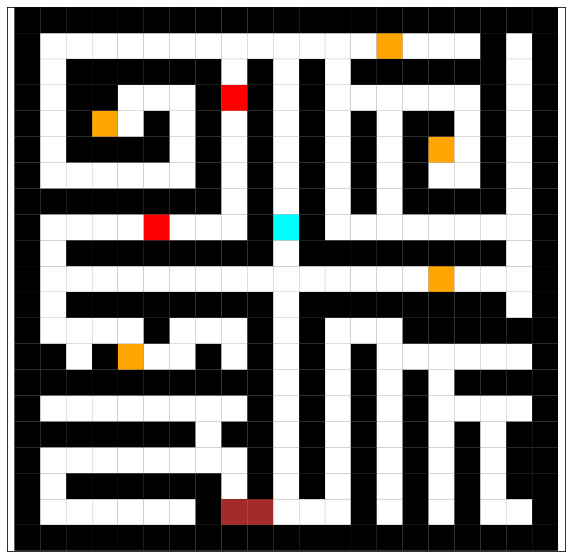

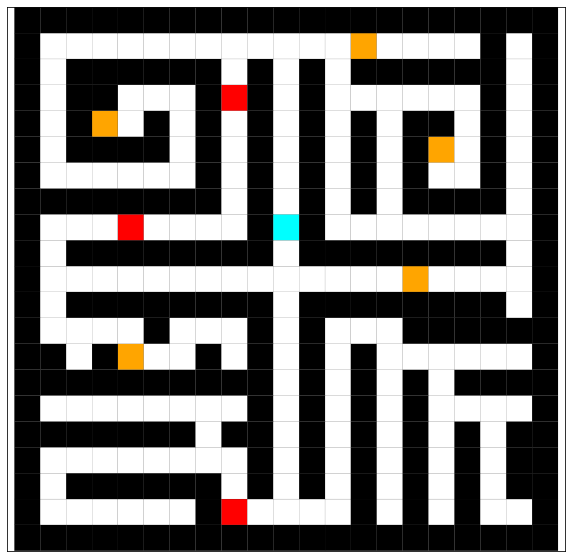

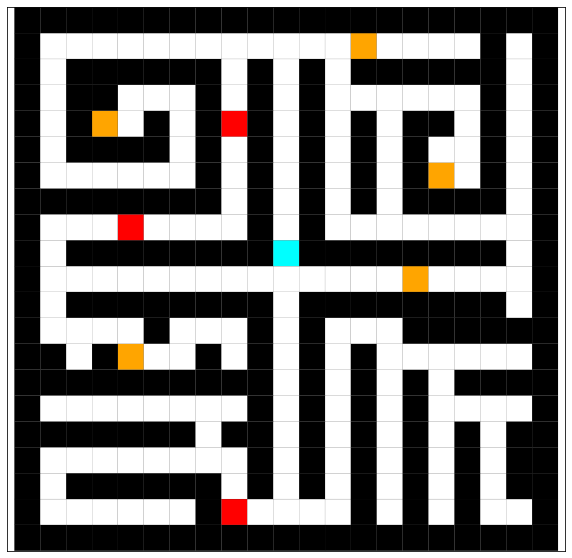

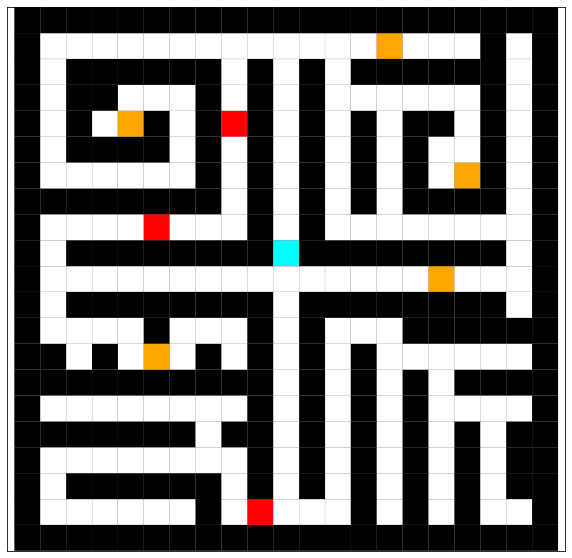

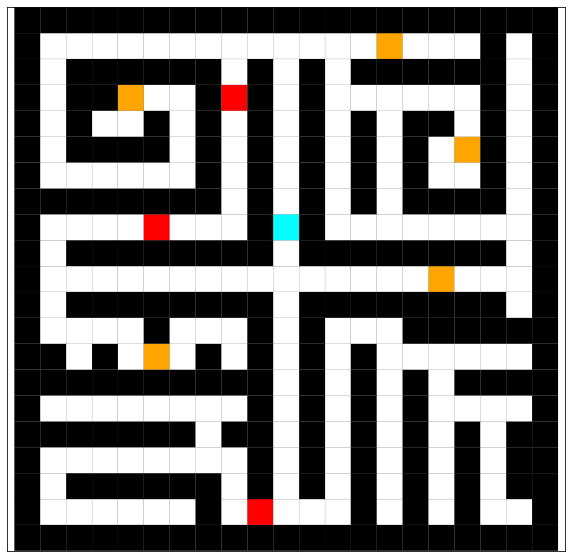

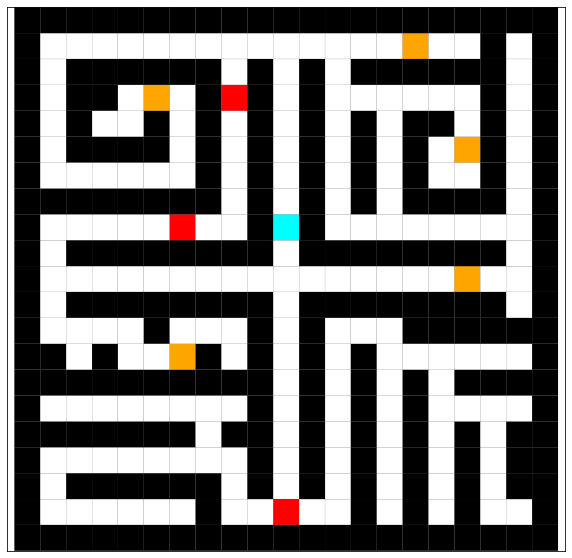

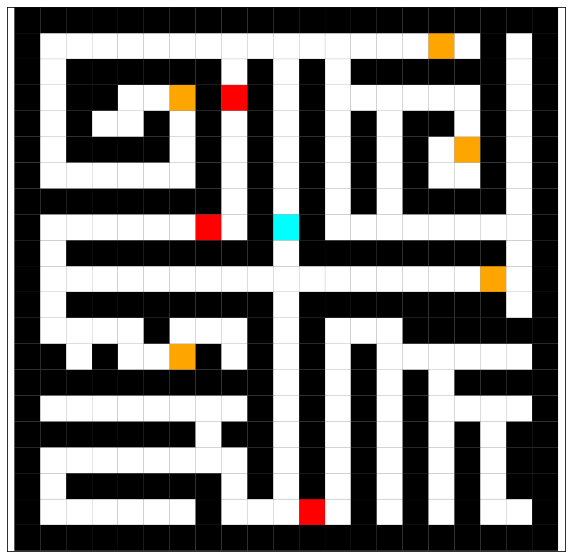

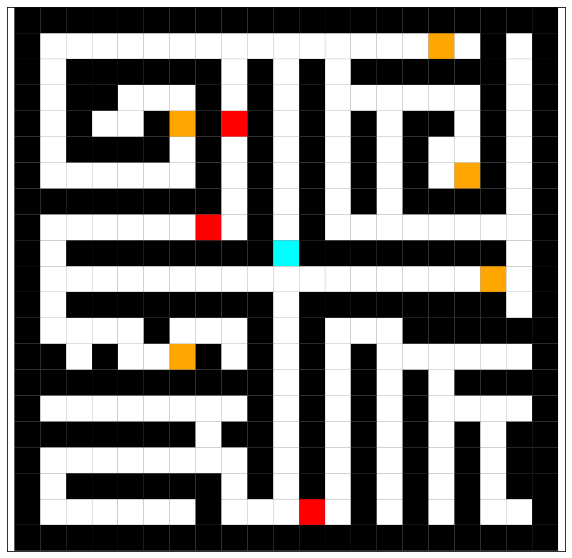

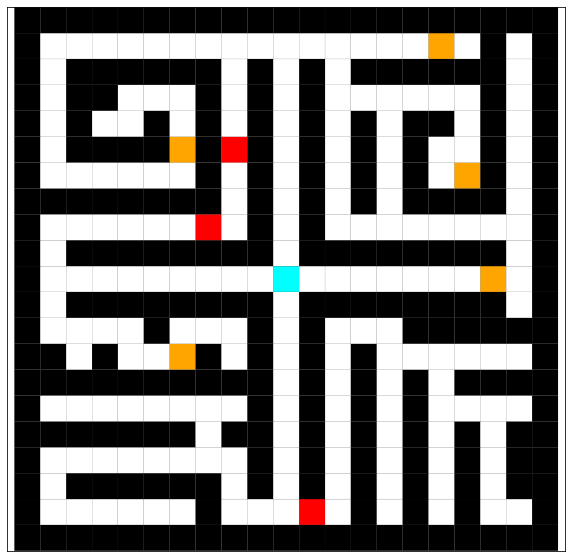

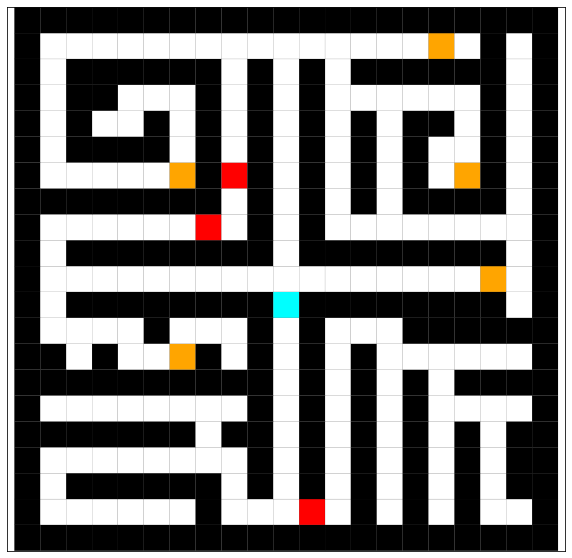

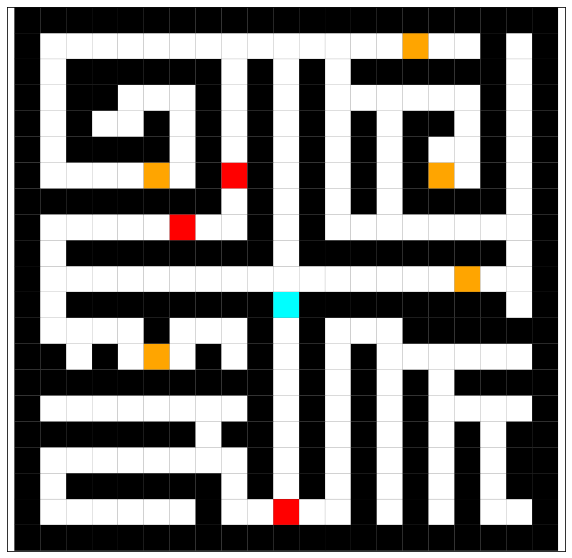

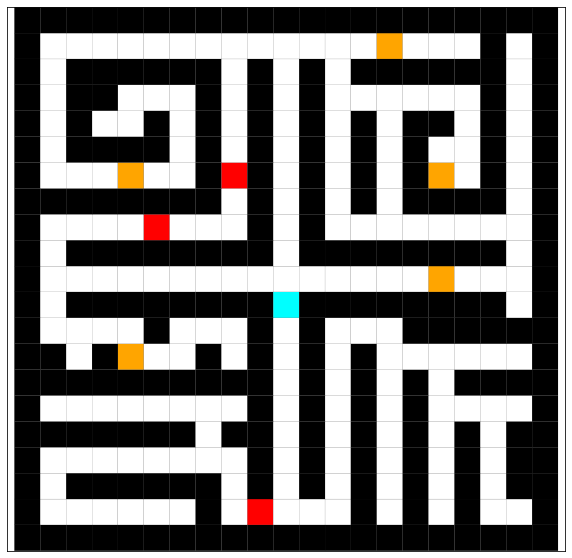

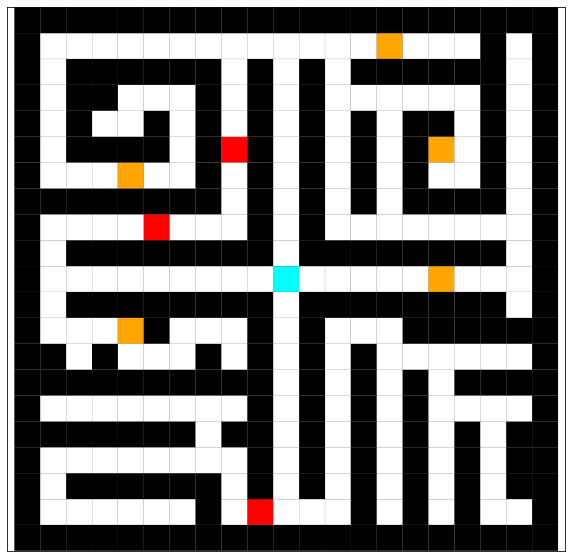

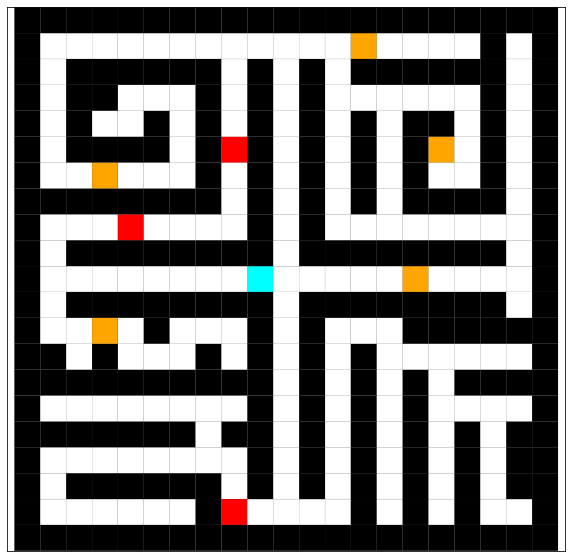

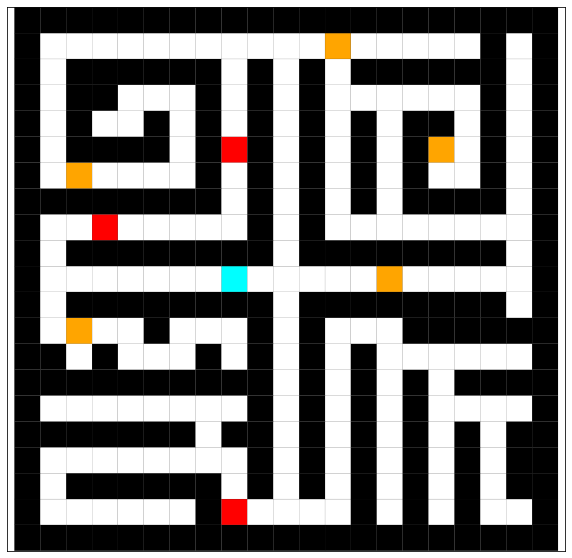

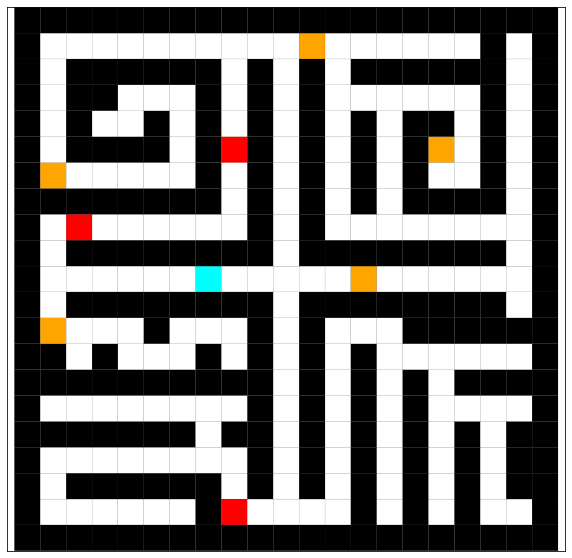

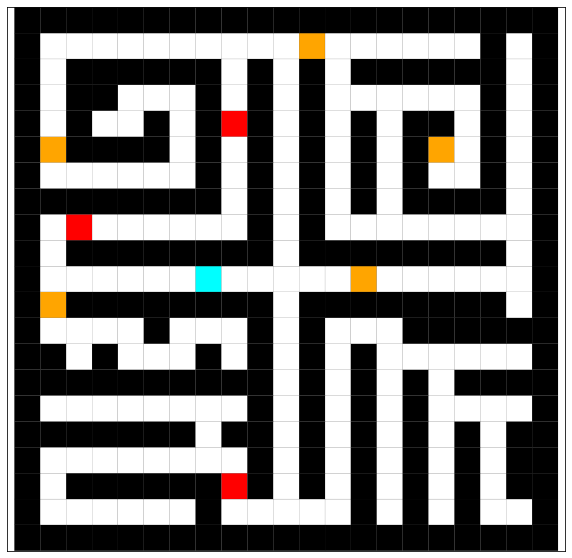

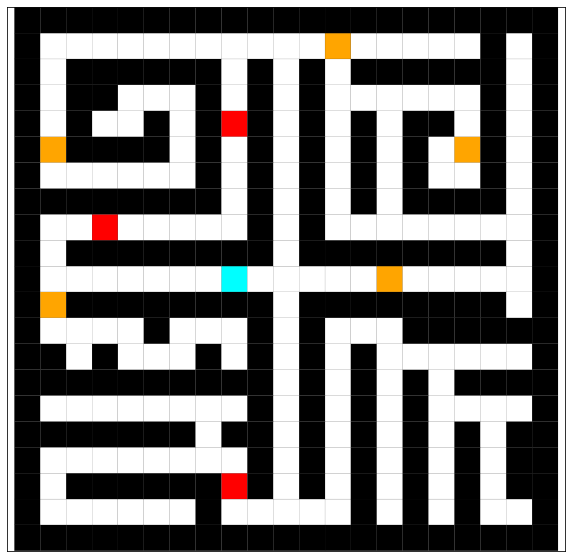

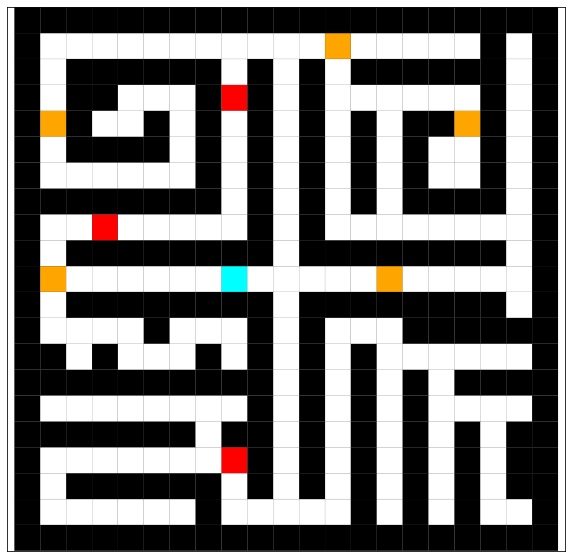

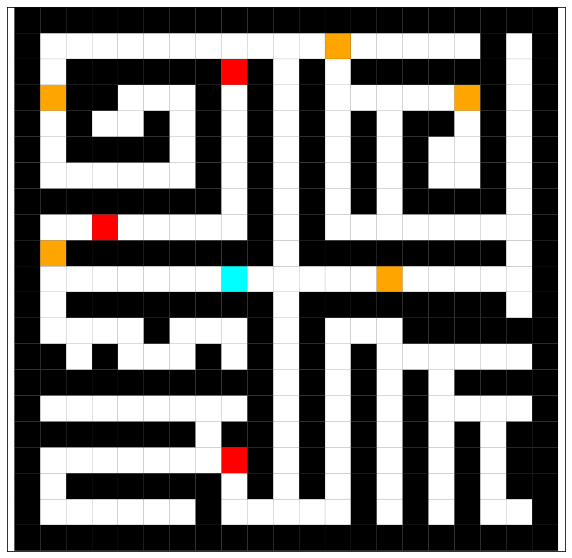

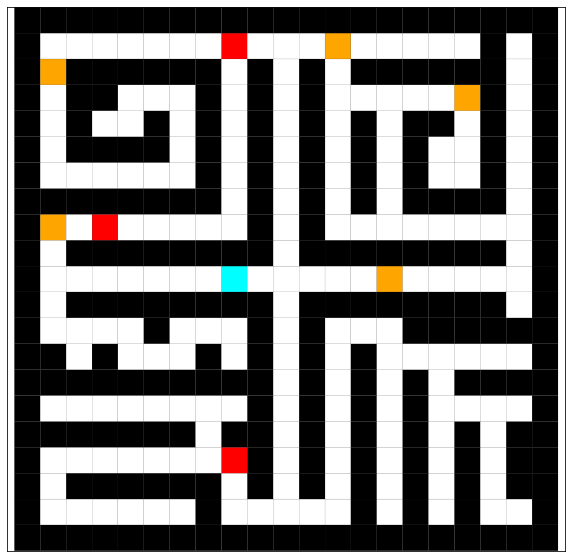

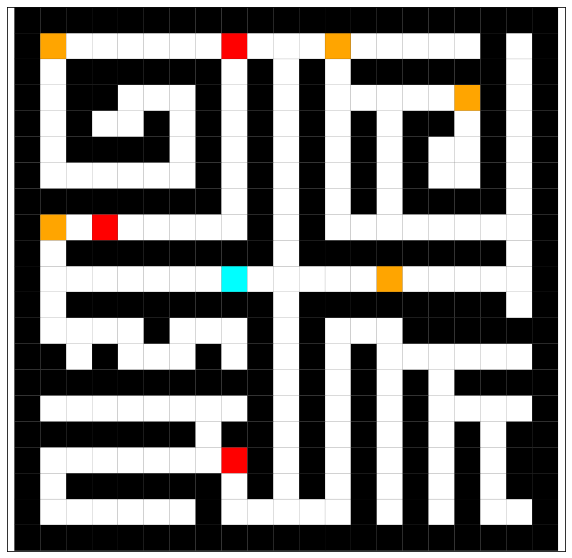

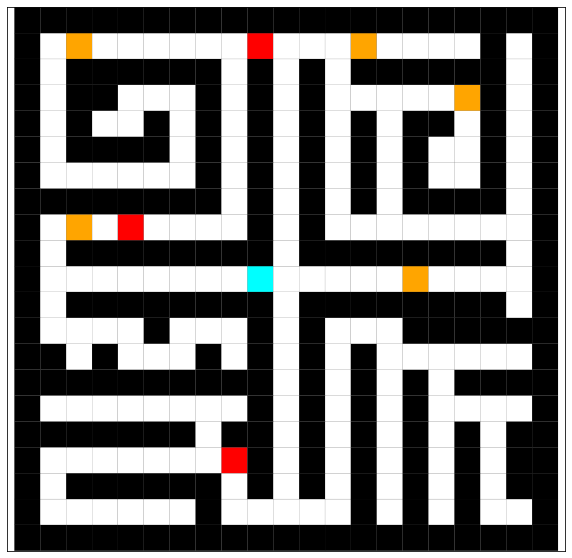

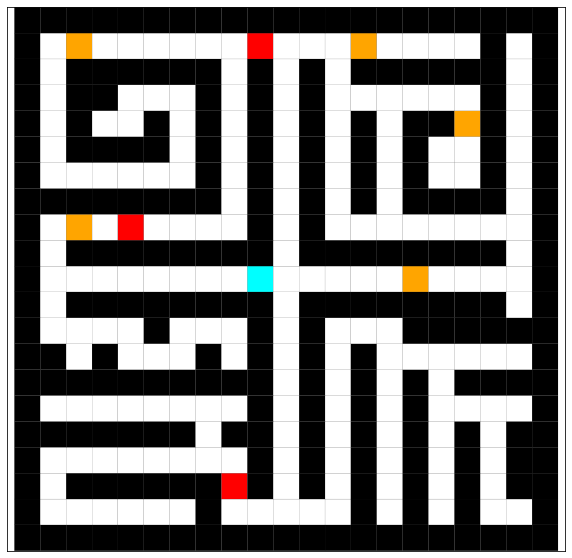

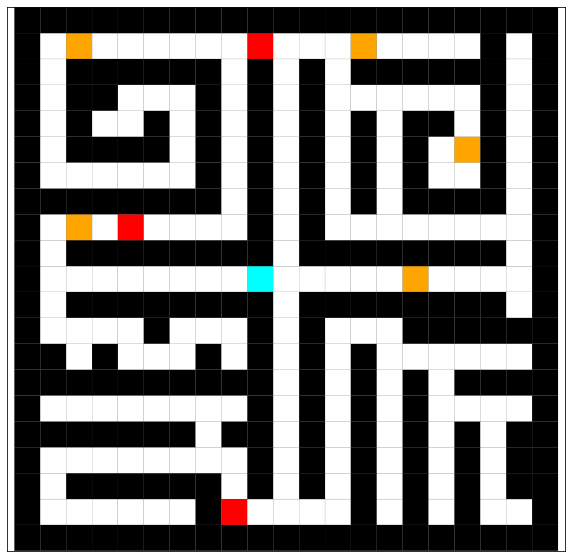

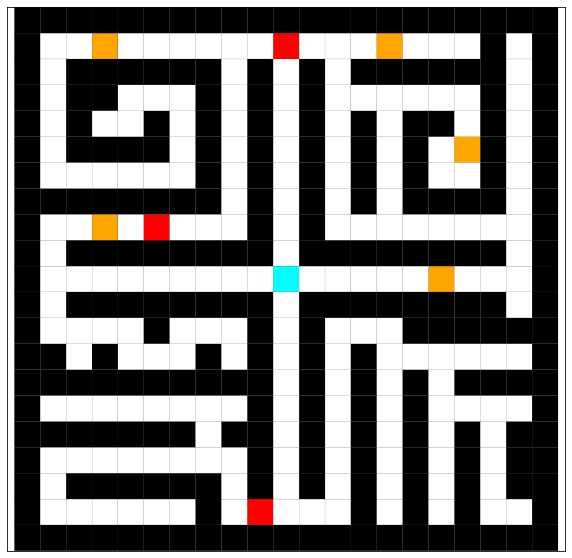

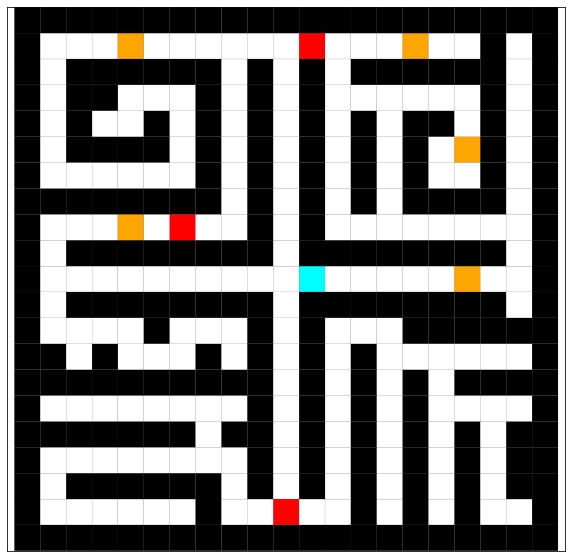

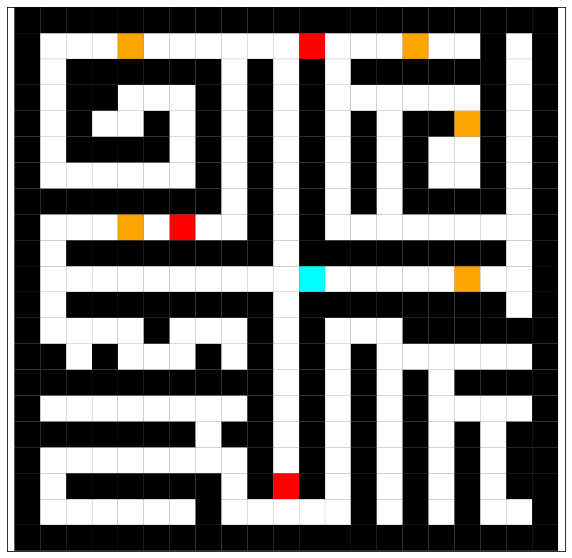

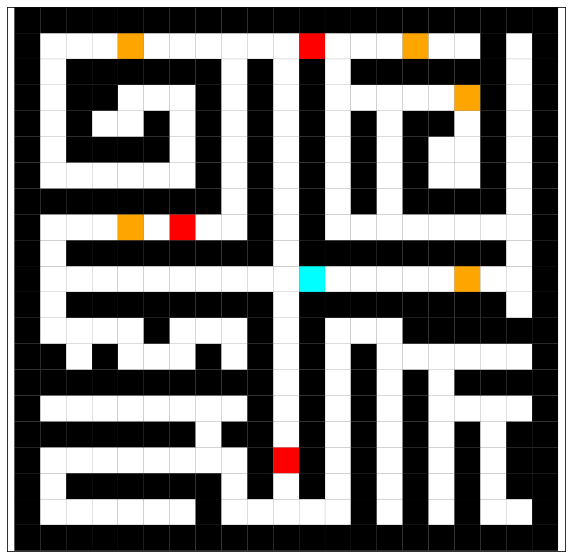

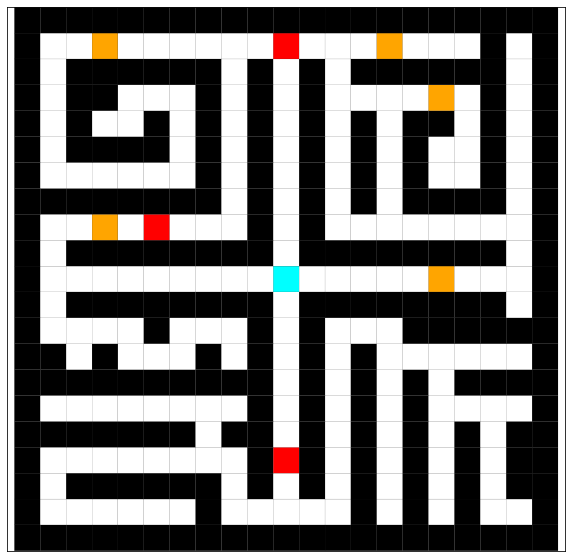

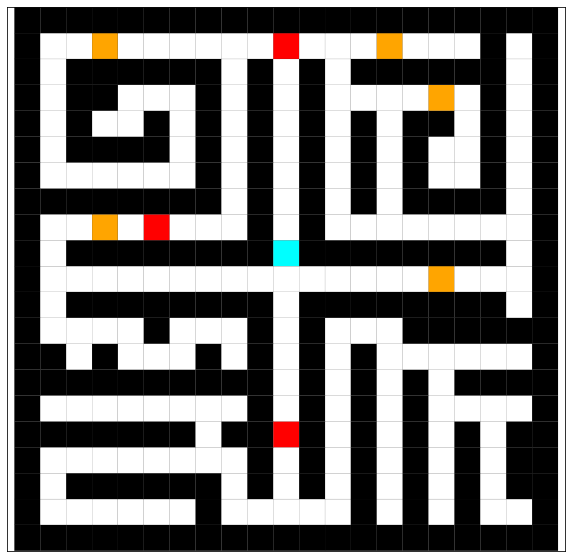

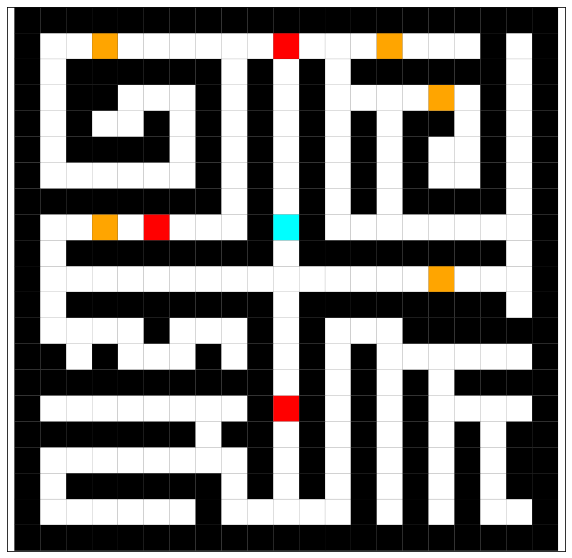

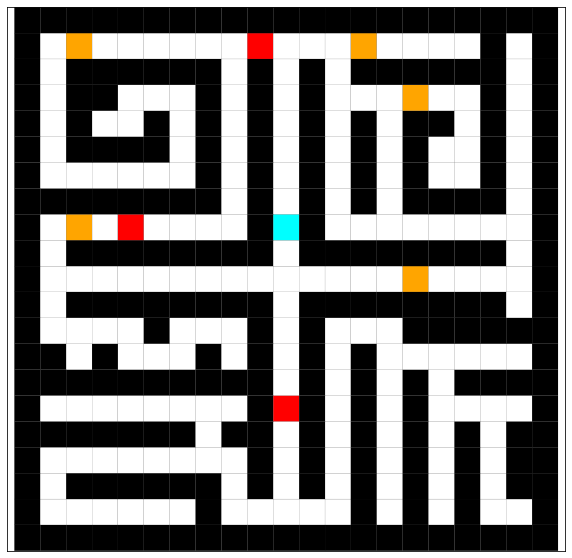

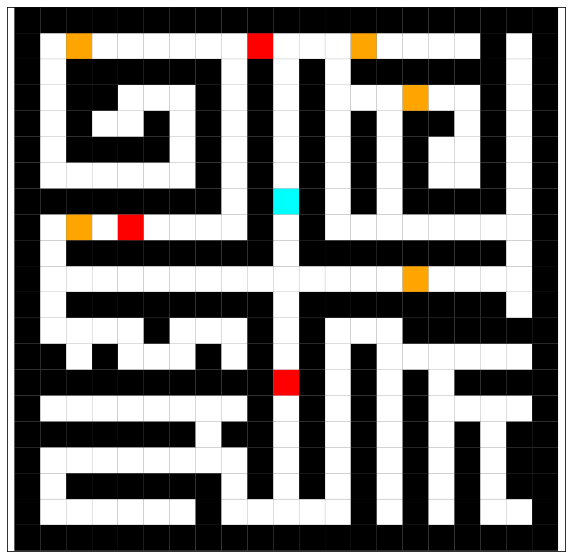

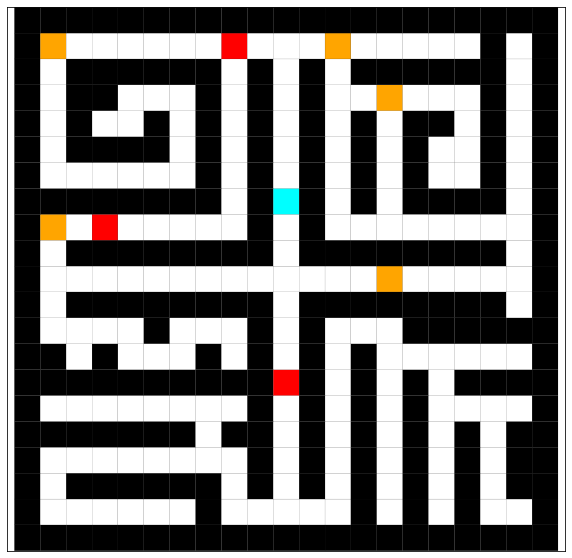

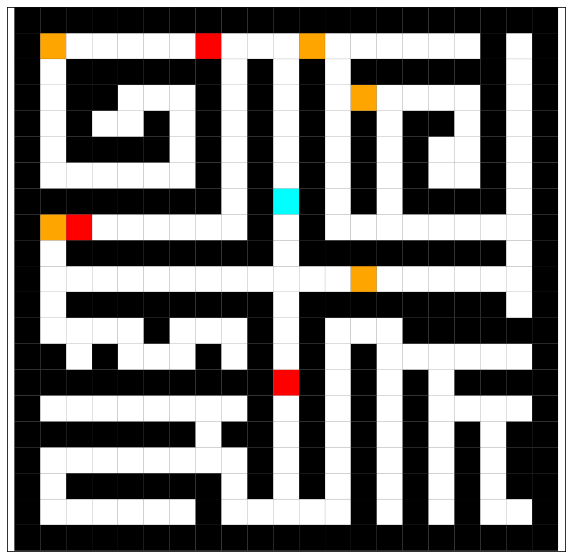

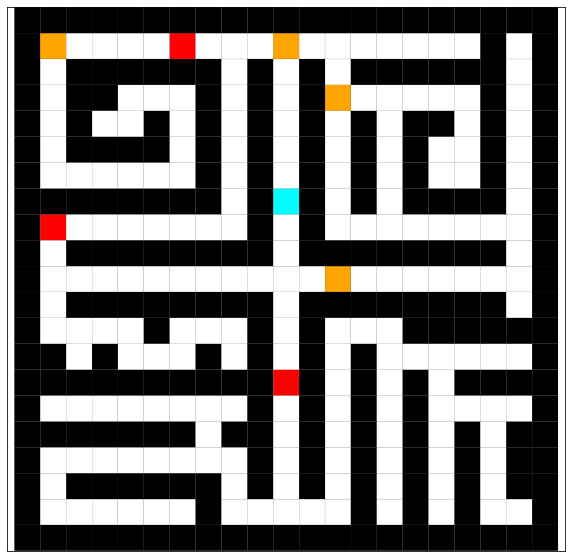

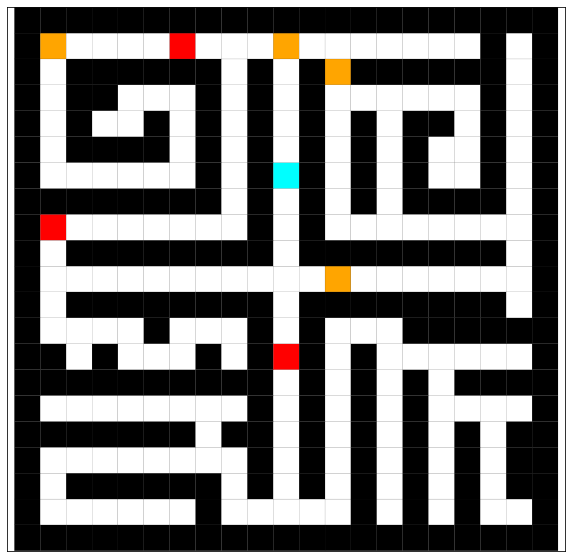

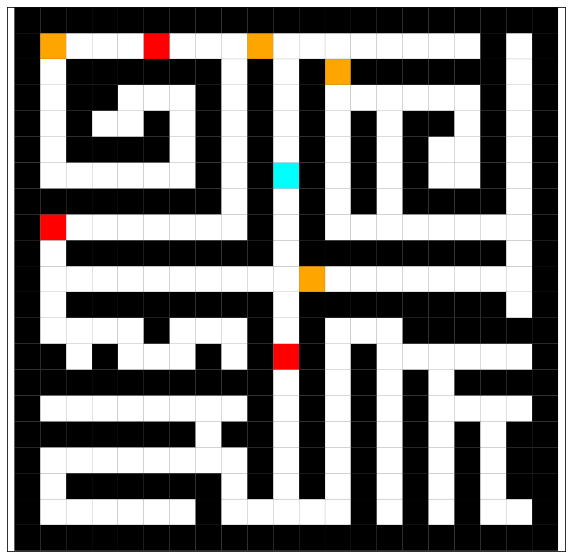

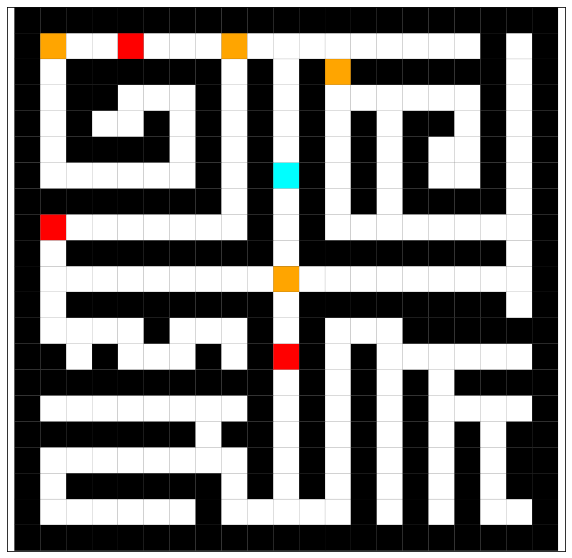

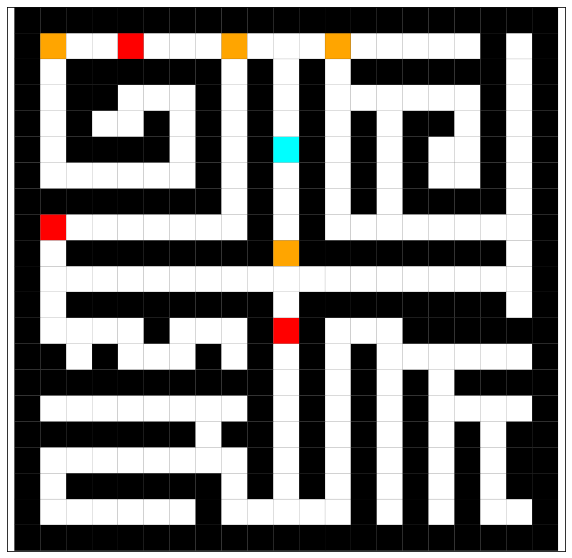

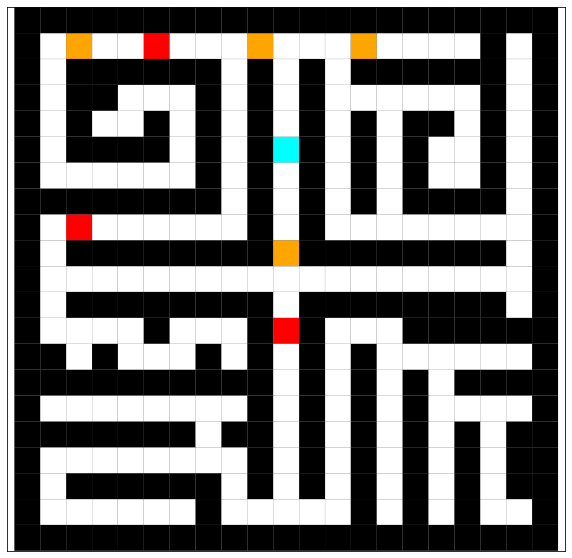

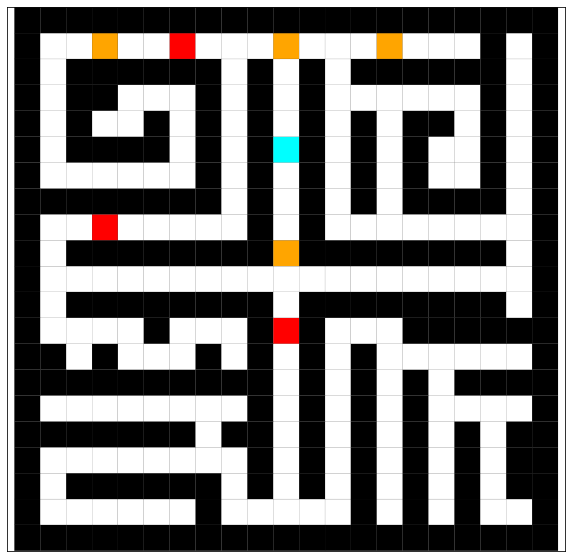

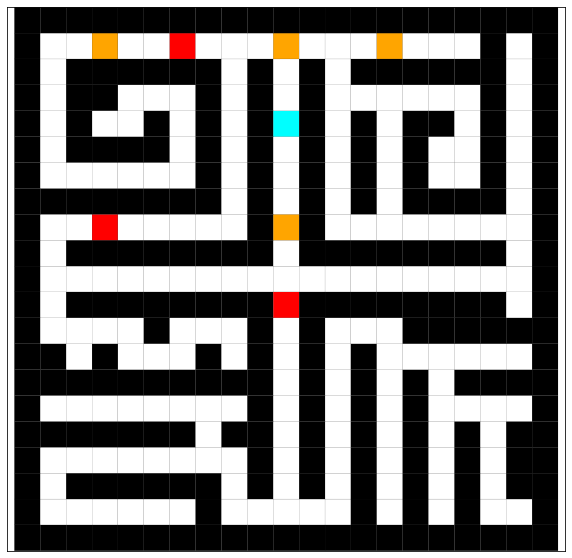

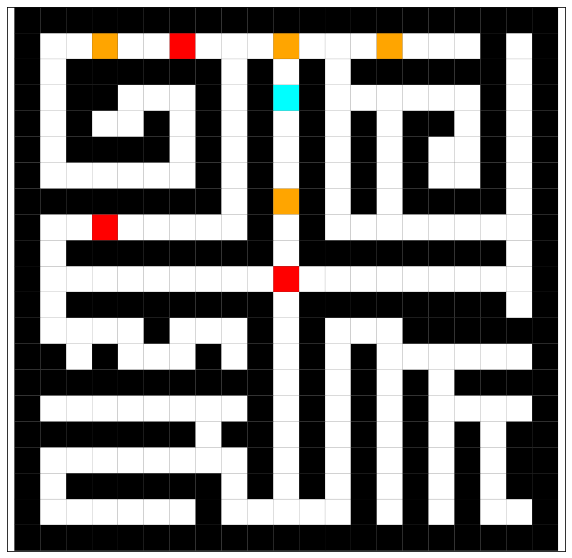

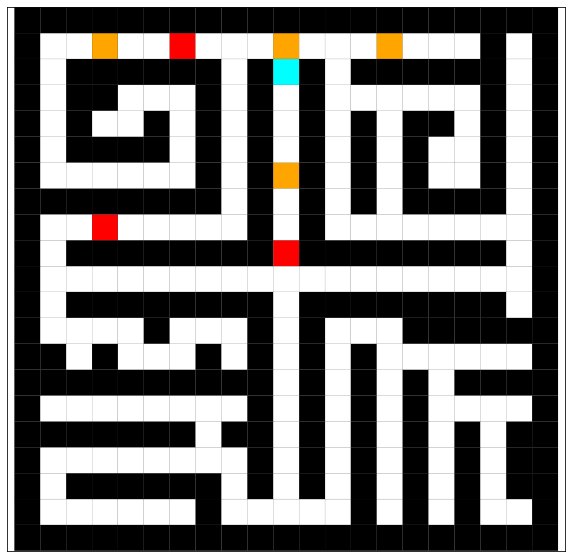

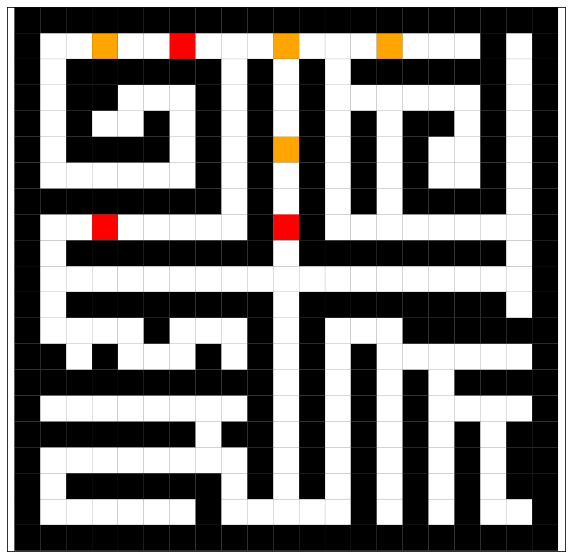

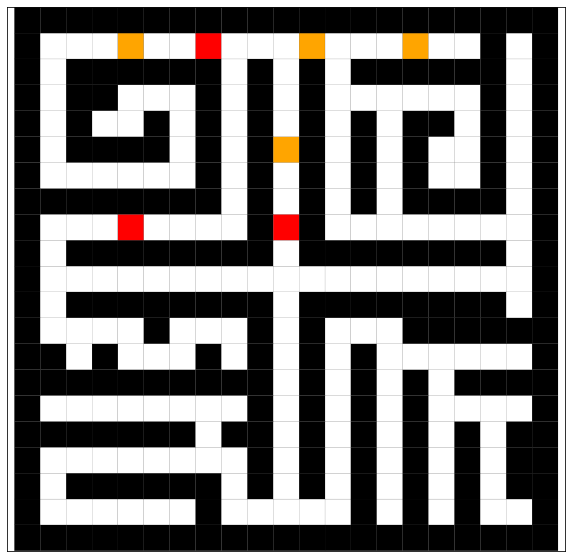

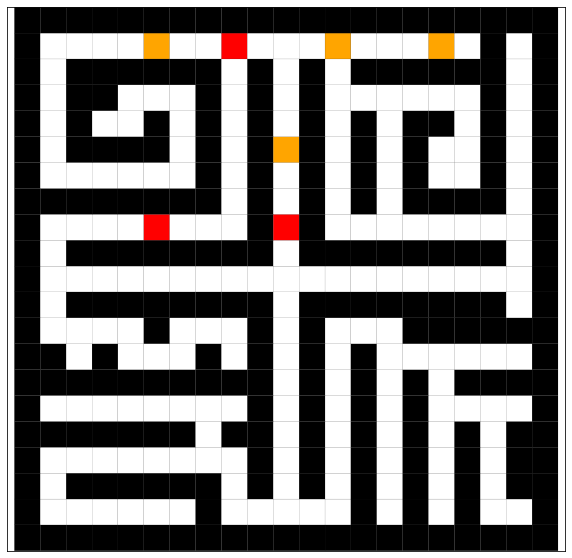

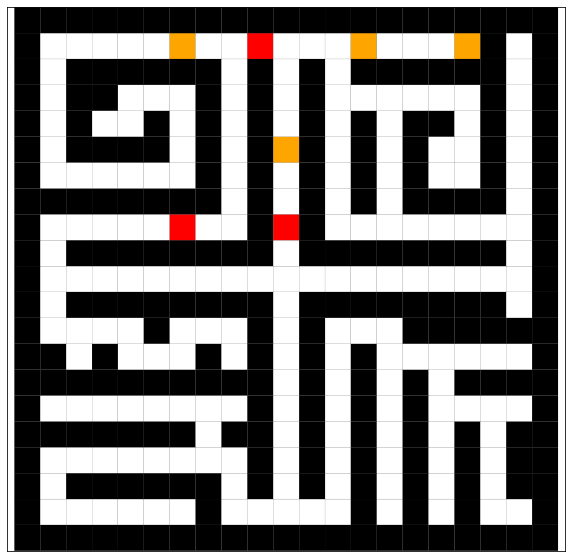

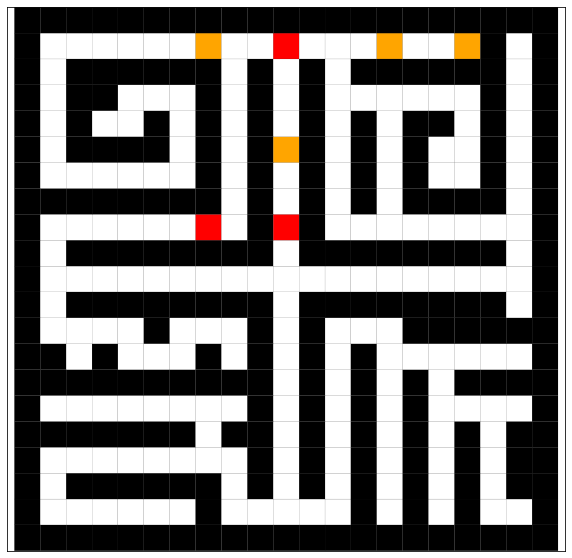

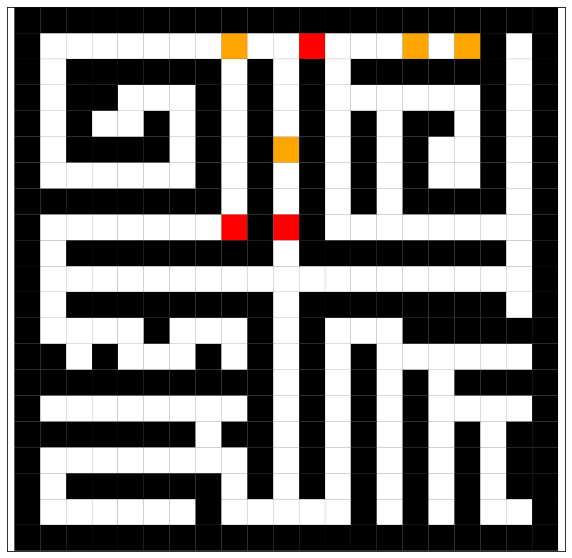

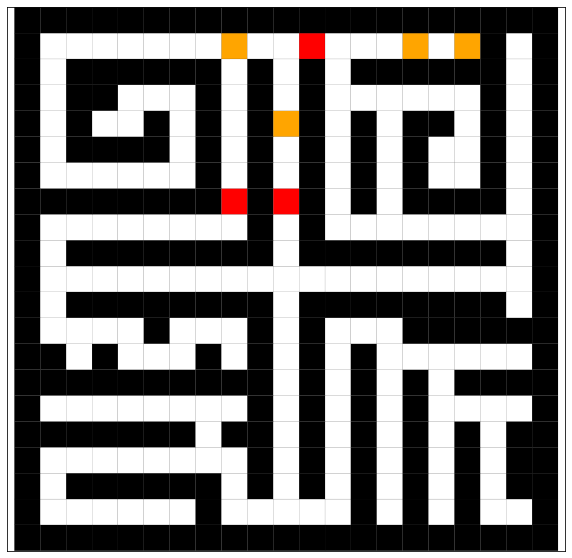

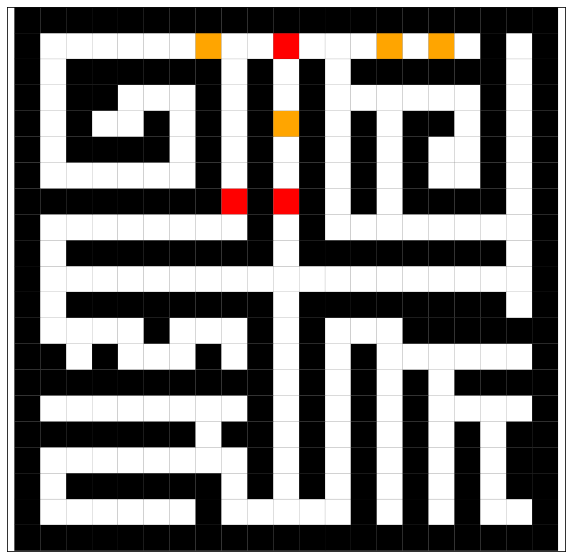

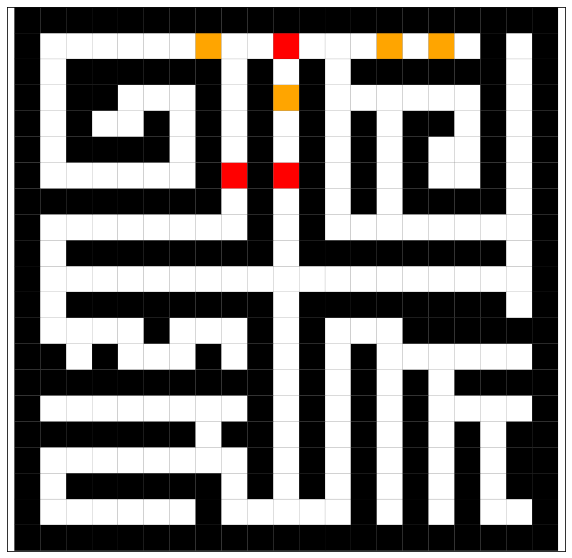

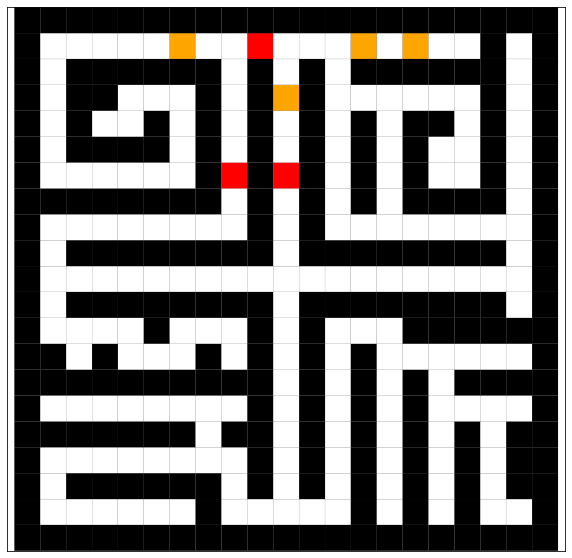

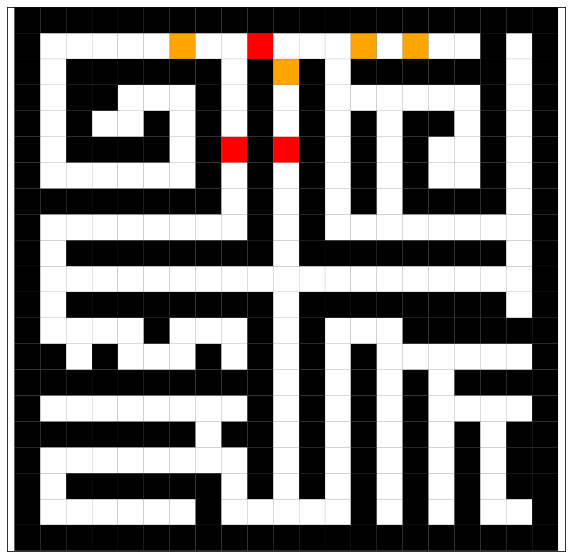

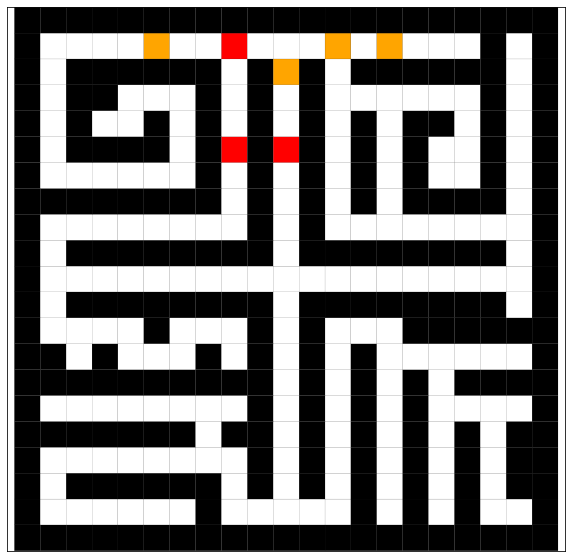

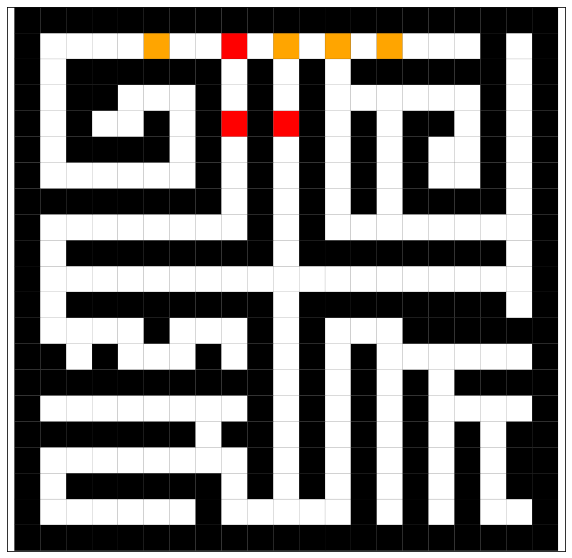

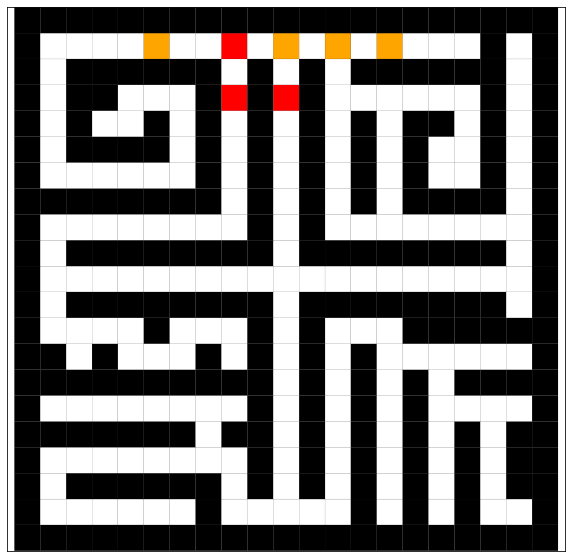

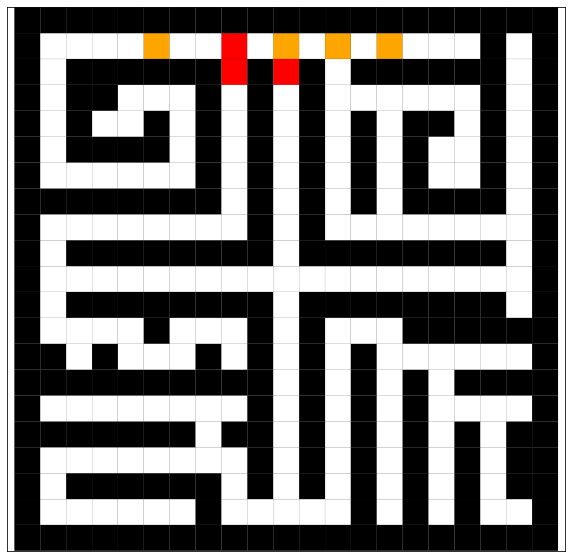

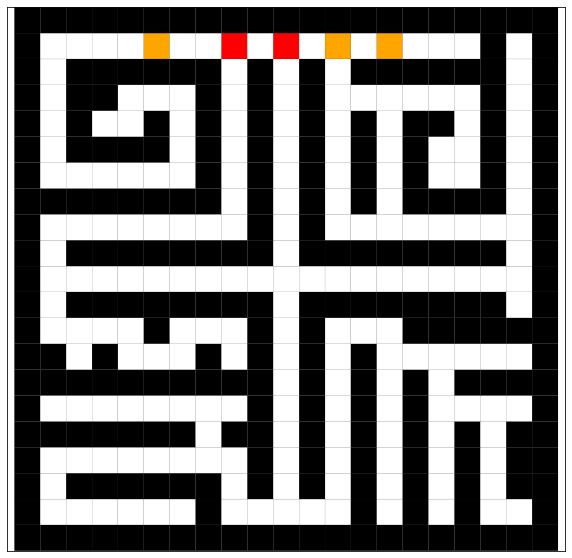

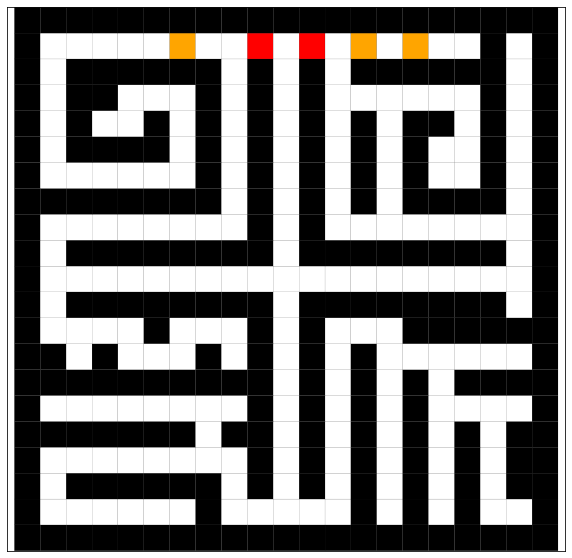

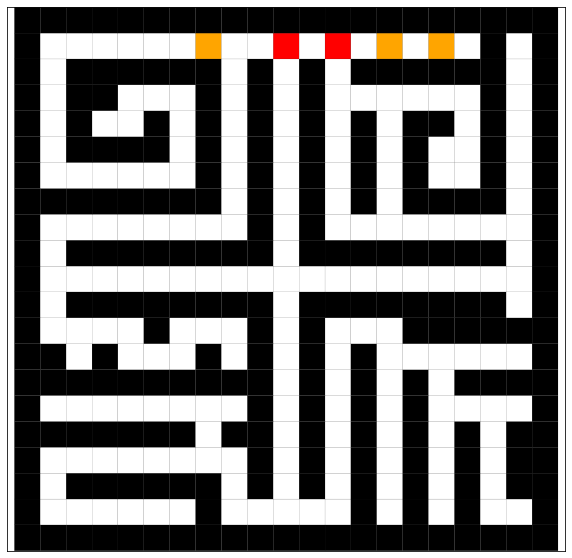

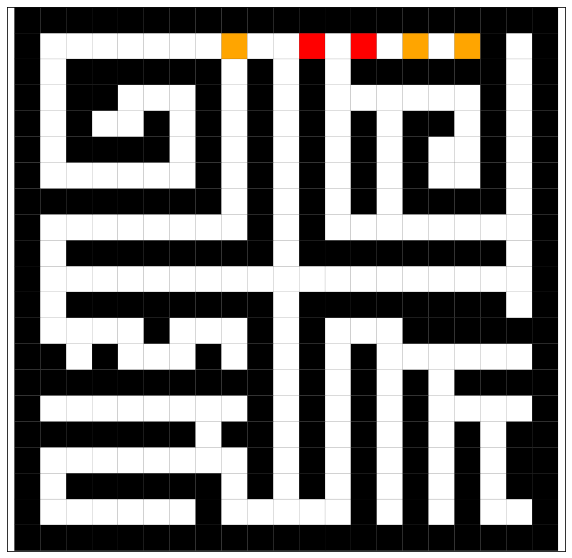

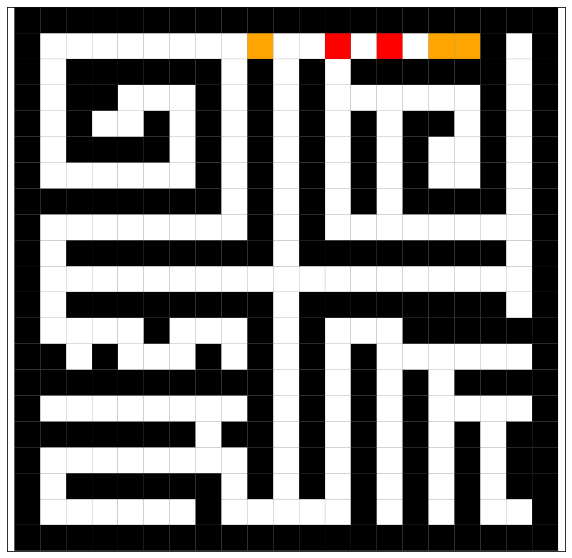

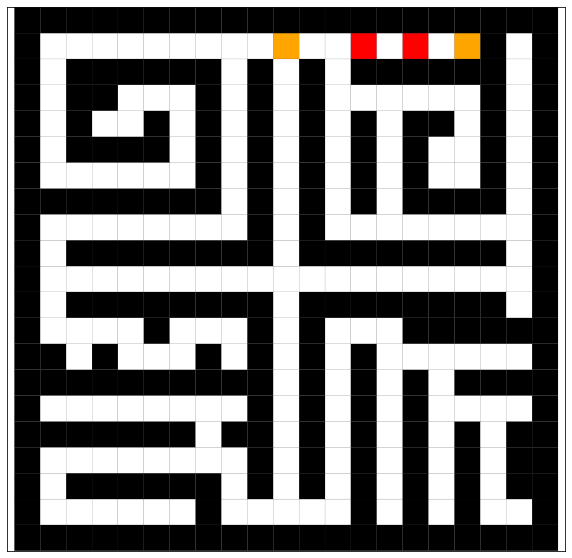

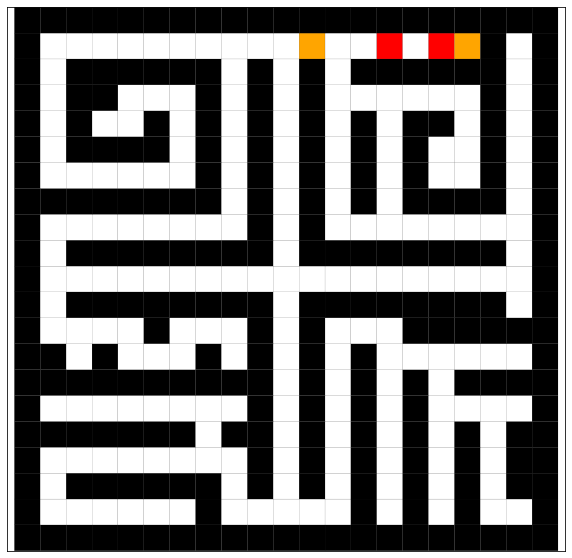

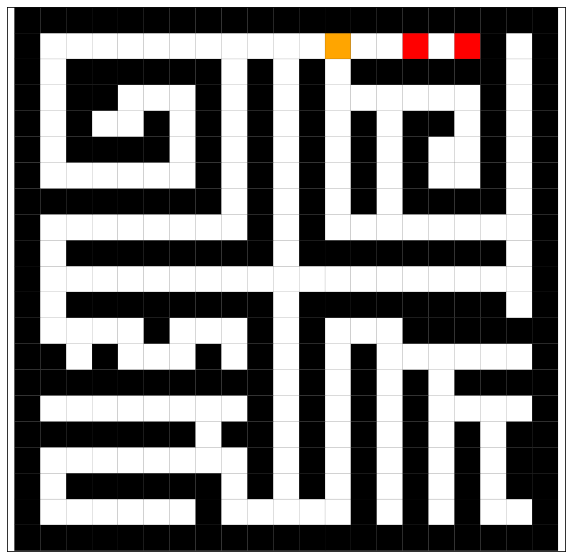

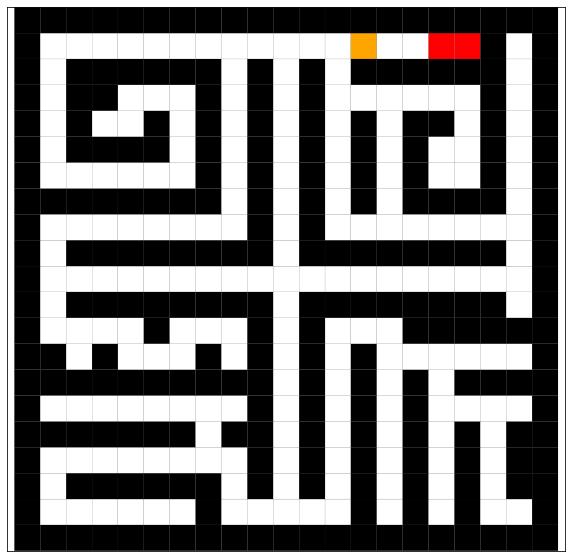

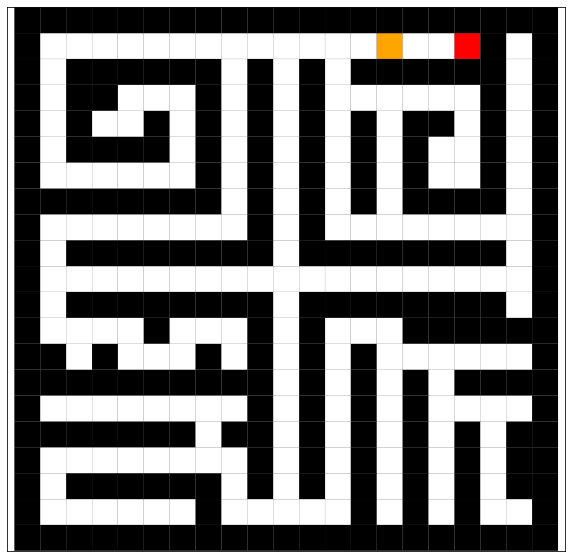

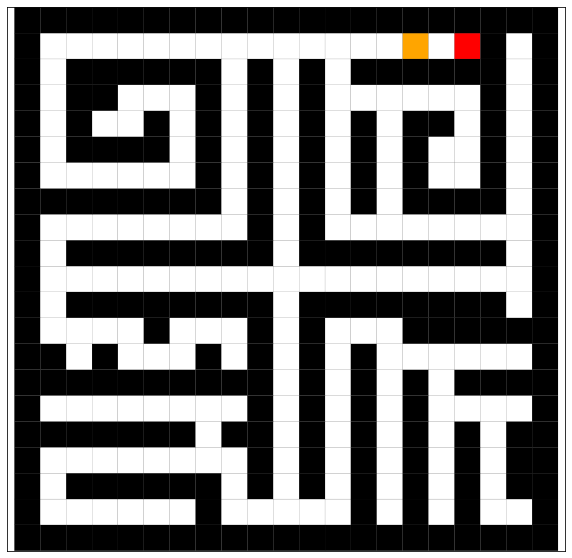

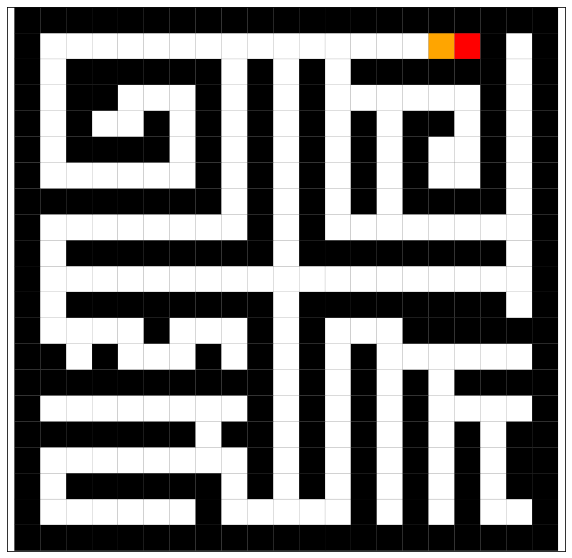

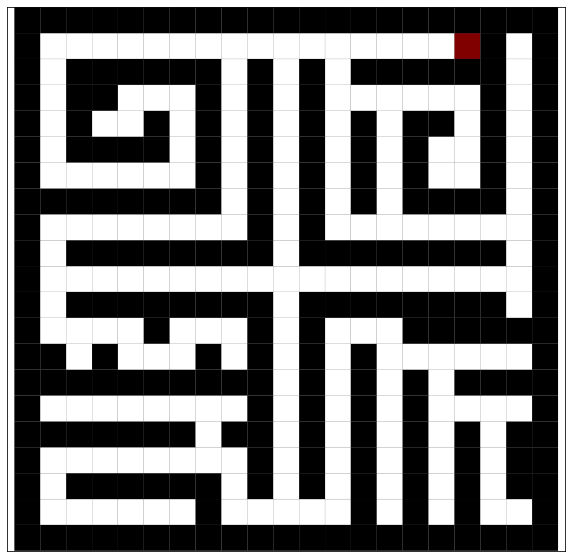

In [41]:
steps=heuristic_converge(maze1)
print(steps)
print(len(steps))
grid_output=take_input_and_generate_grid("input1.txt")
dim_output1=len(grid_output)
dim_output2=len(grid_output[0])

for i in steps:
    newGrid = copy.deepcopy(move_one_step_in_a_direction(grid_output,i))
    grid_output = copy.deepcopy(newGrid)
    maze2 = generate_maze(dim_output1,dim_output2)
    maze2.grid=newGrid
    maze2.visualize_grid()

**Other approaches not converging to a single value properly. Sometimes it does, Sometimes it doesnt, best value from this is 215**

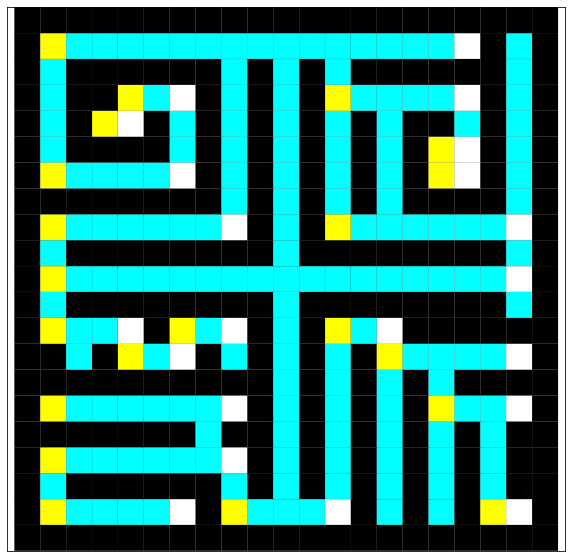

1


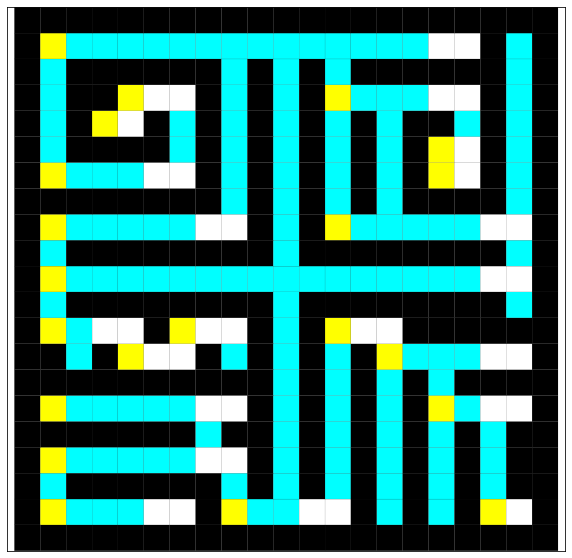

2


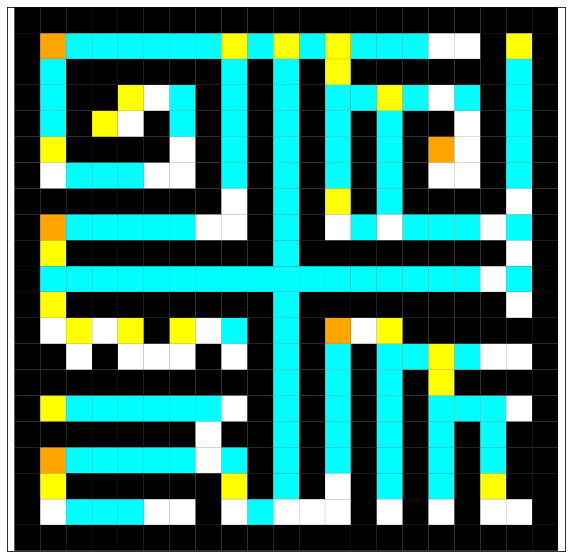

3


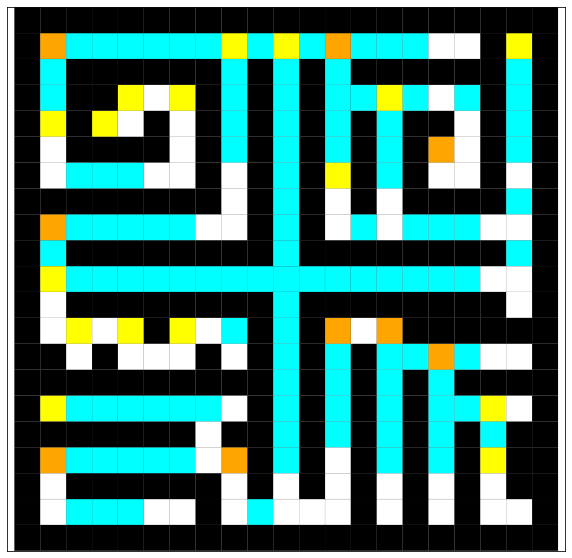

4


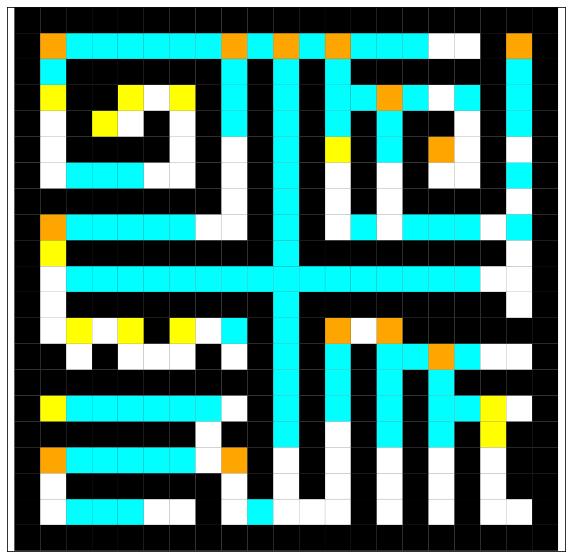

5


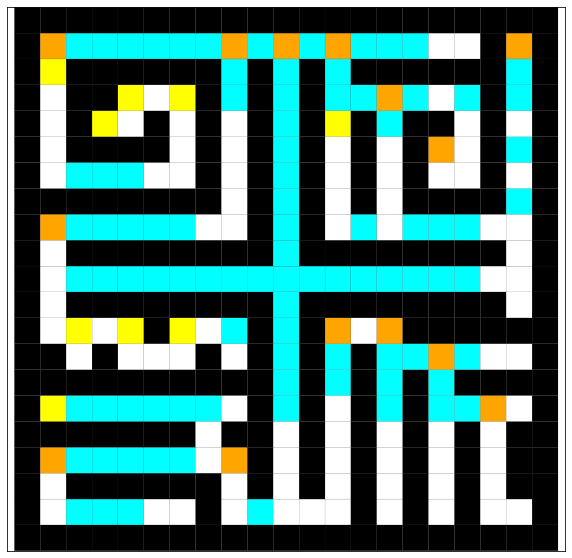

6


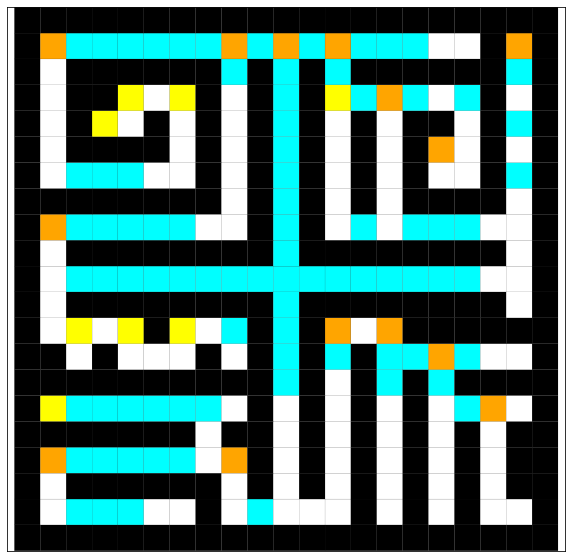

7


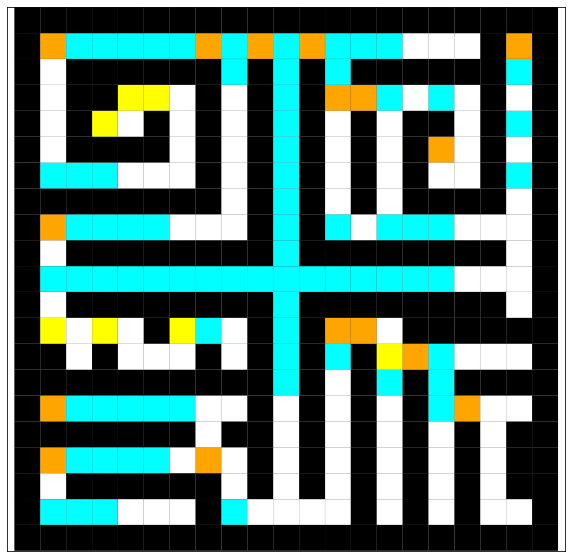

8


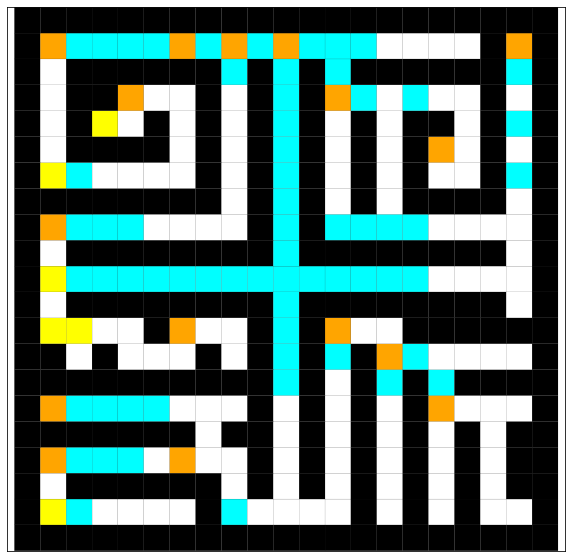

9


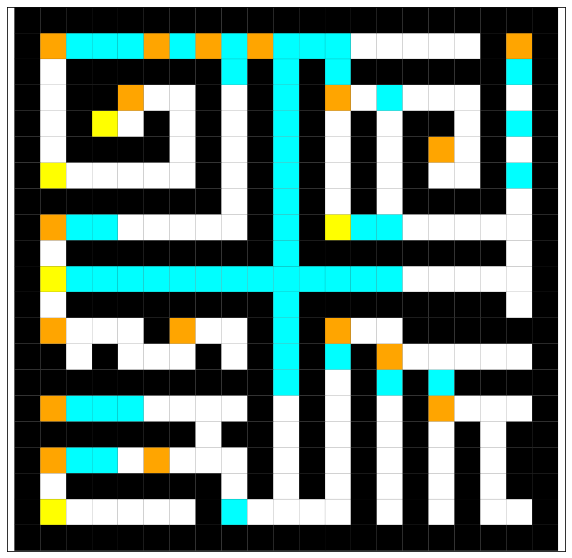

10


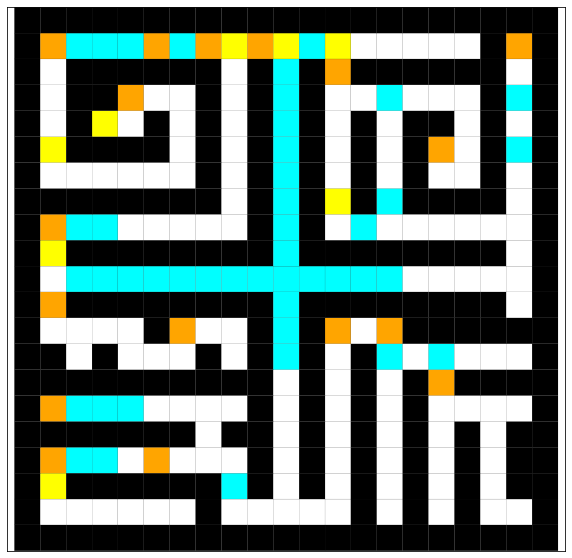

11


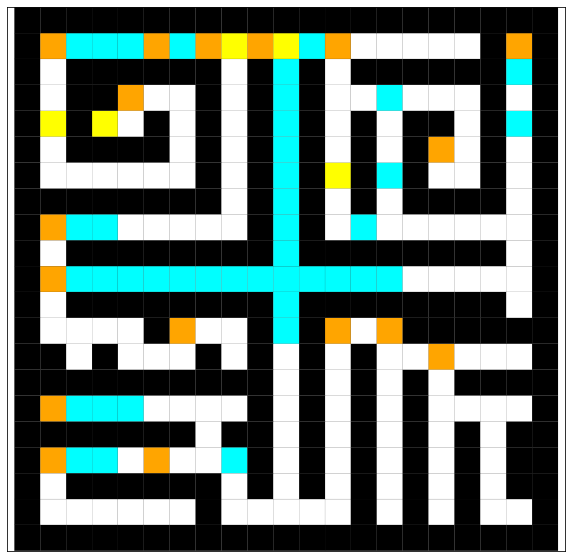

12


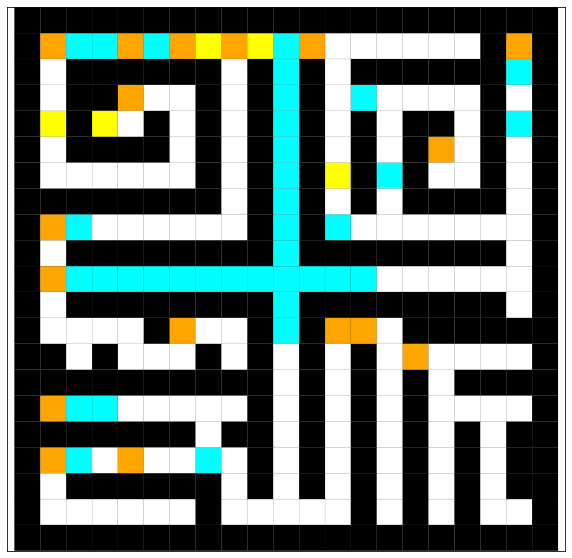

13


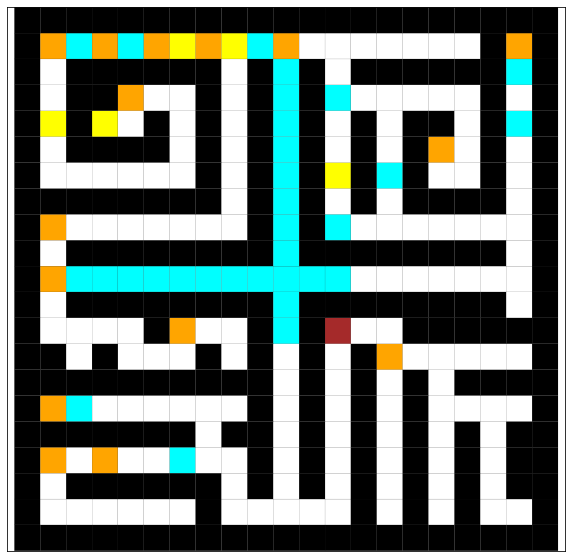

14


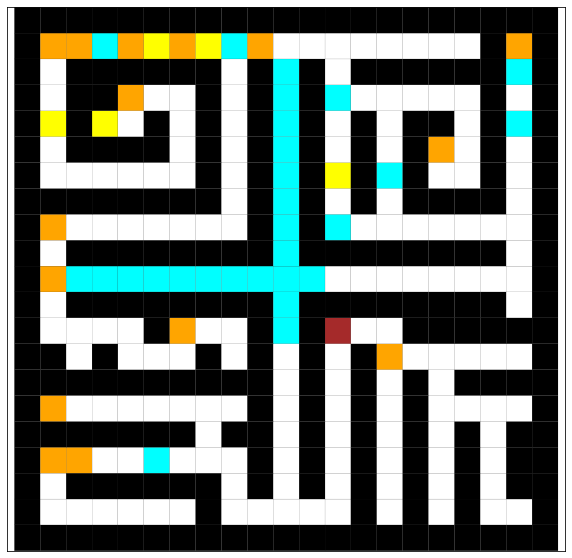

15


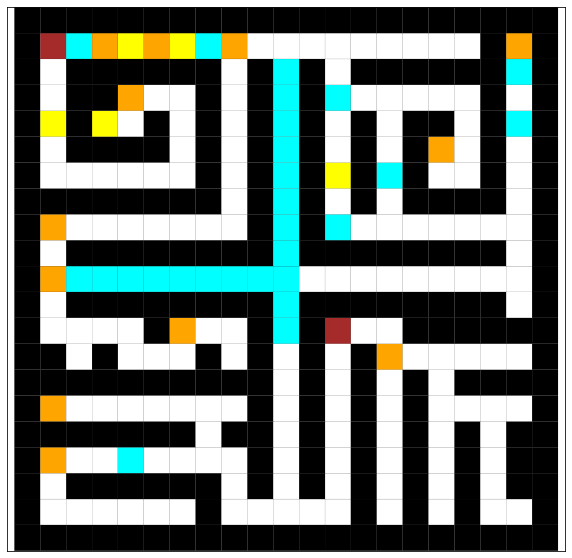

16


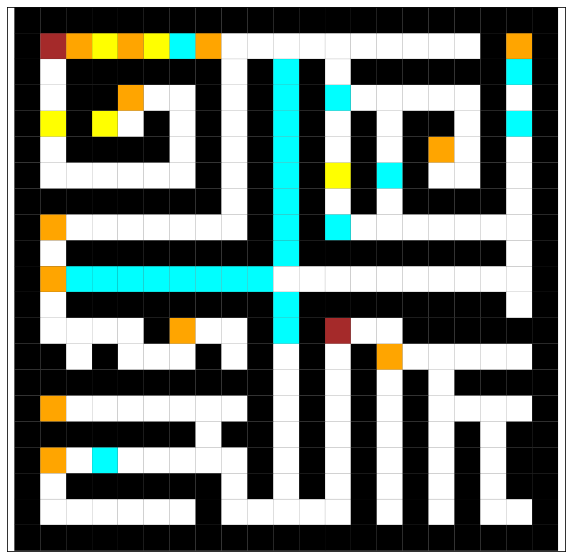

17


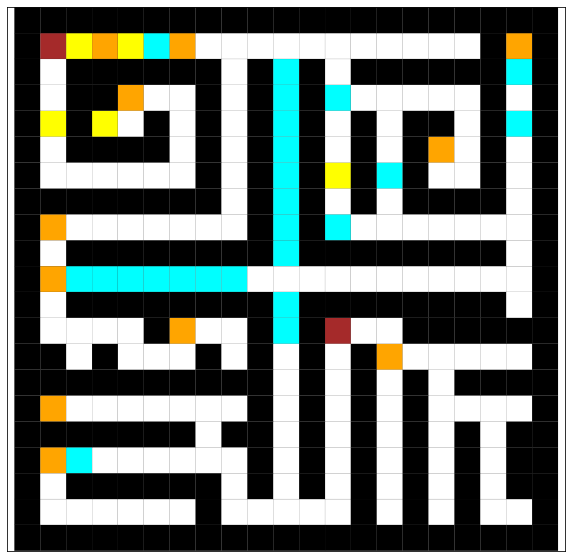

18


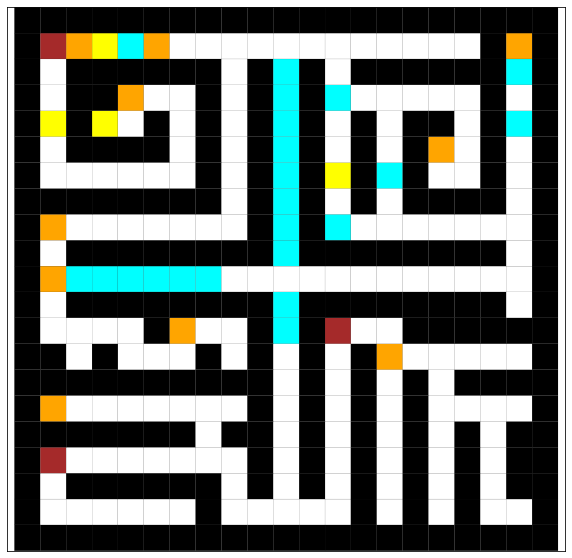

19


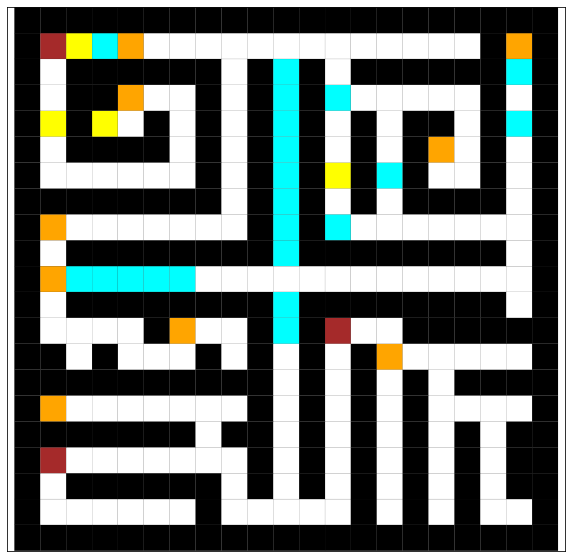

20


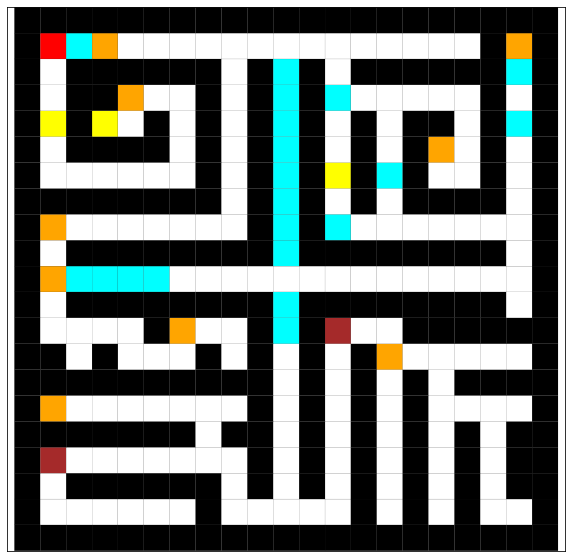

21


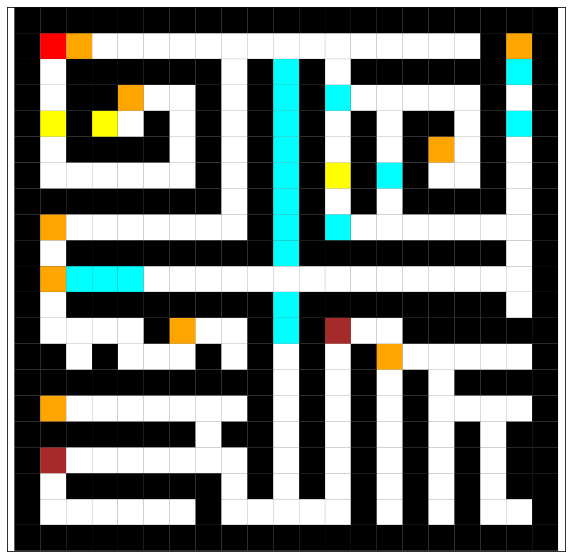

22


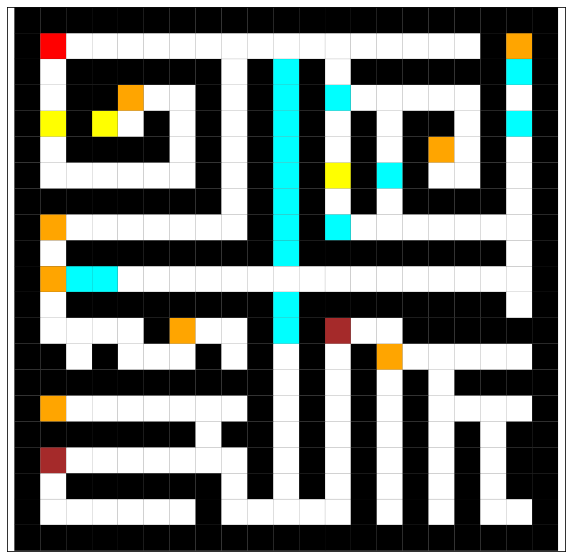

23


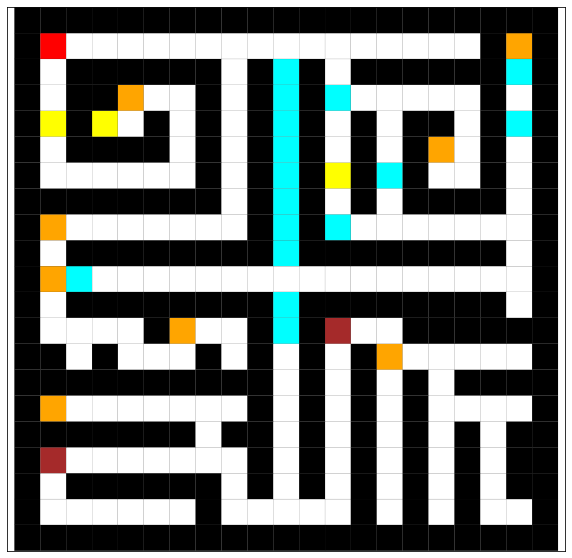

24


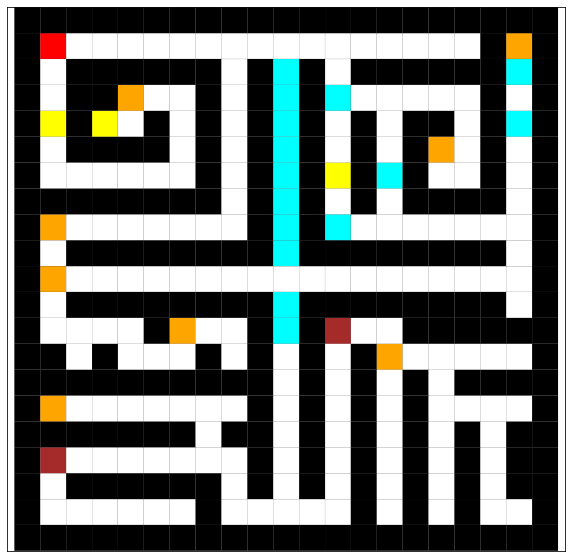

25


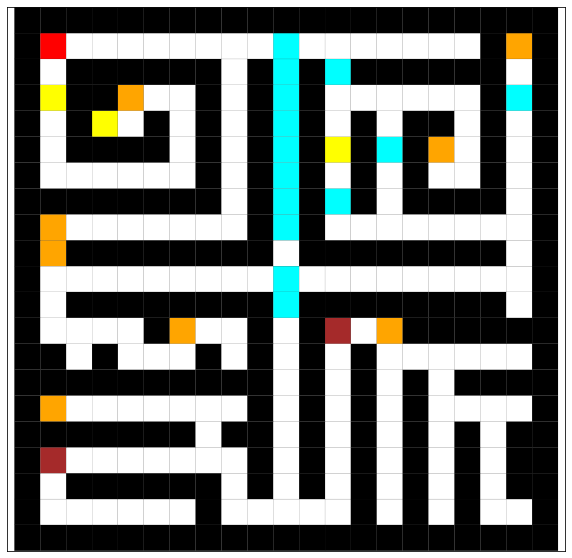

26


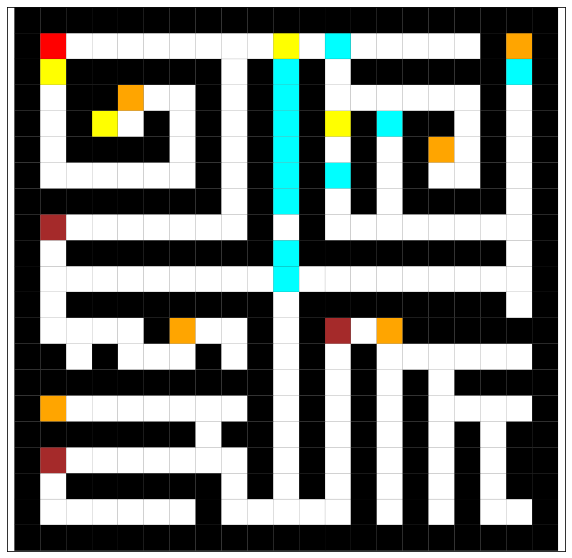

27


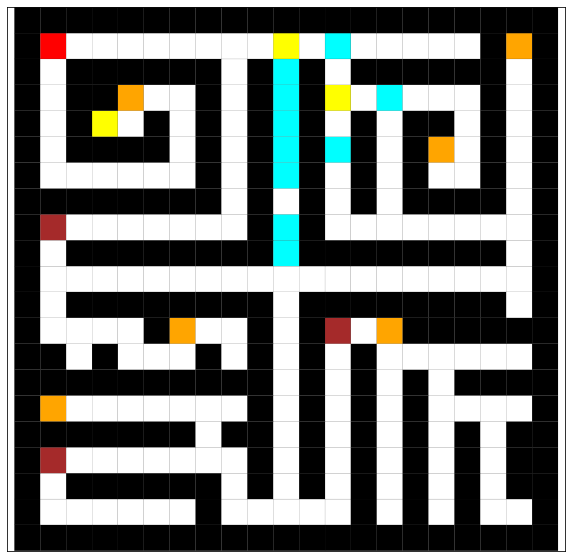

28


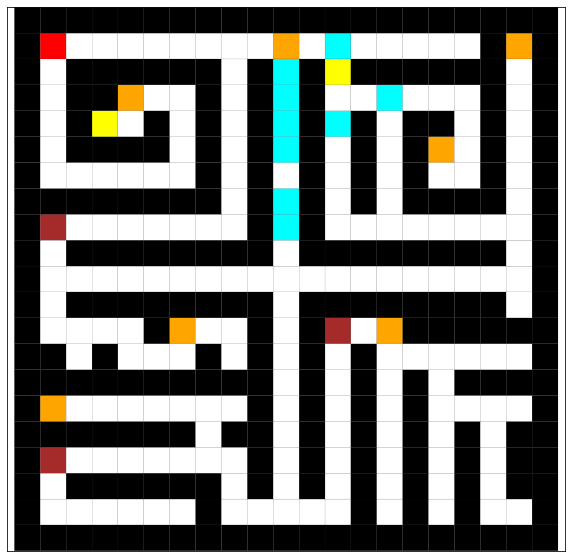

29


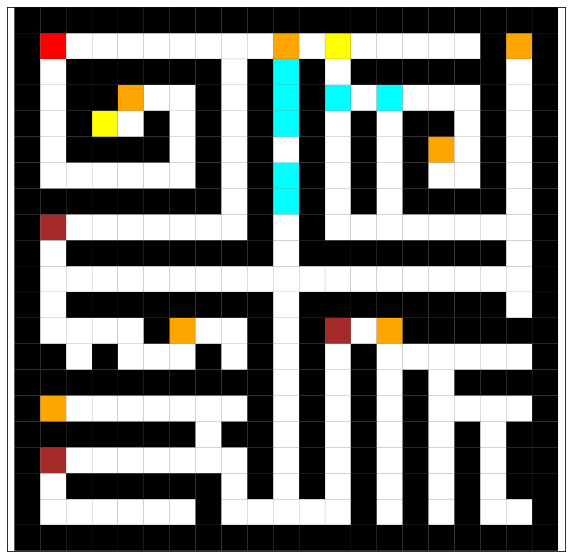

30


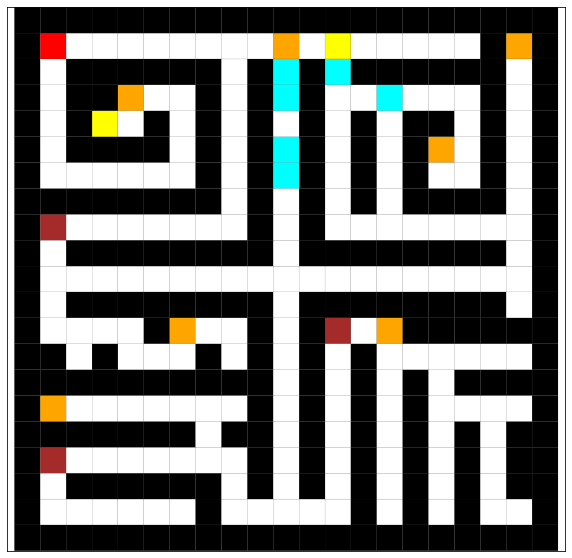

31


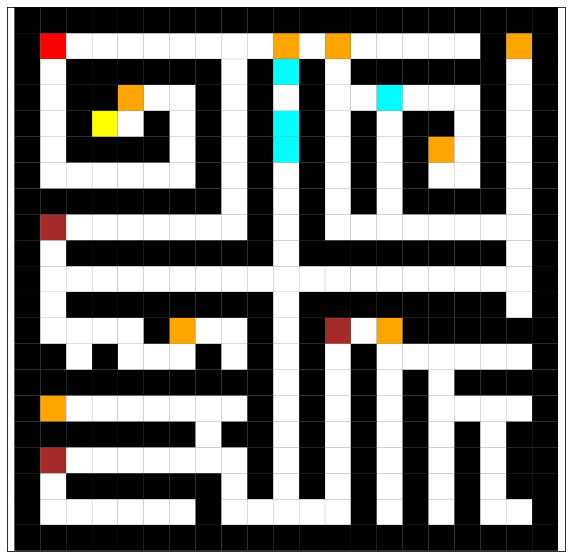

32


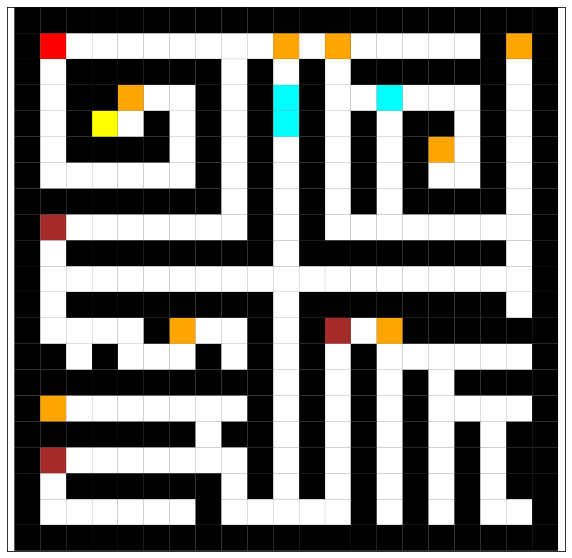

33


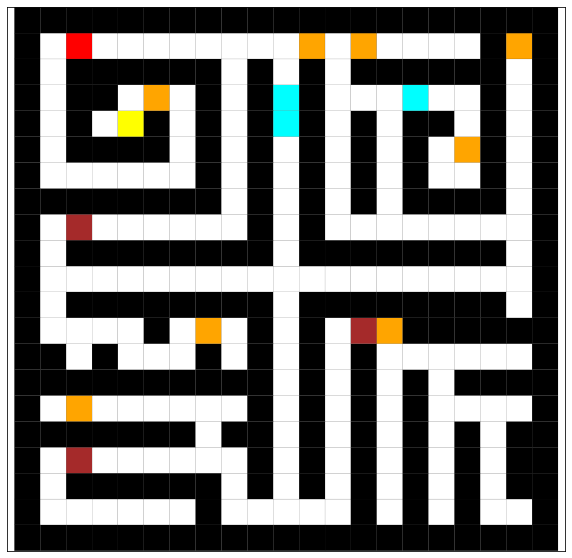

34


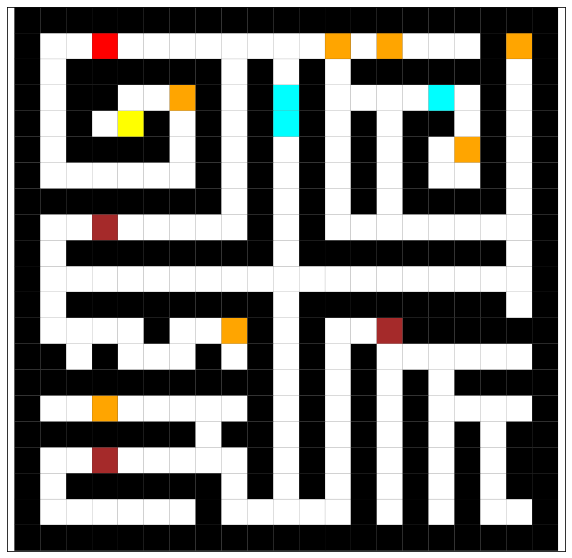

35


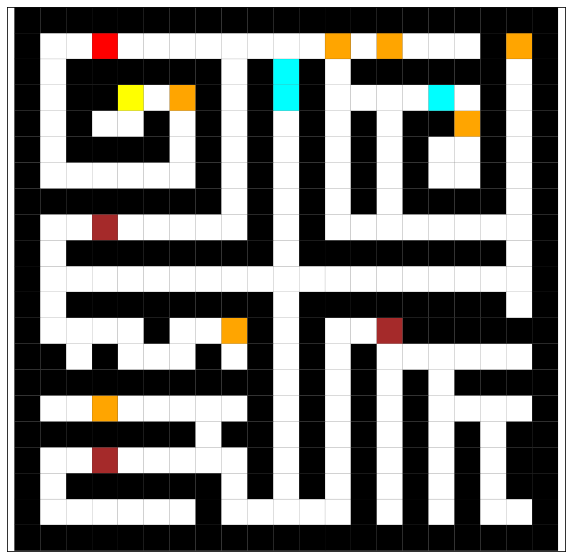

36


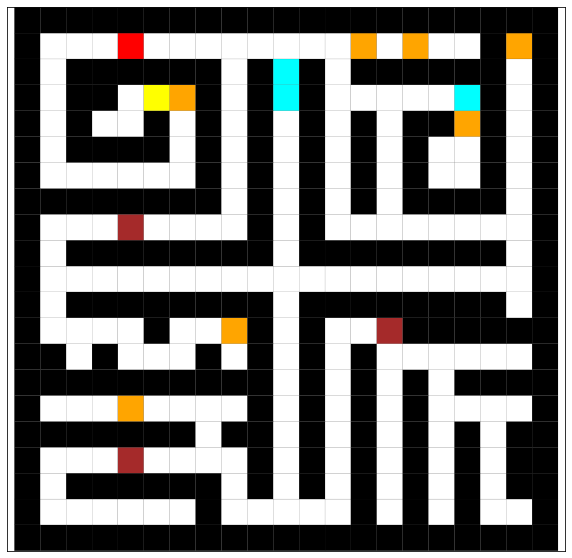

37


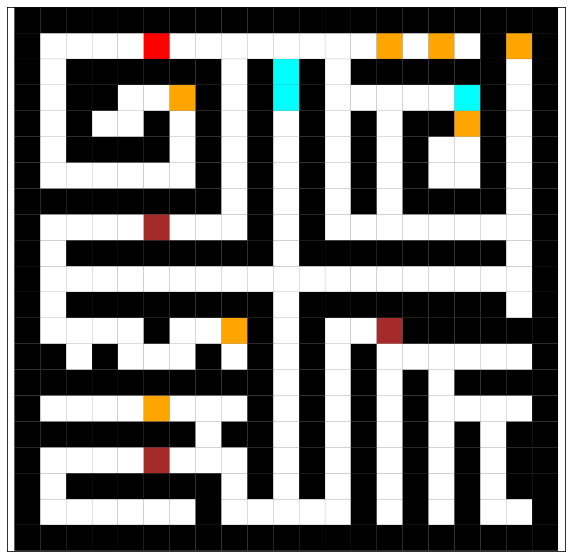

38


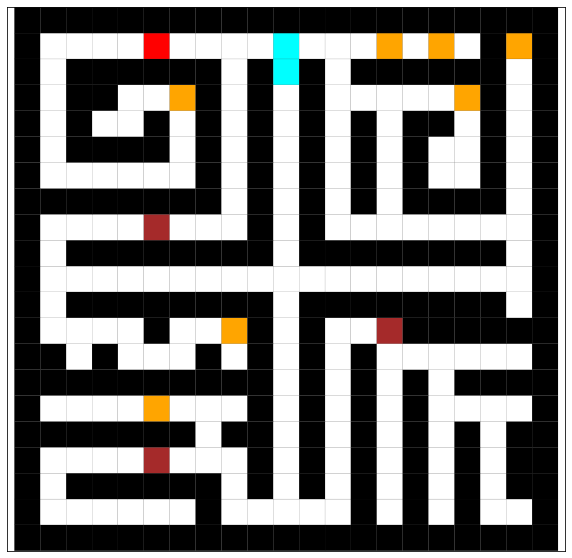

39


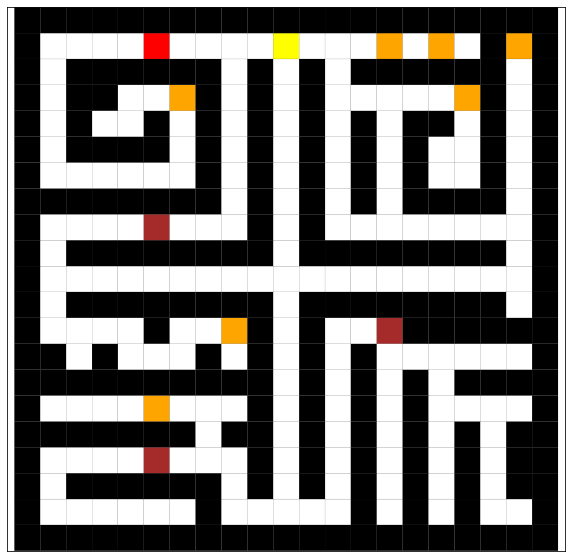

40


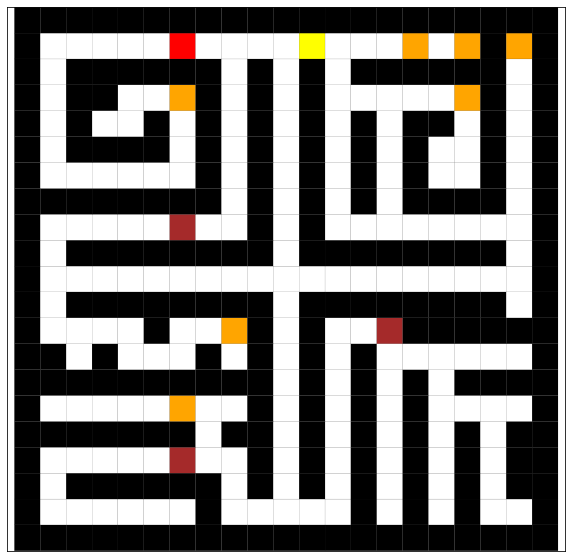

41


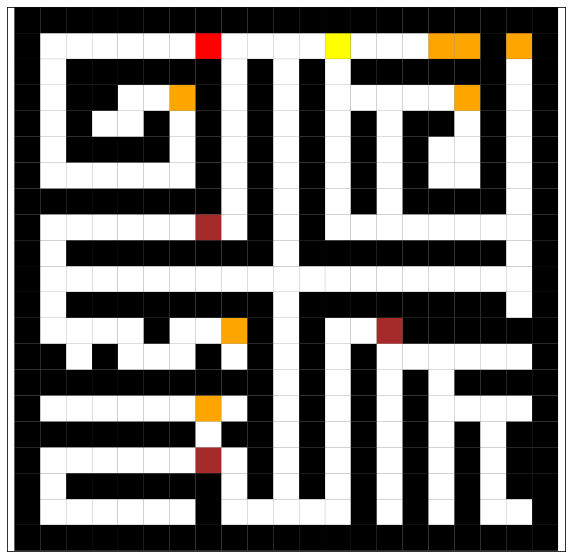

42


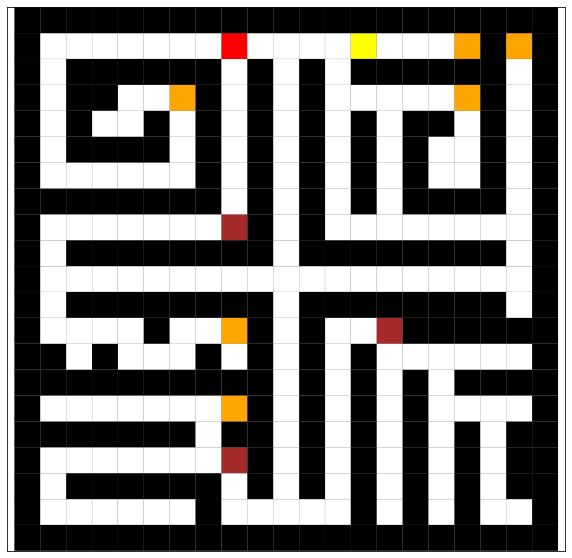

43


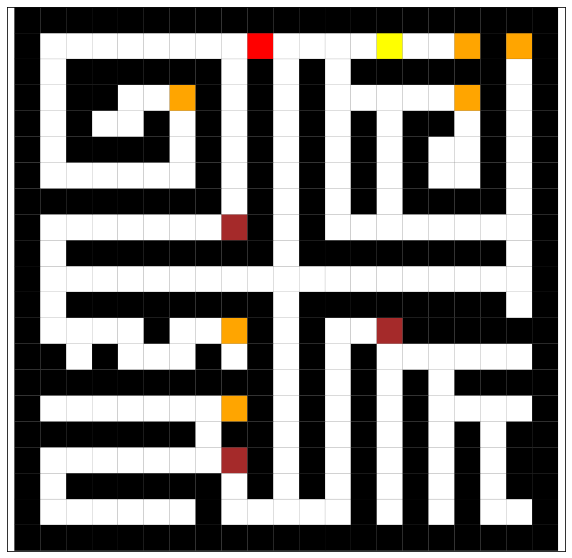

44


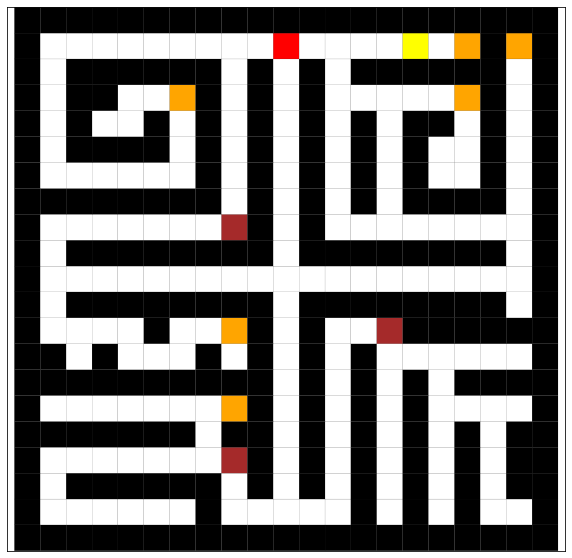

45


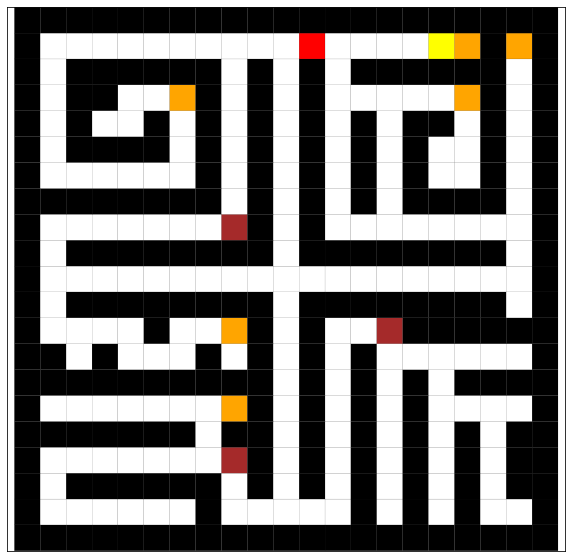

46


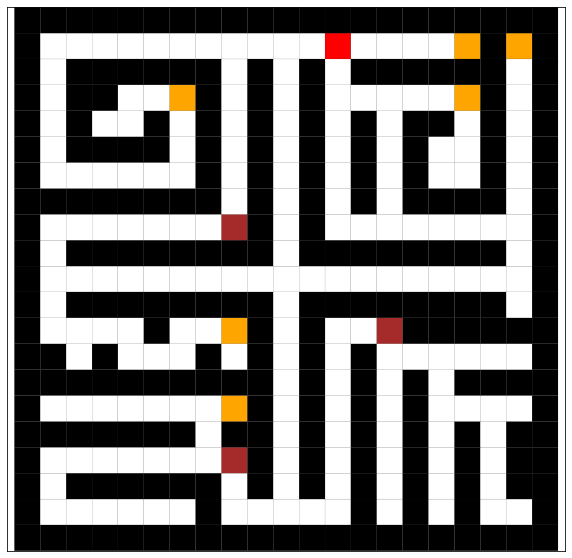

47


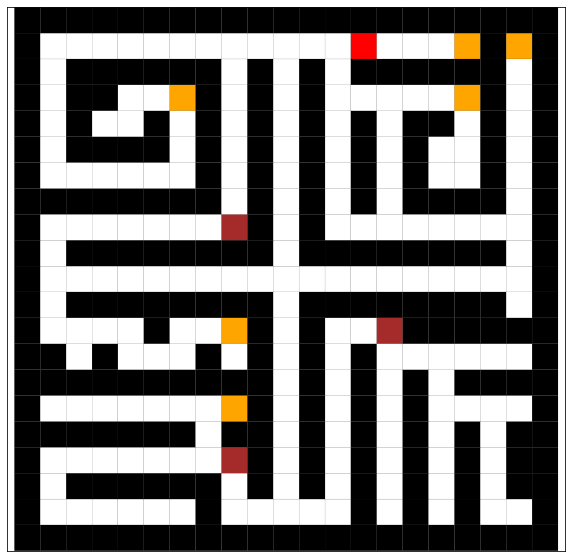

48


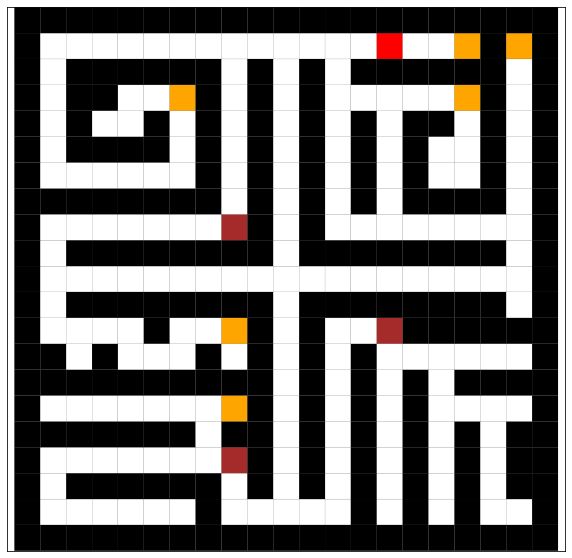

49


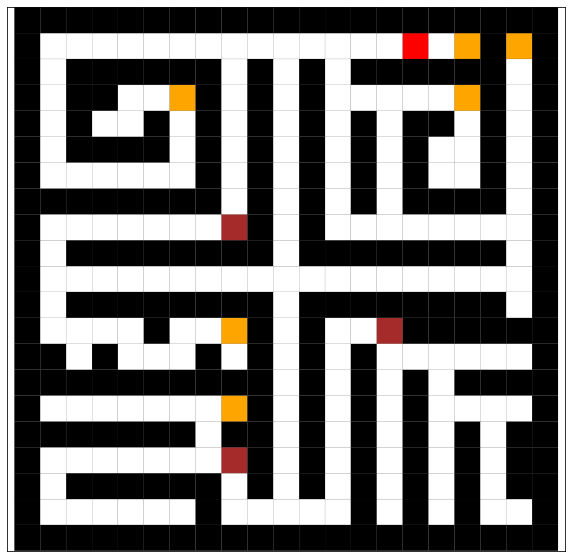

50


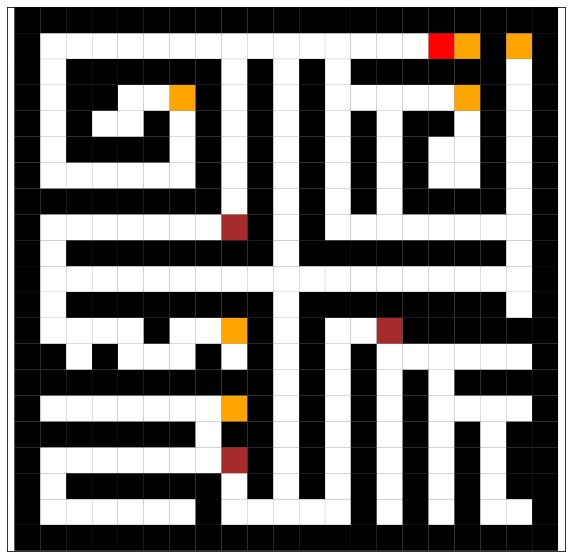

51


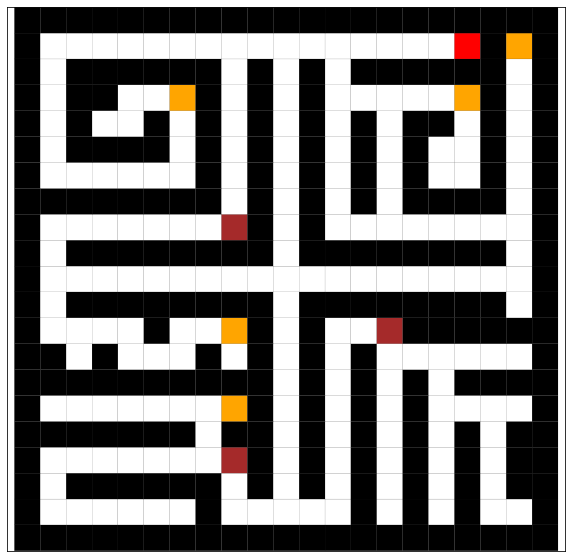

52


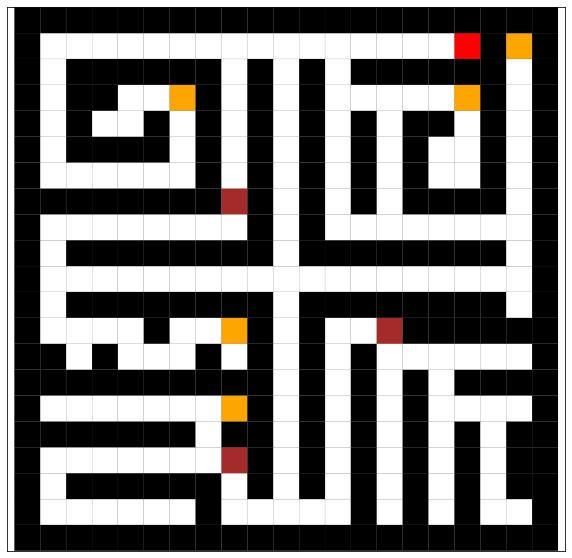

53


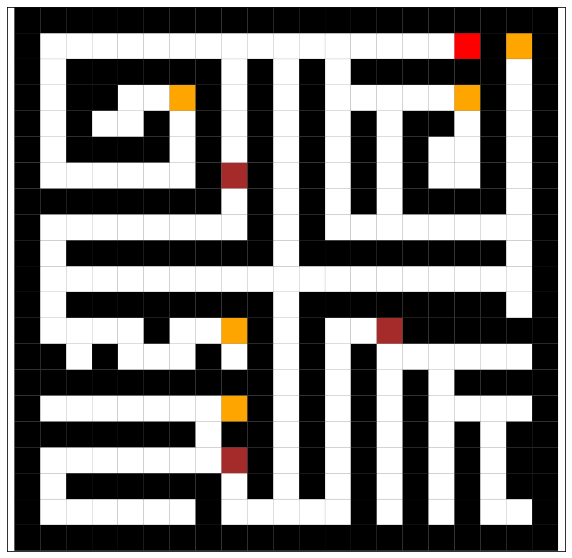

54


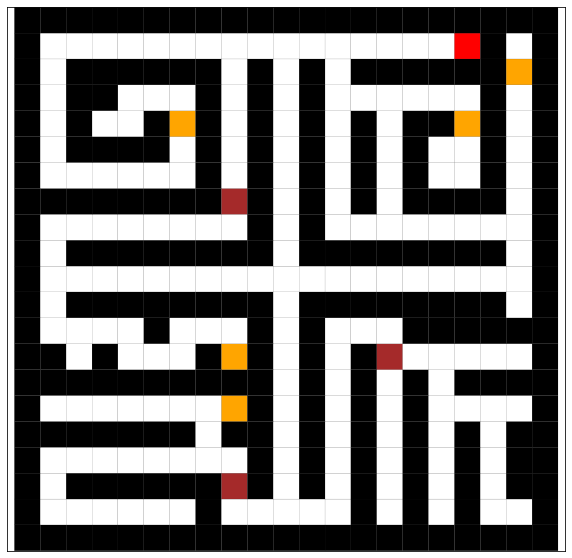

55


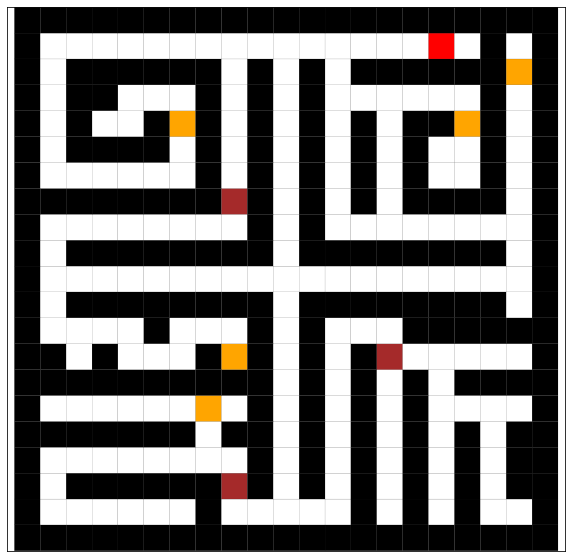

56


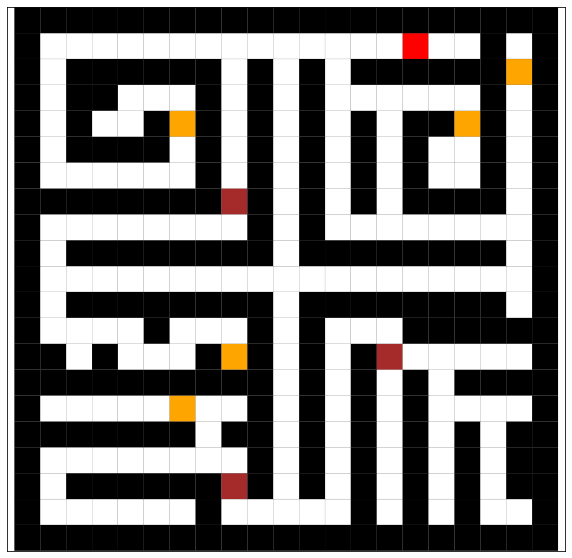

57


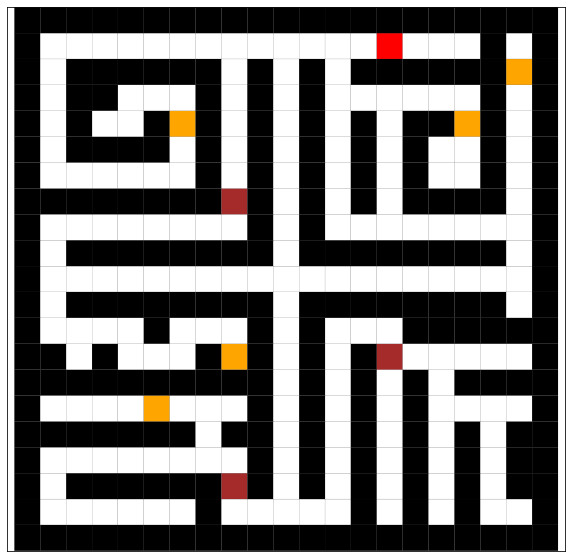

58


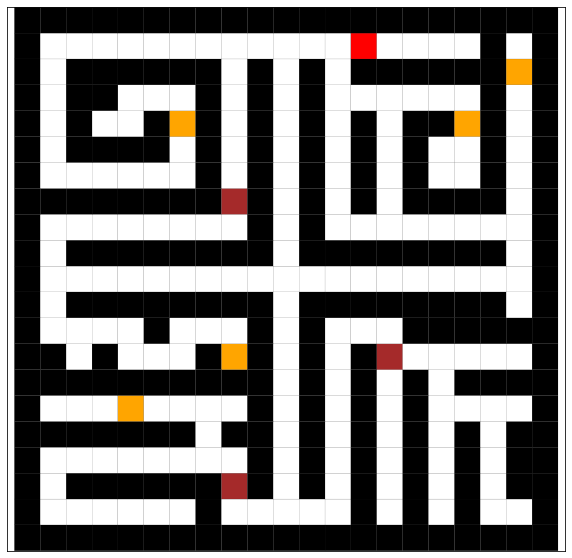

59


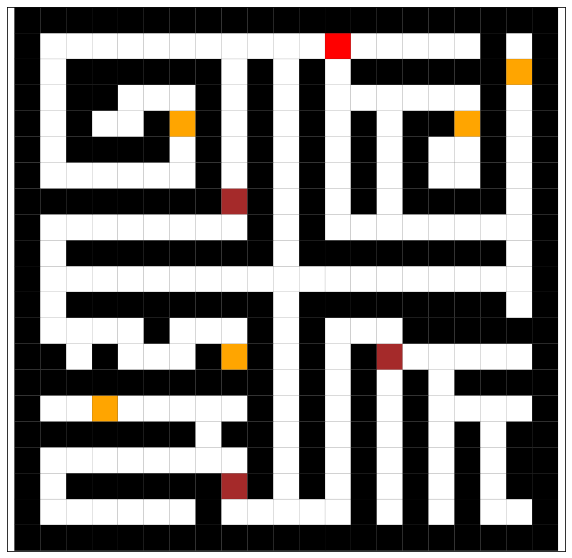

60


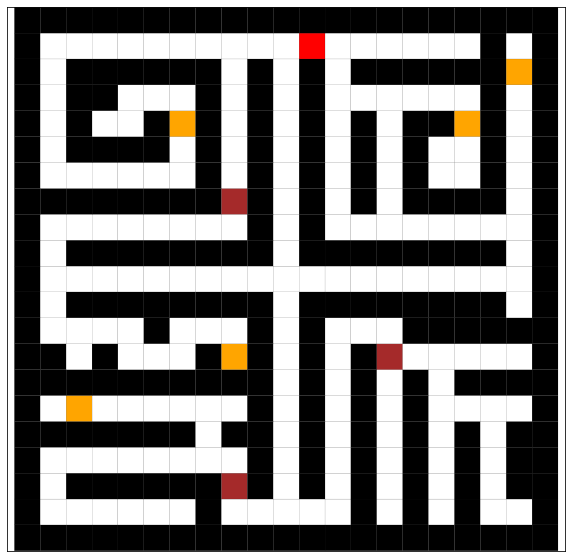

61


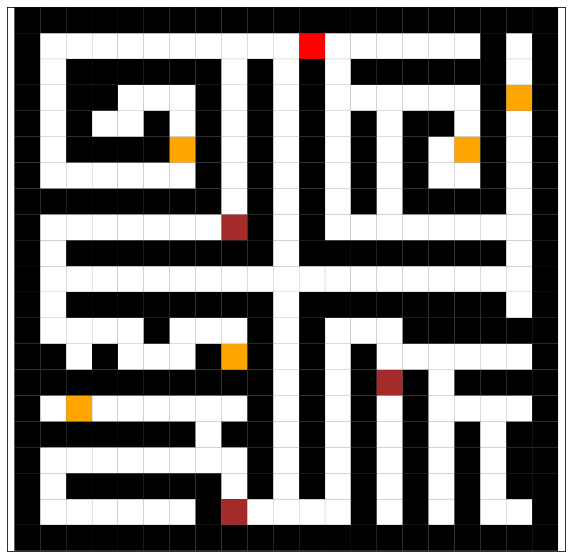

62


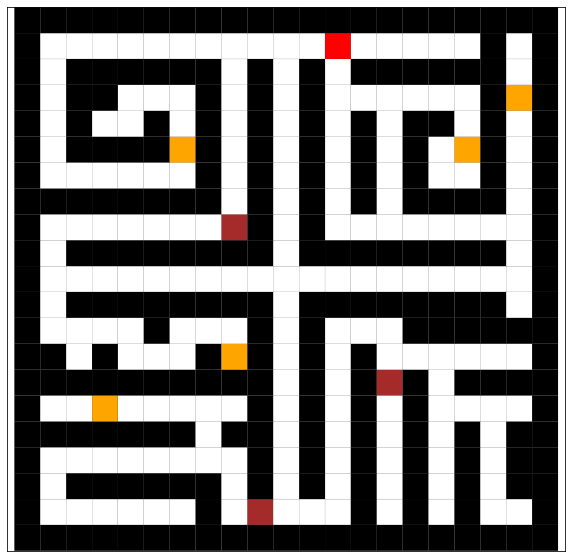

63


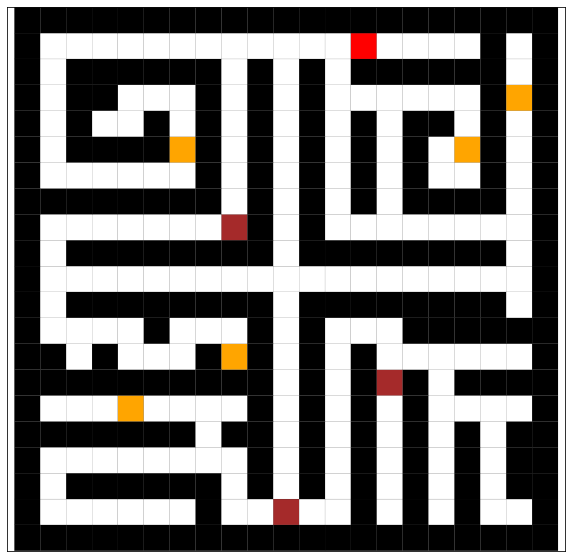

64


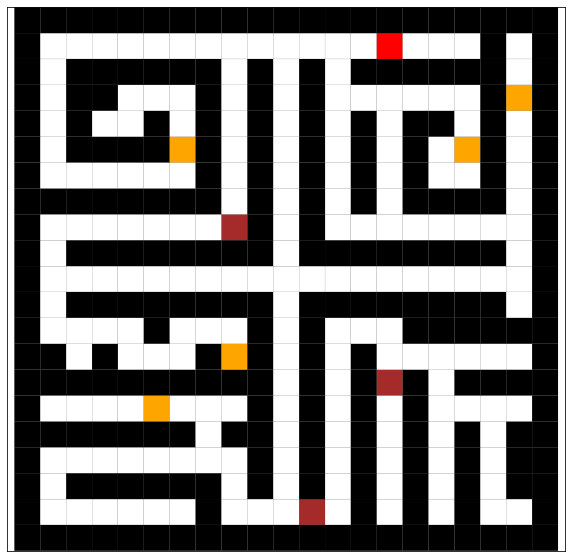

65


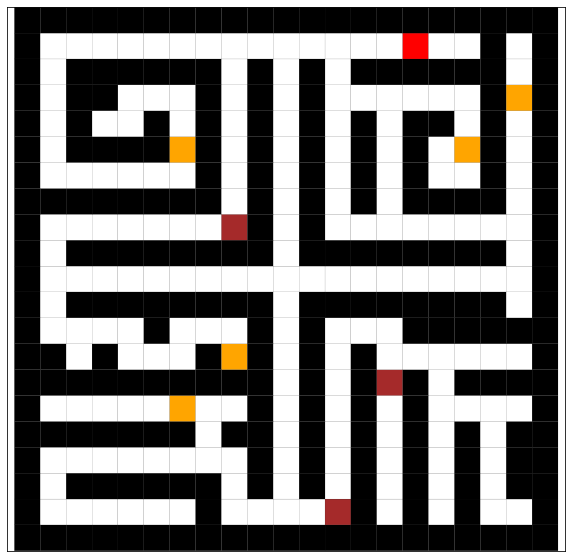

66


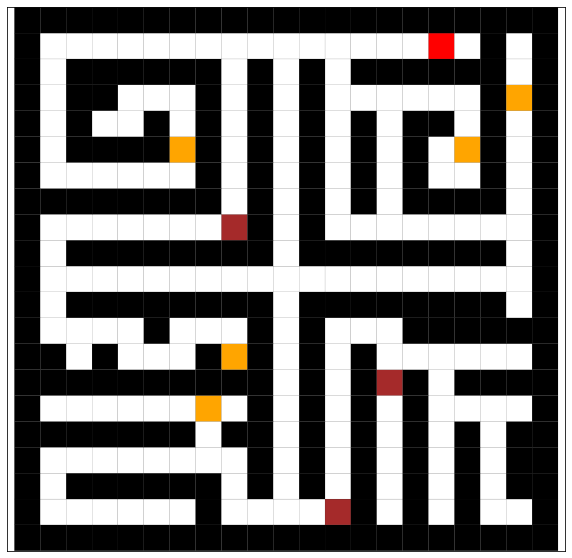

67


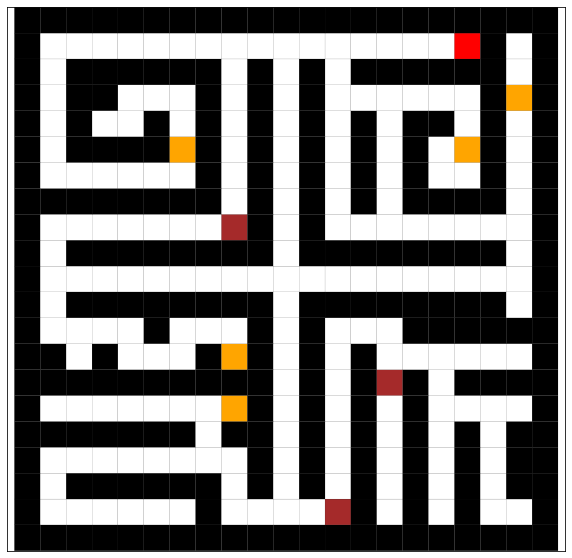

68


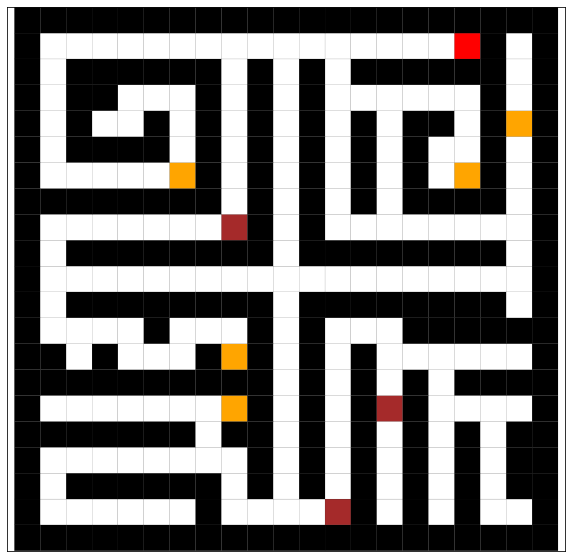

69


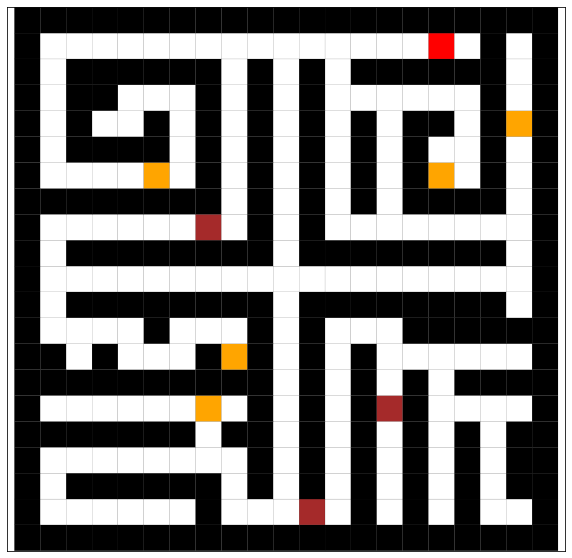

70


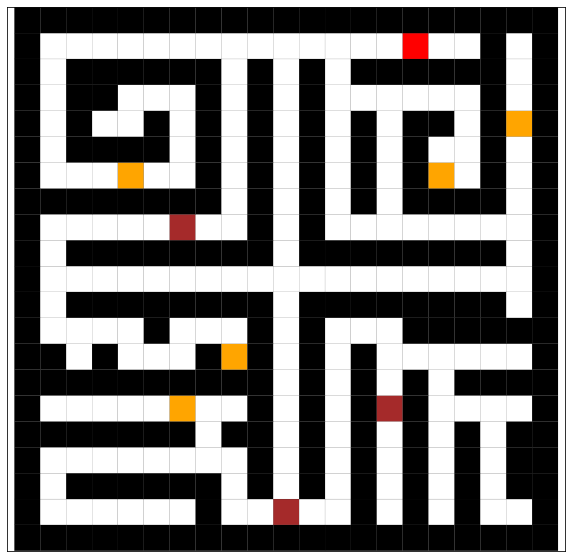

71


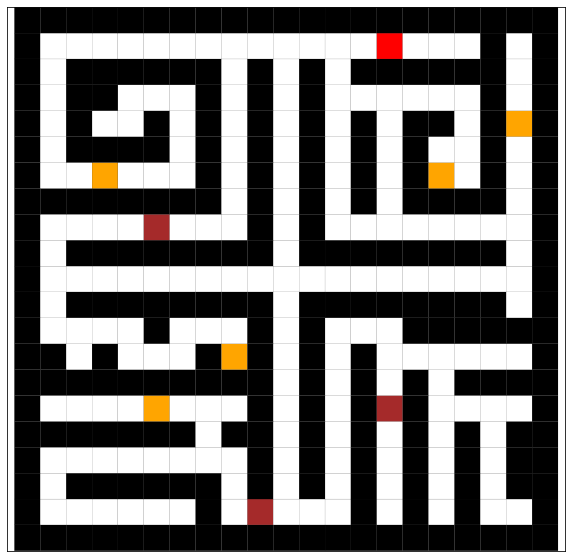

72


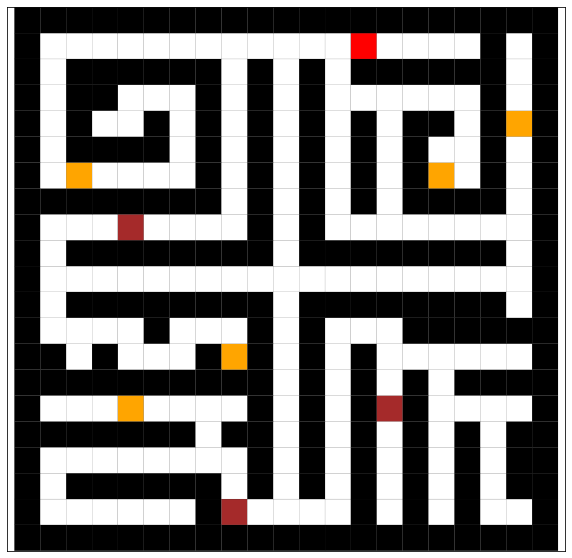

73


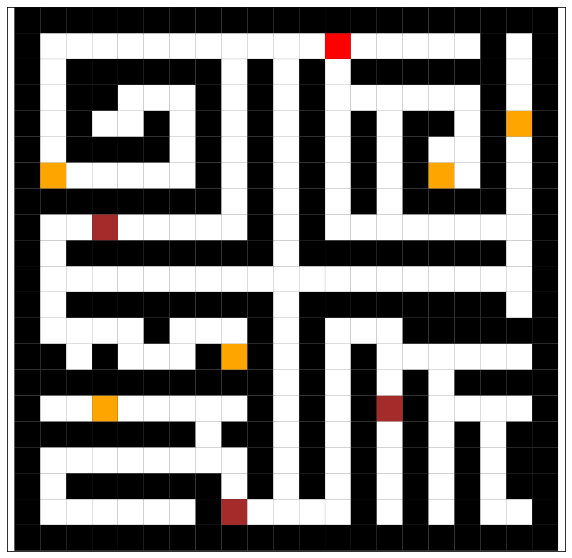

74


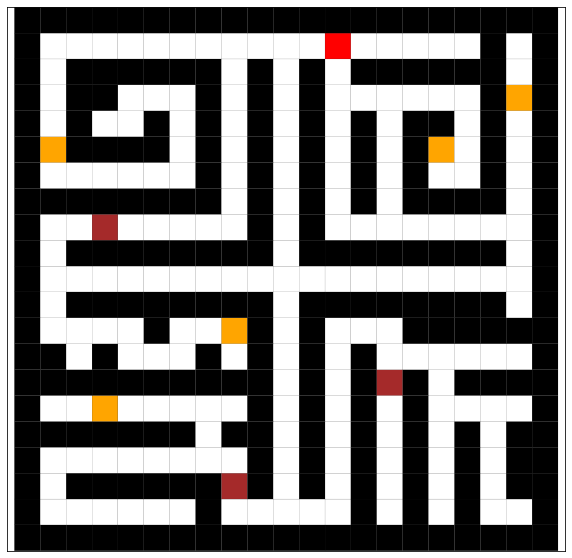

75


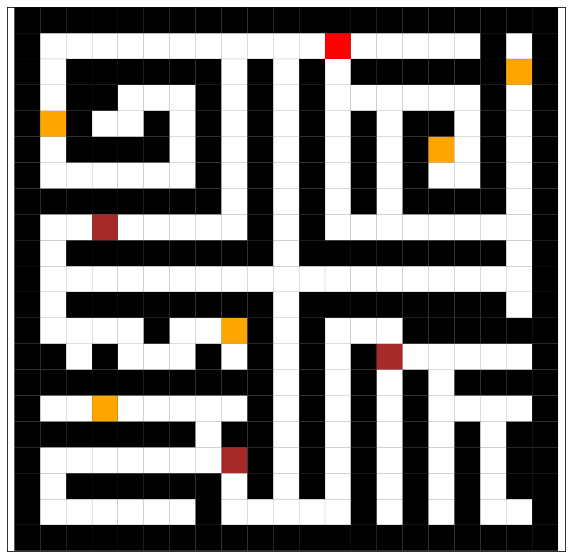

76


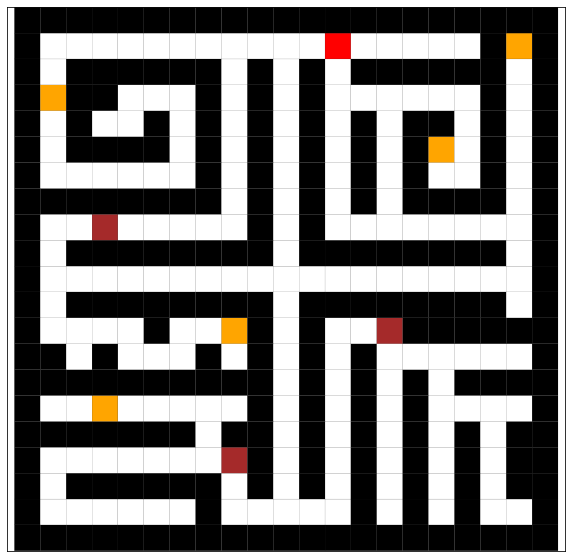

77


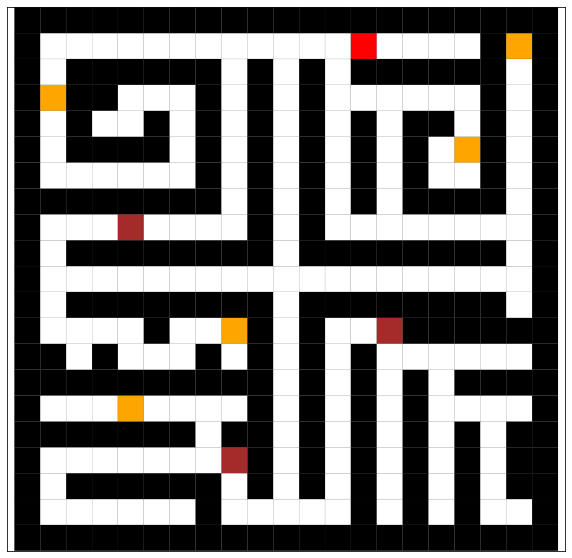

78


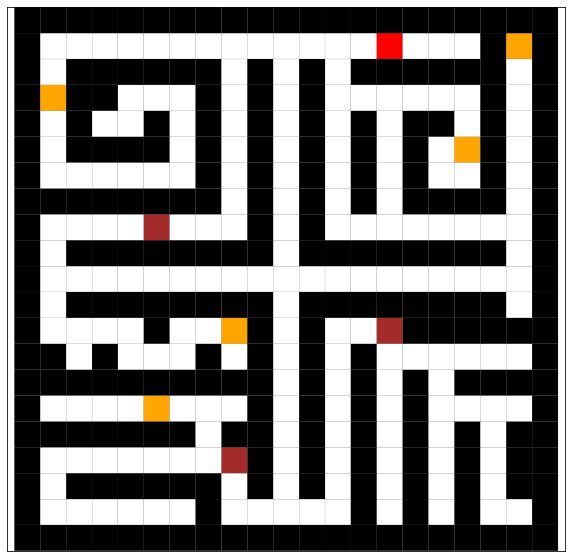

79


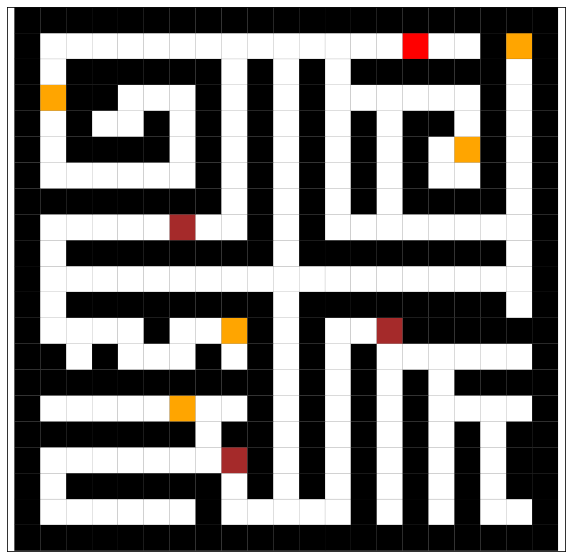

80


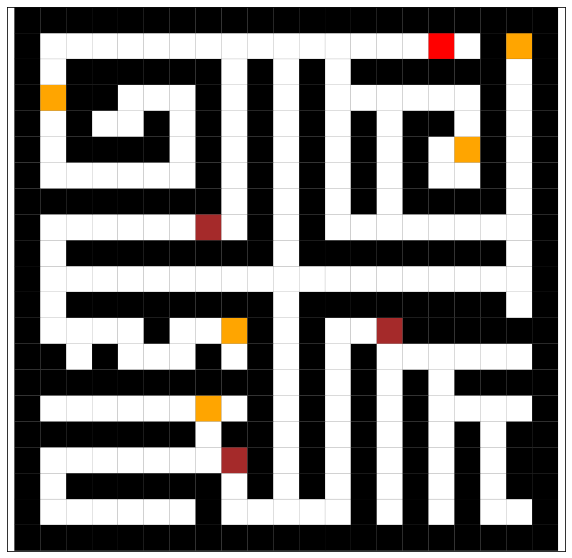

81


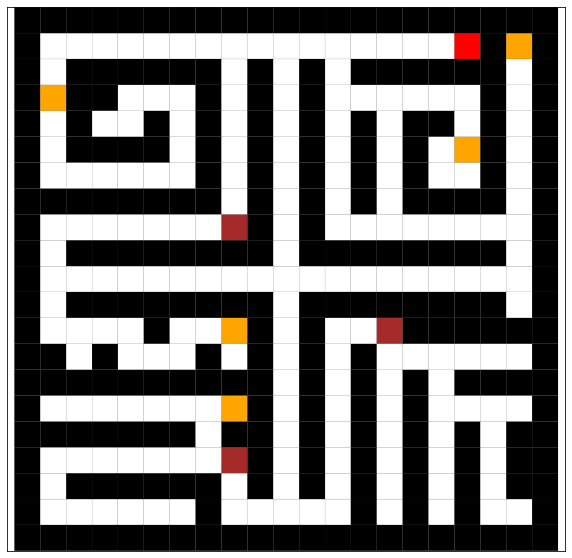

82


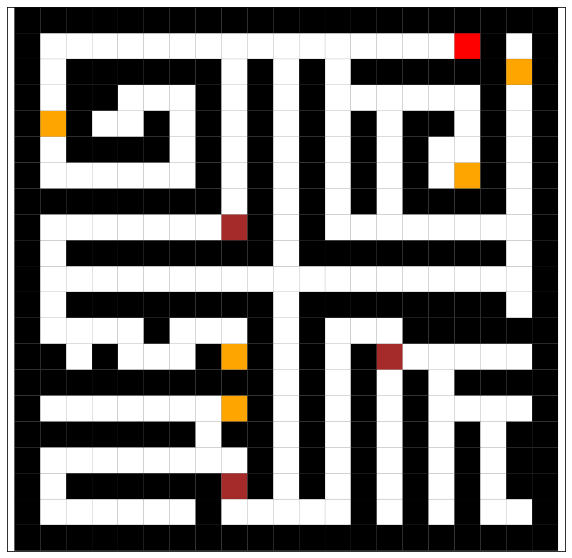

83


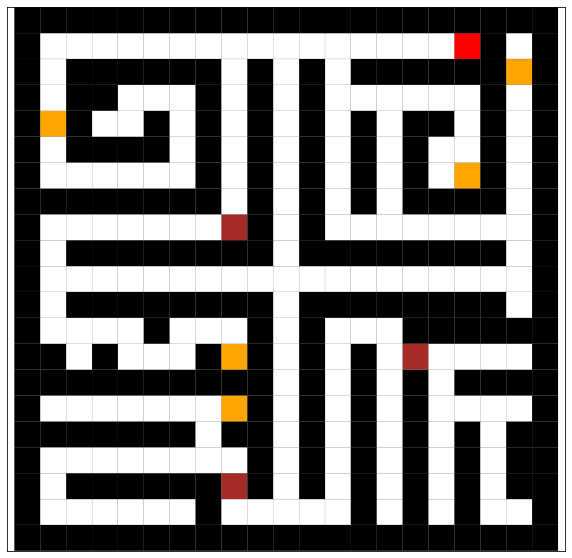

84


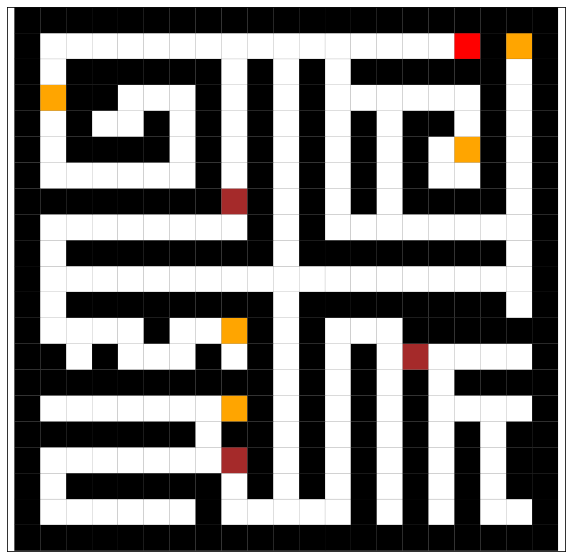

85


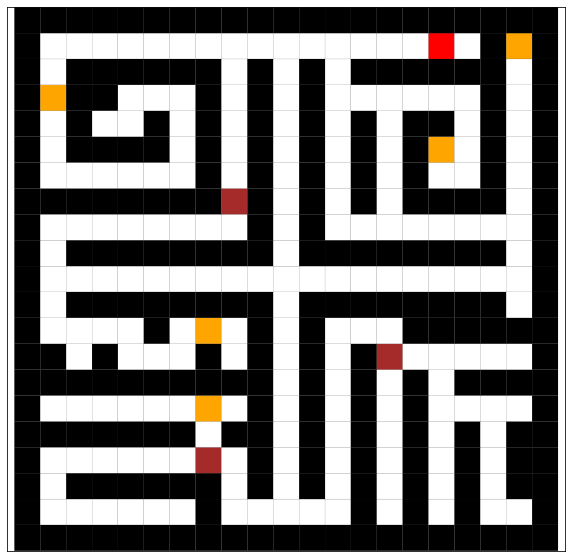

86


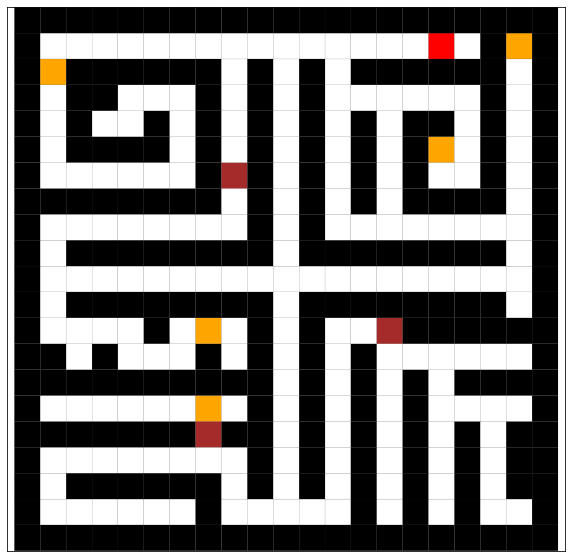

87


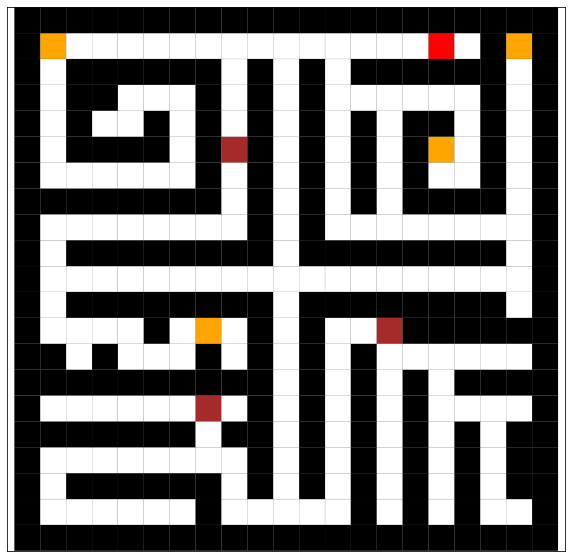

88


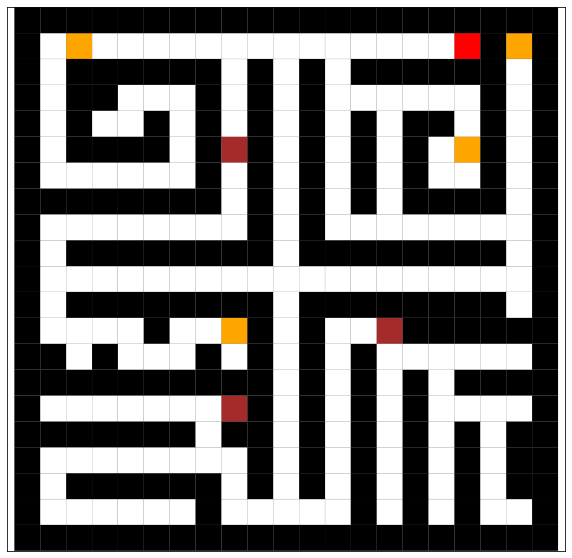

89


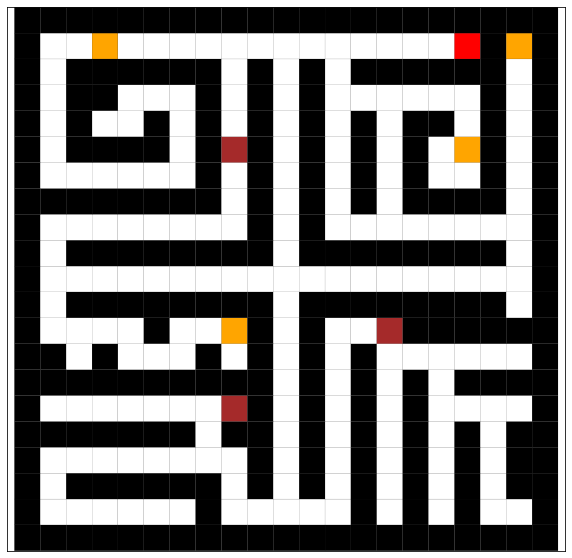

90


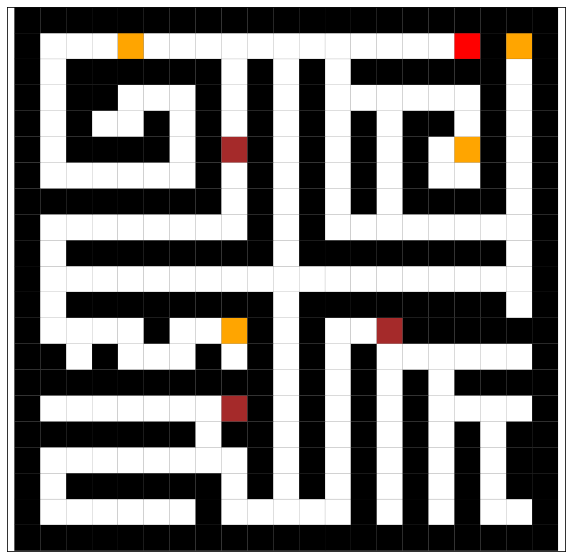

91


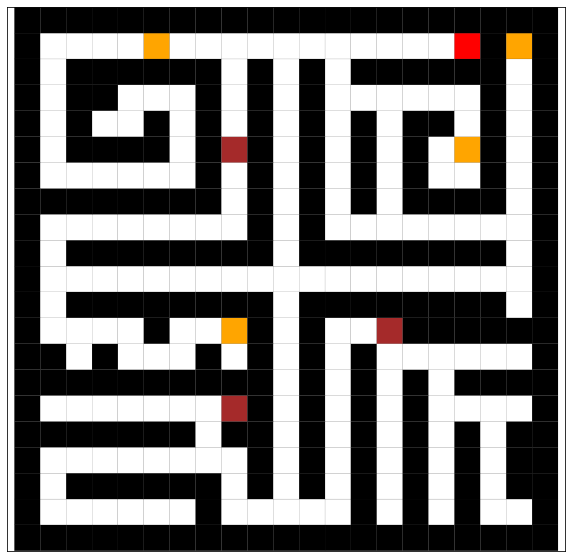

92


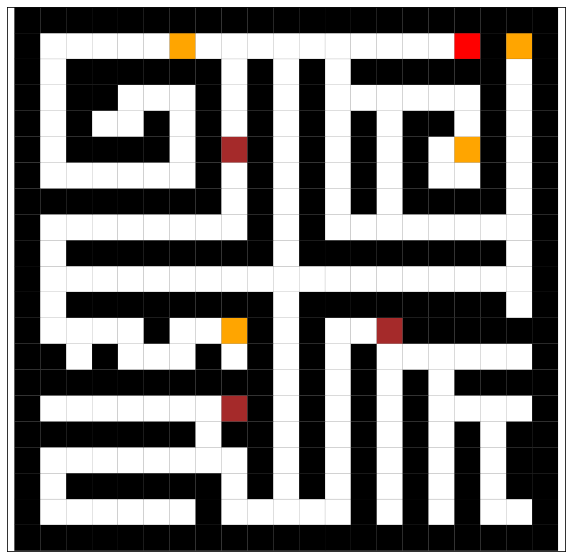

93


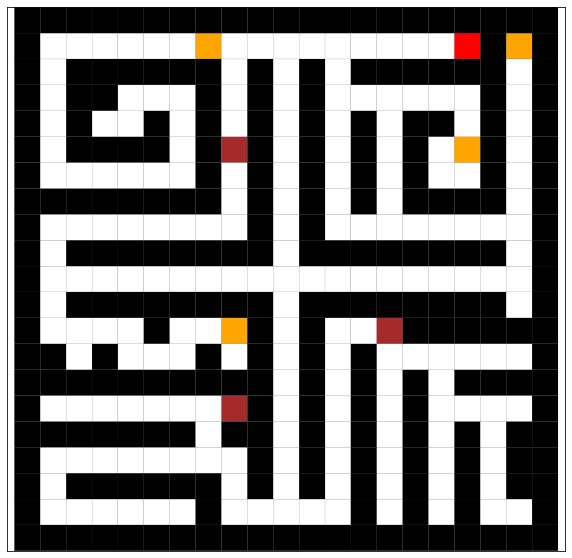

94


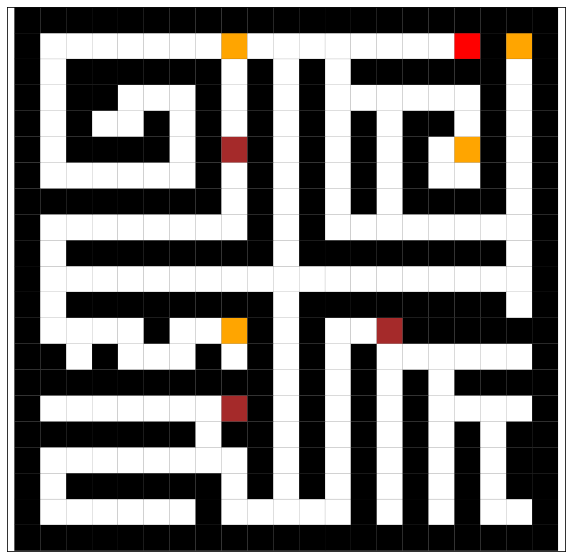

95


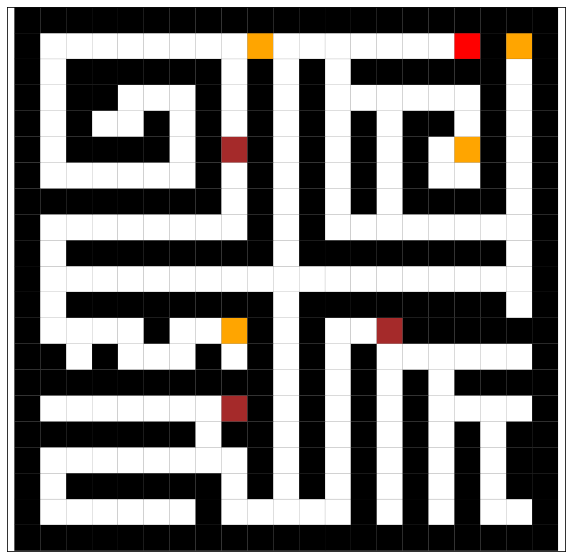

96


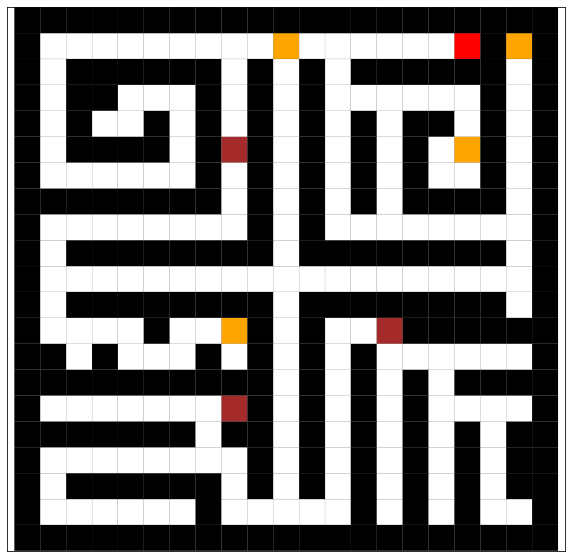

97


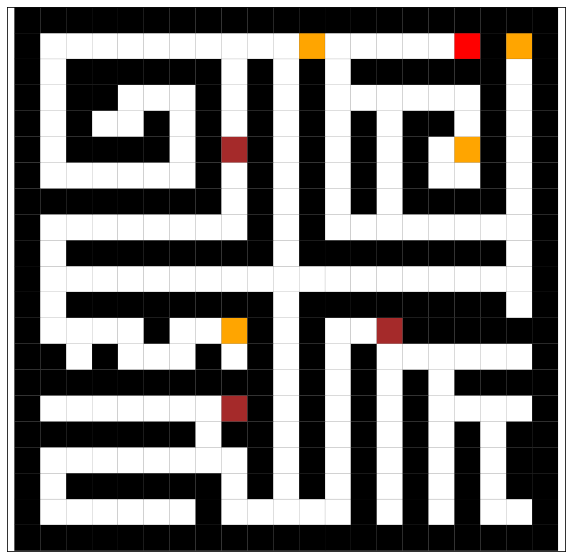

98


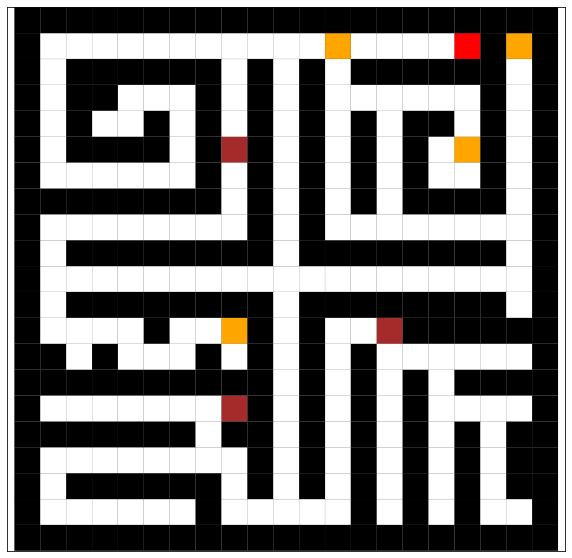

99


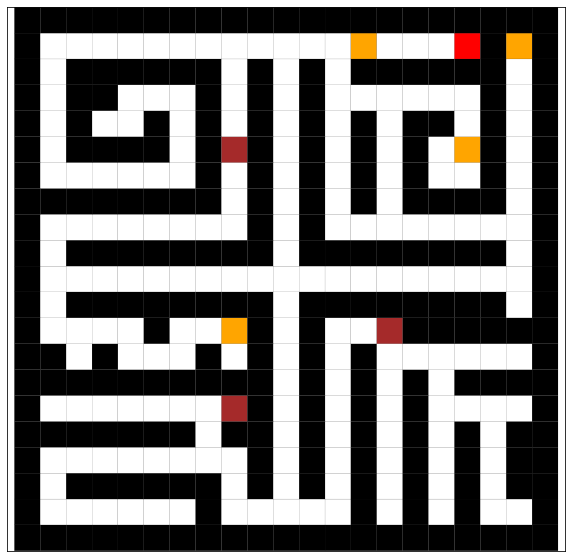

100


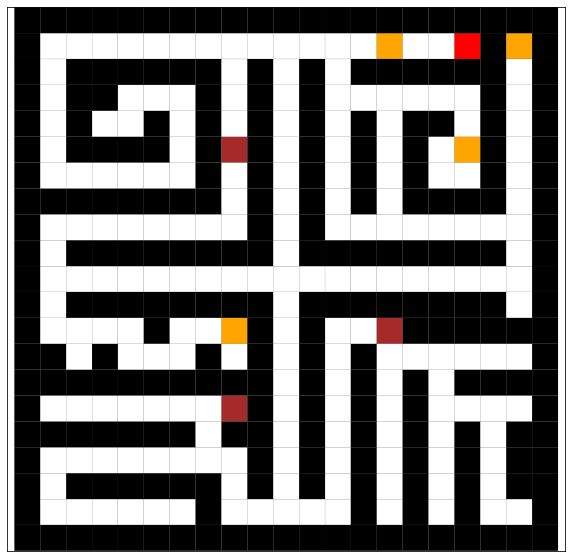

101


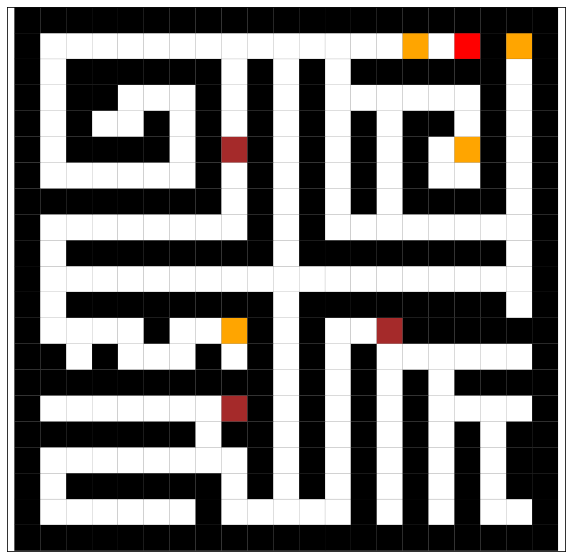

102


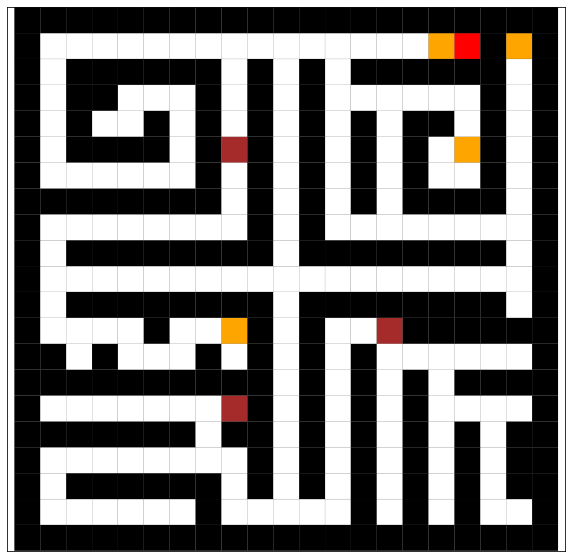

103


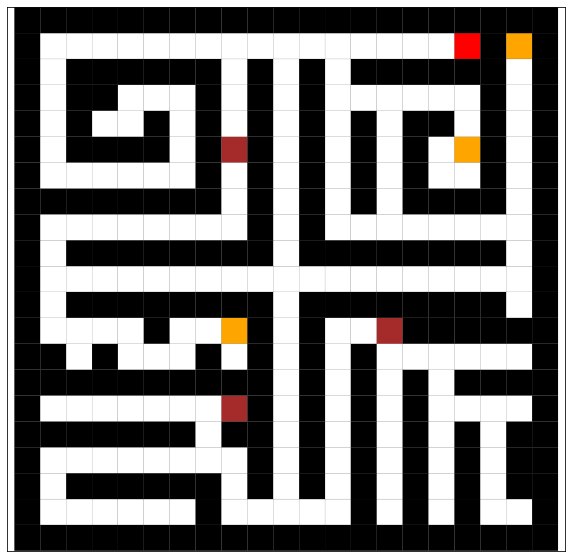

104


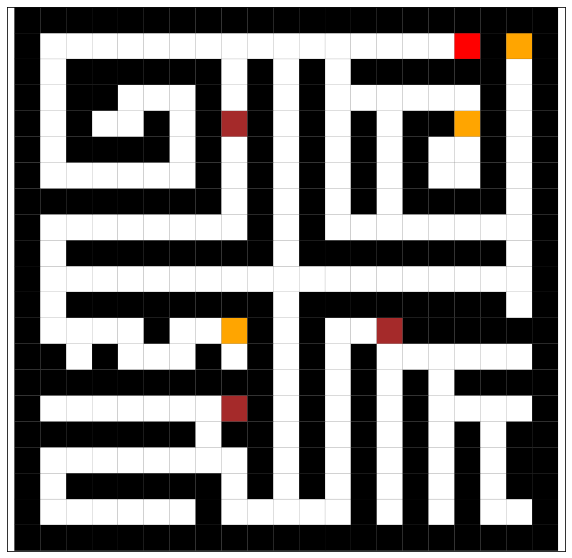

105


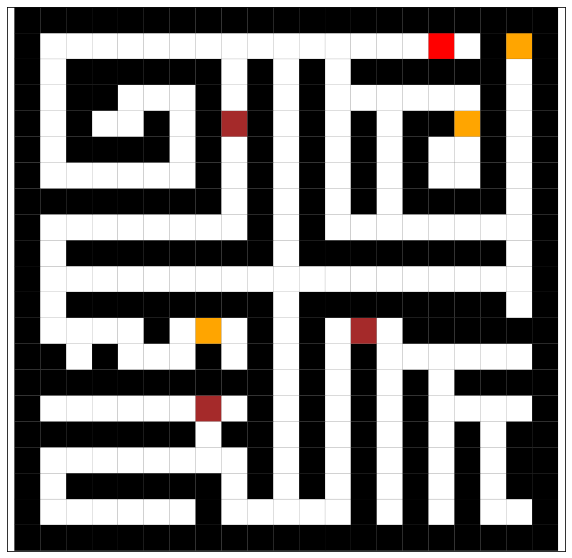

106


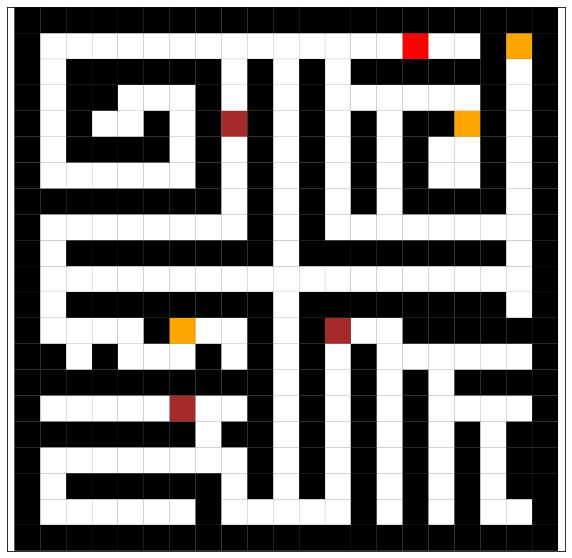

107


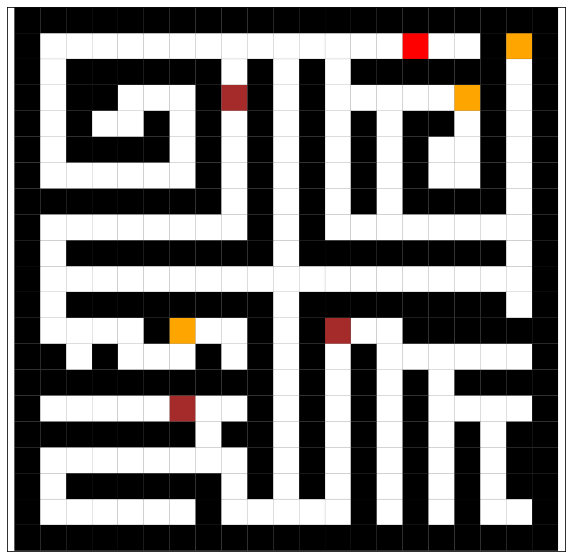

108


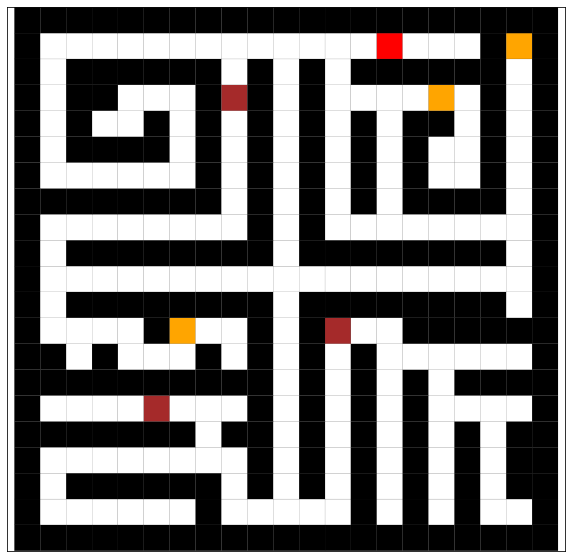

109


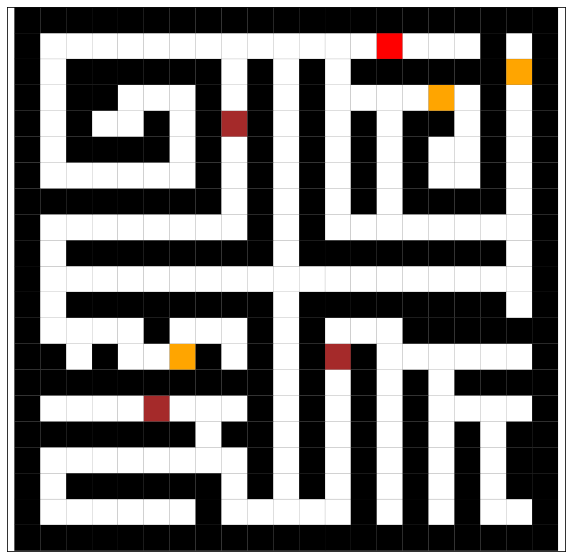

110


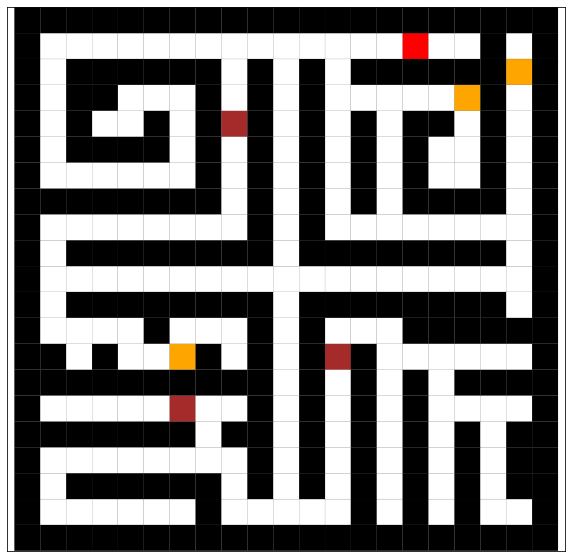

111


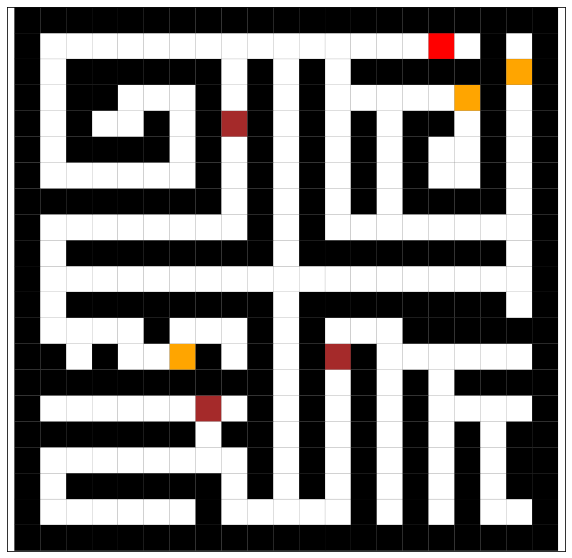

112


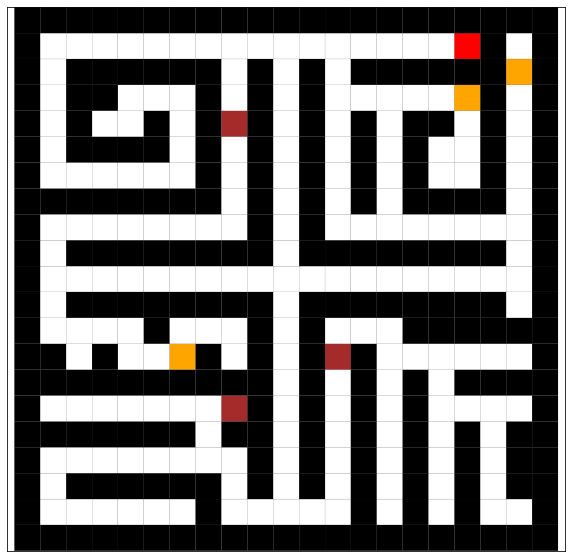

113


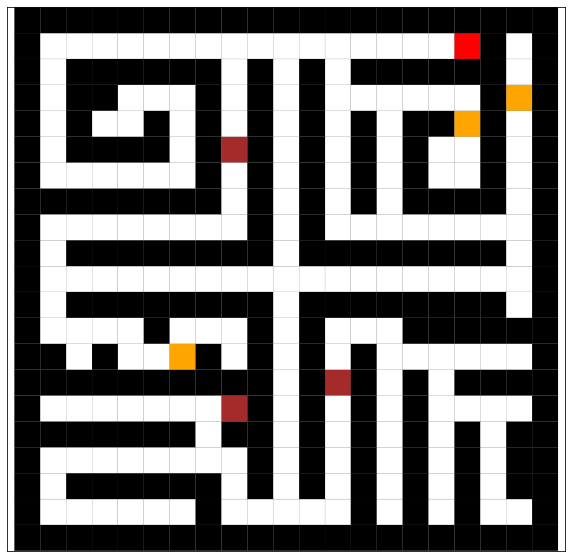

114


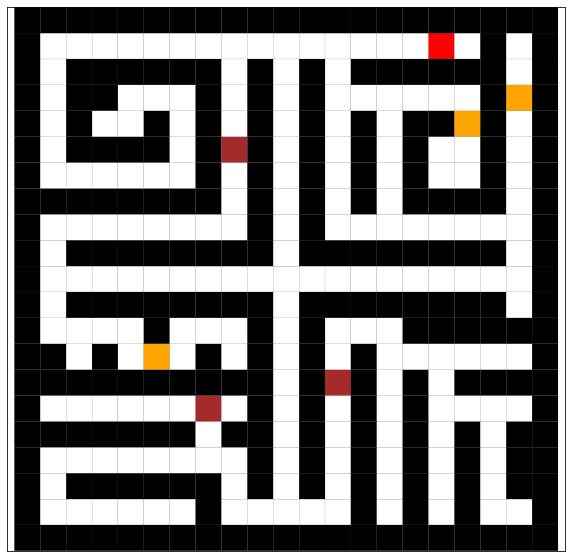

115


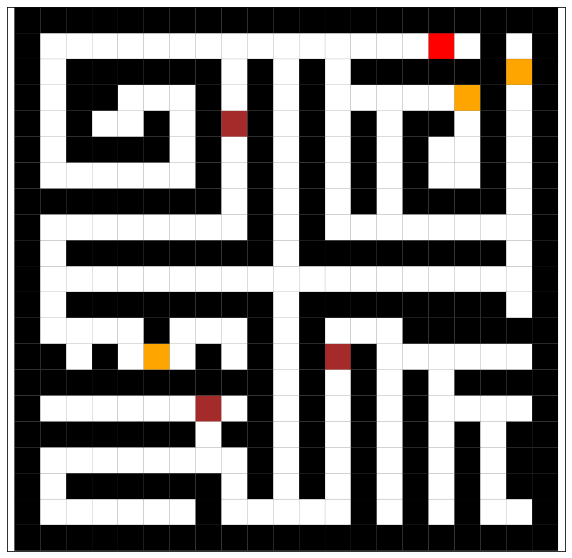

116


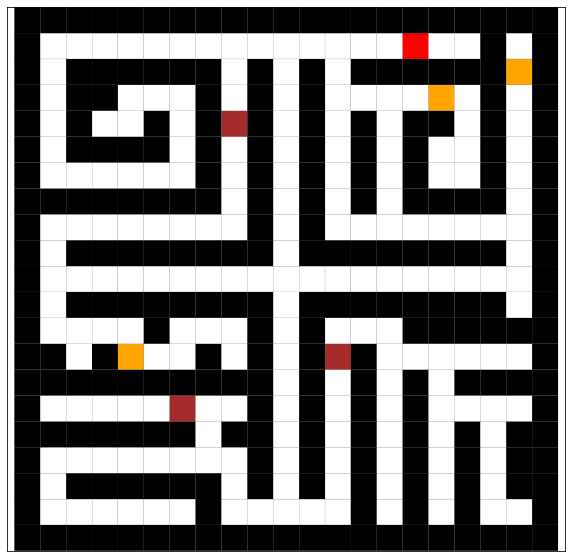

117


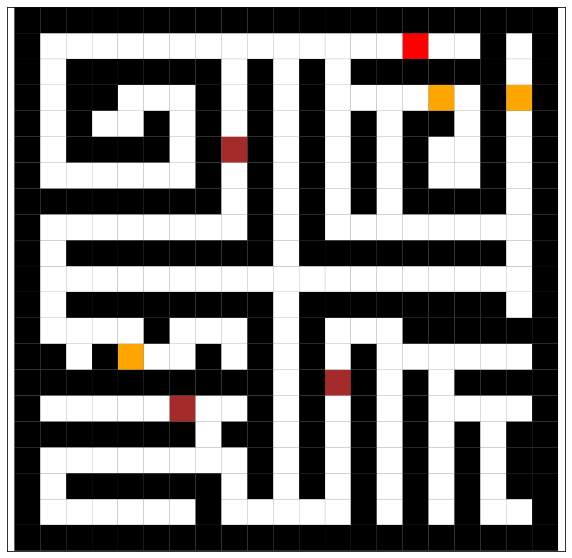

118


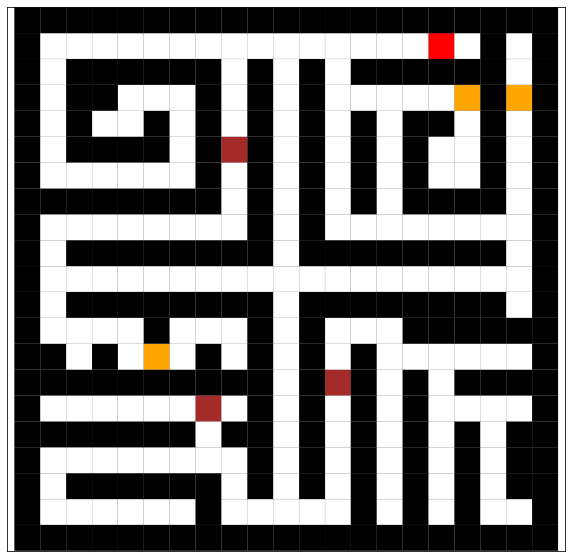

119


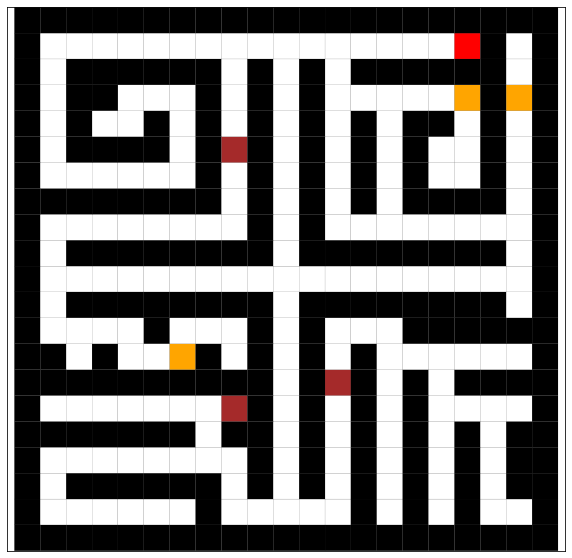

120


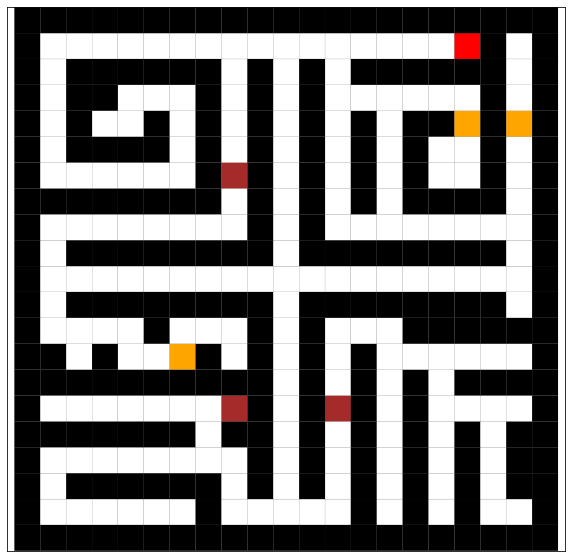

121


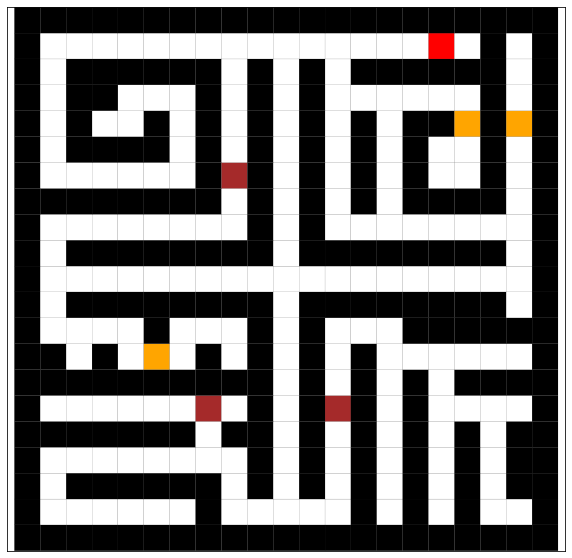

122


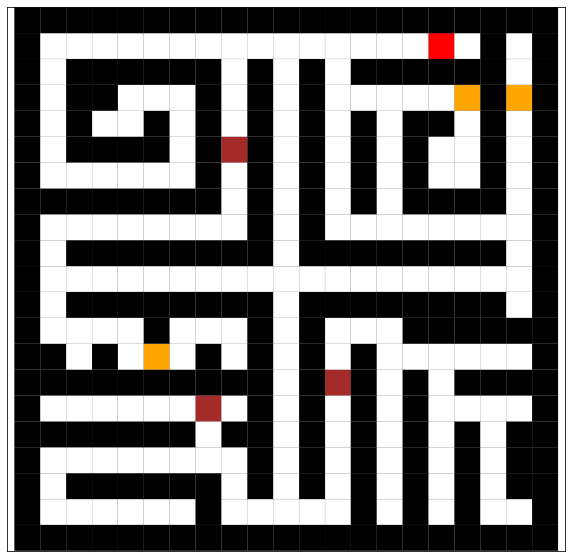

123


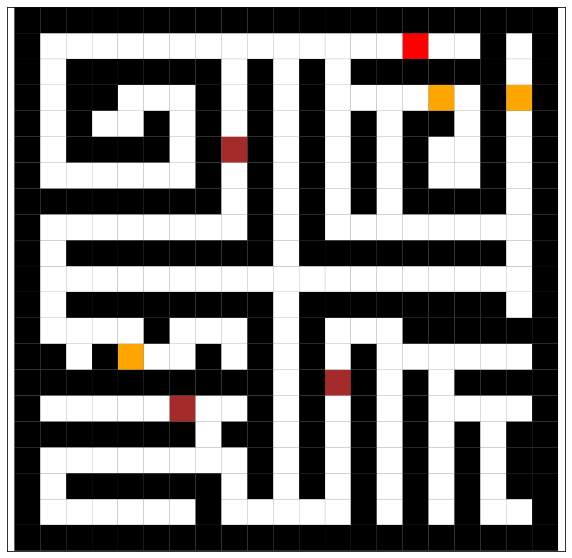

124


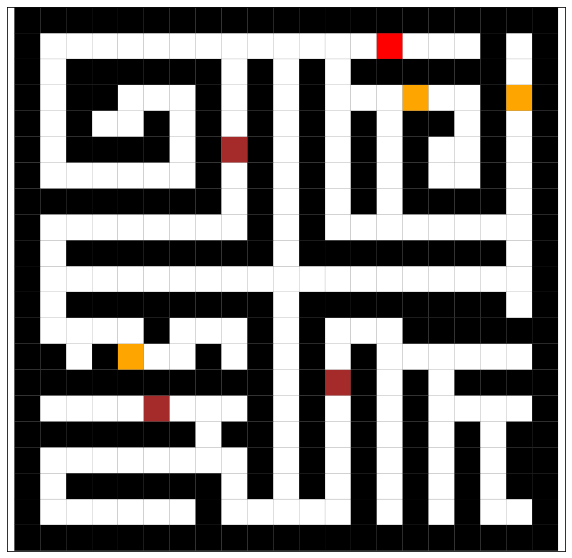

125


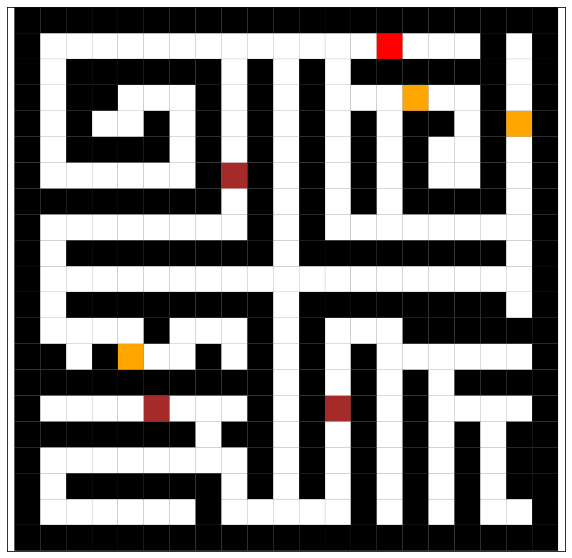

126


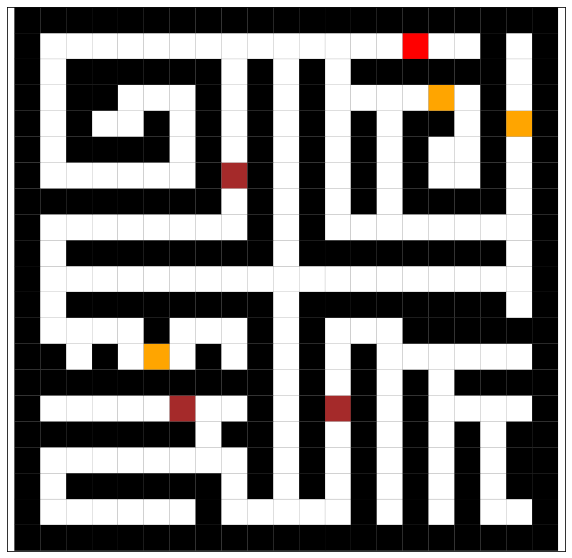

127


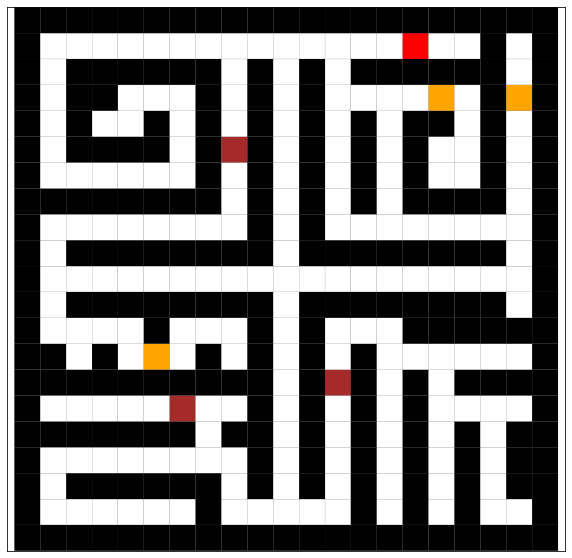

128


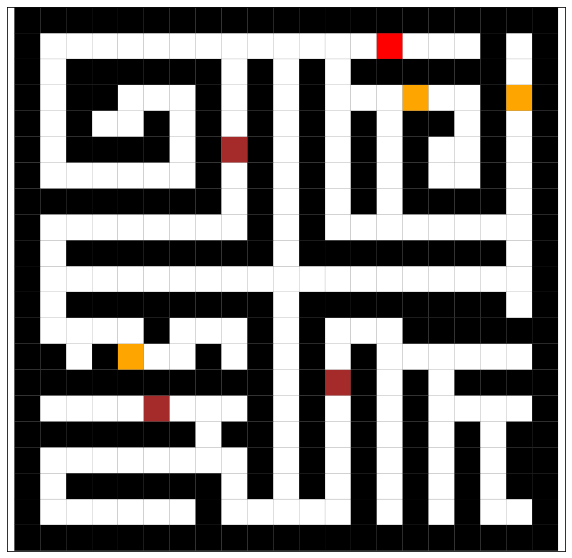

129


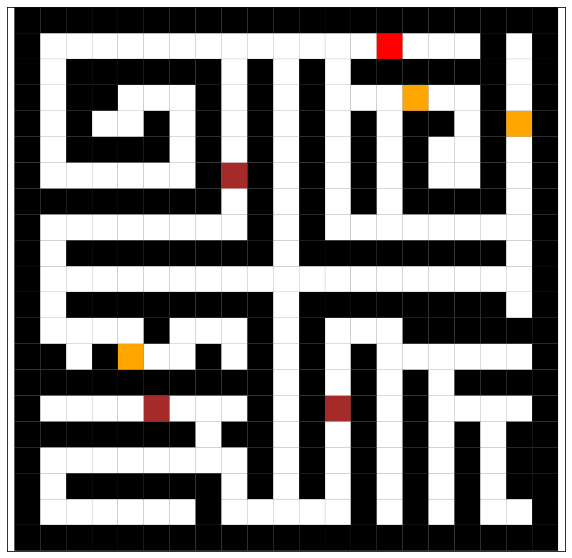

130


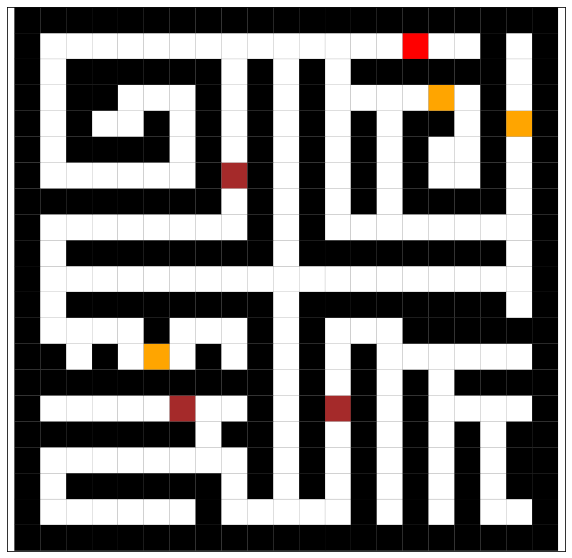

131


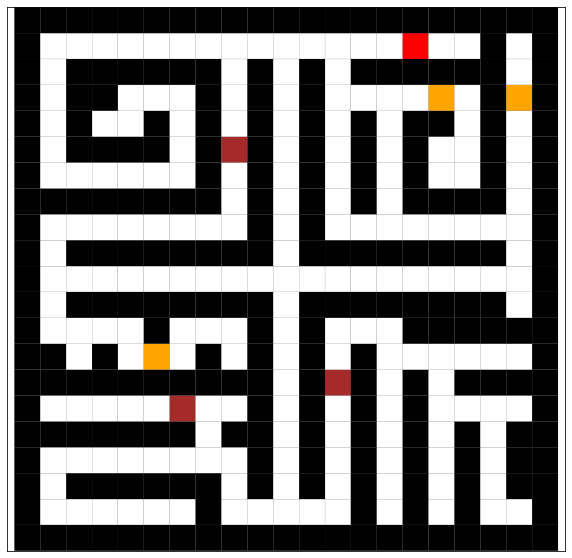

132


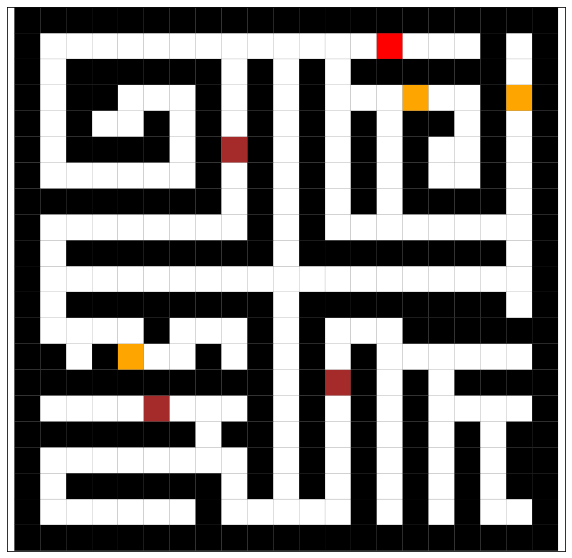

133


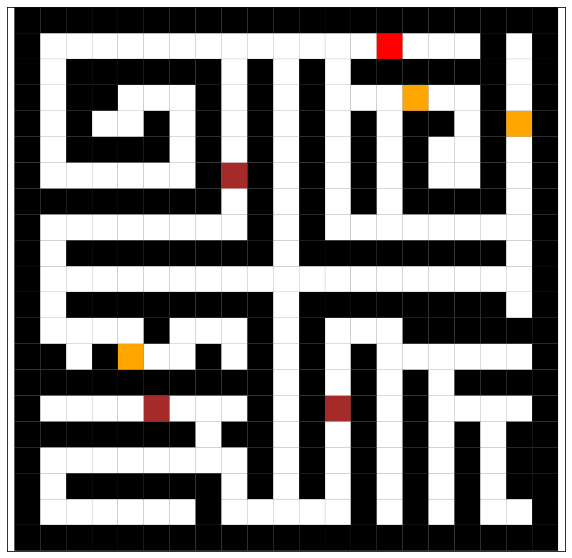

134


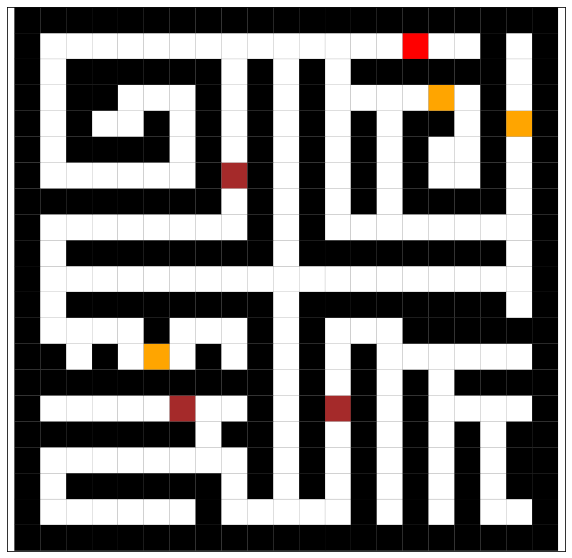

135


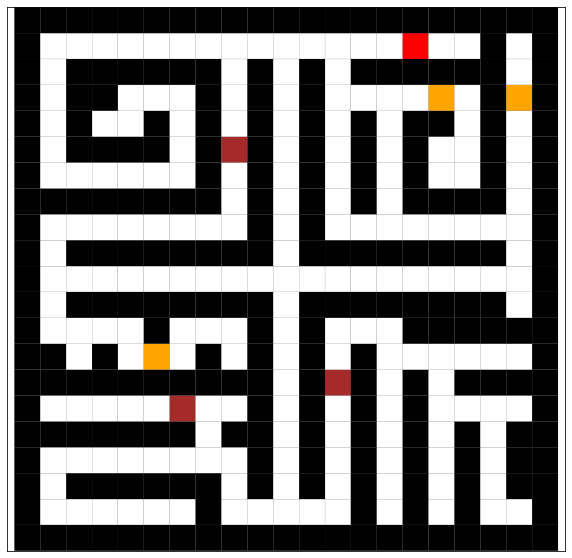

136


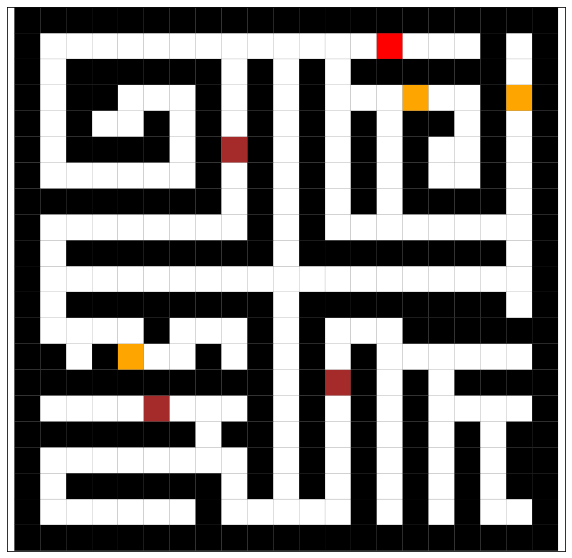

137


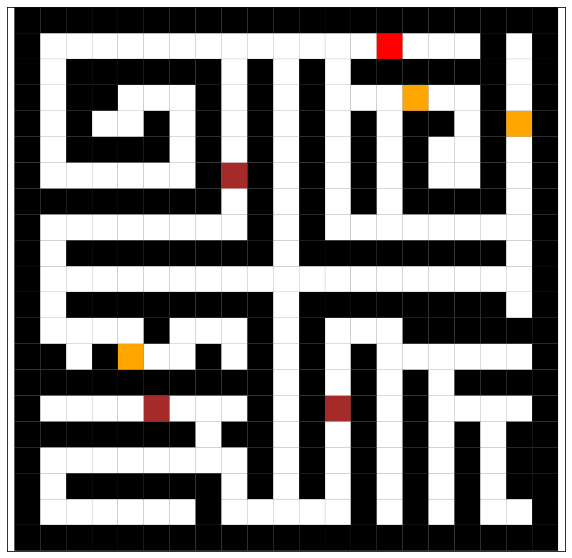

138


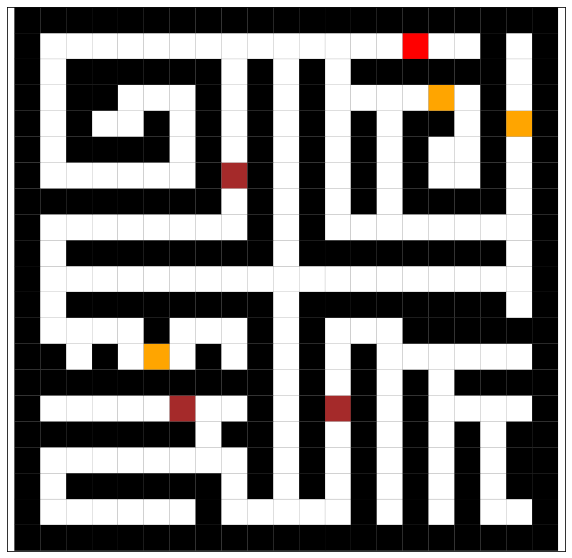

139


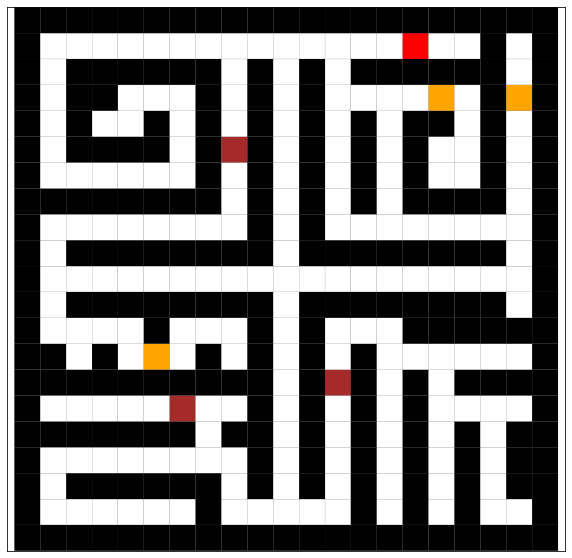

140


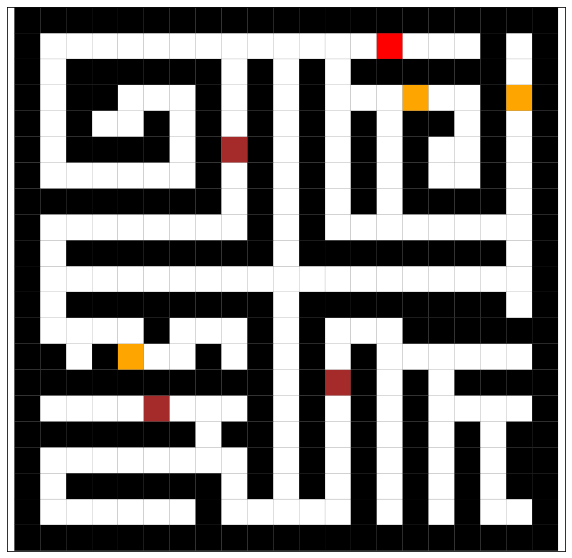

141


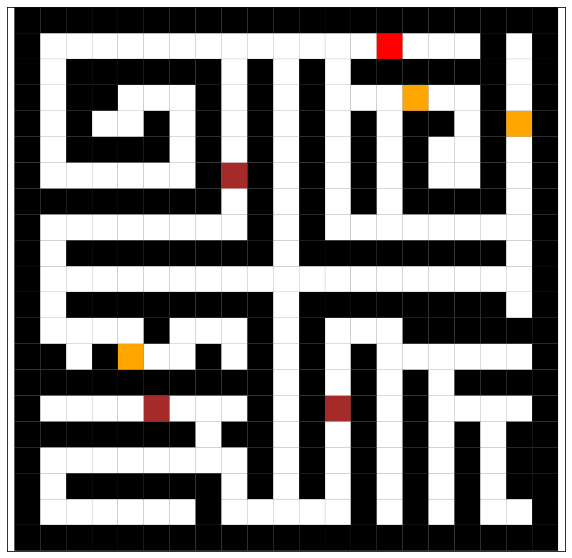

142


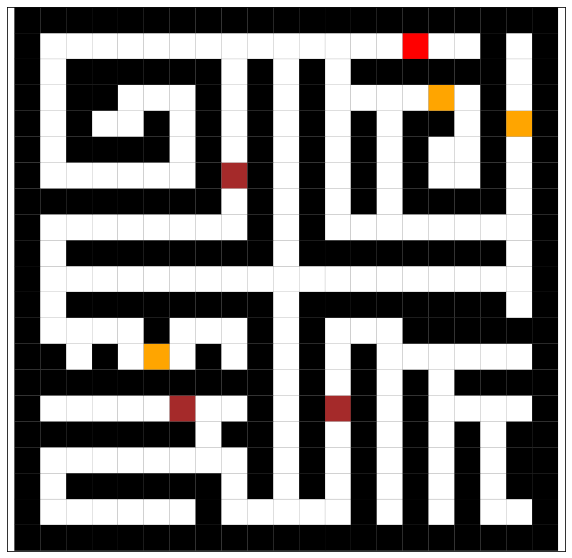

143


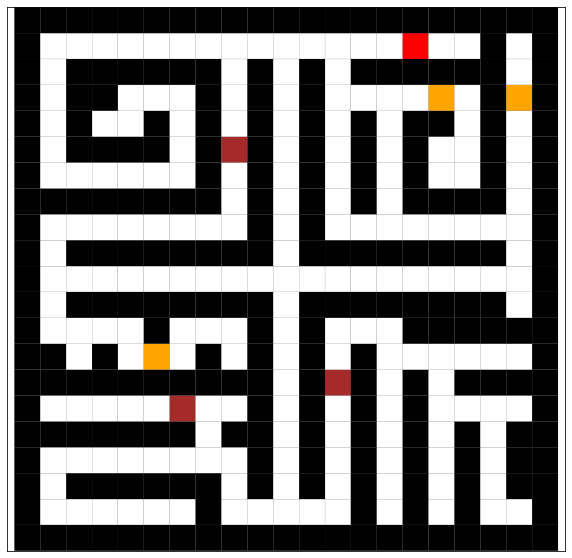

144


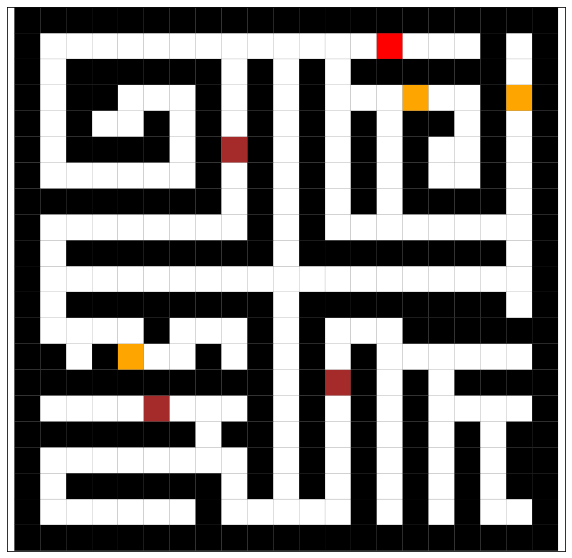

145


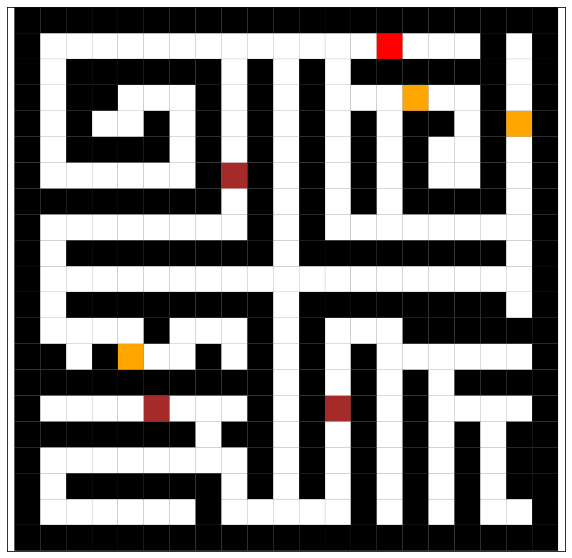

146


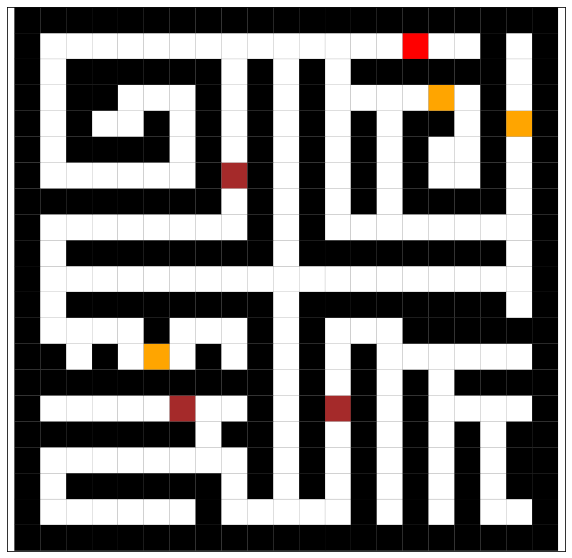

147


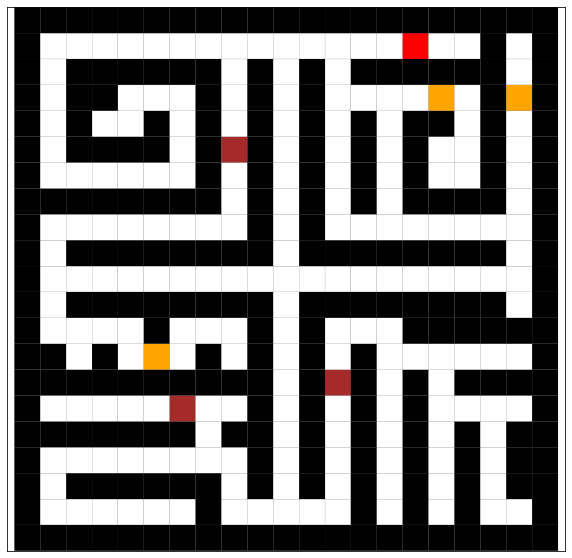

148


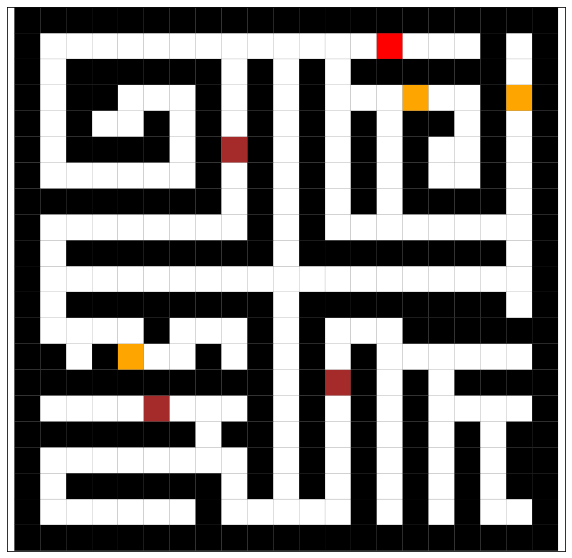

149


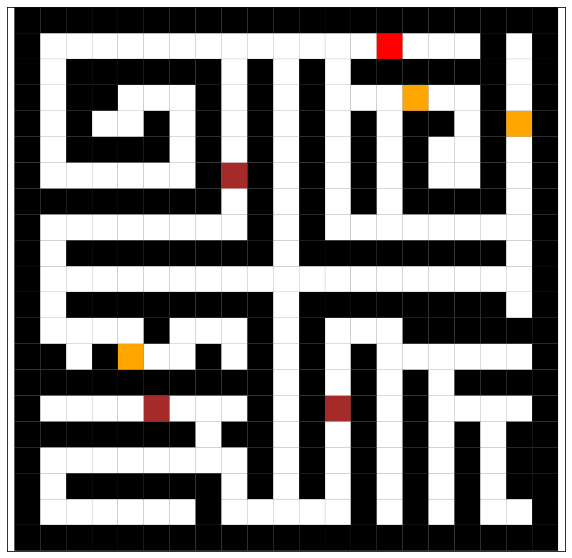

150


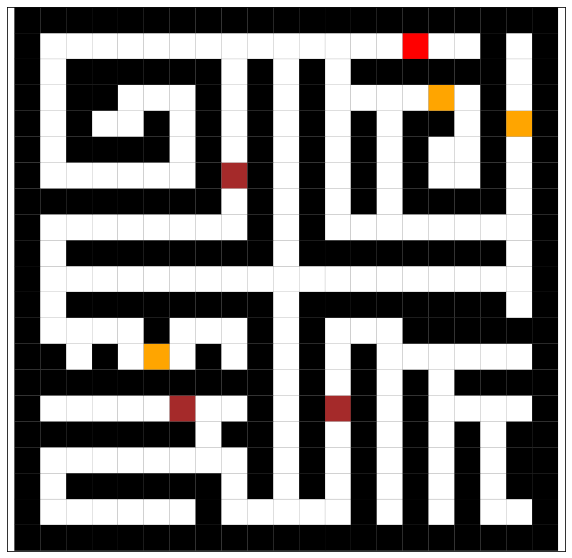

151


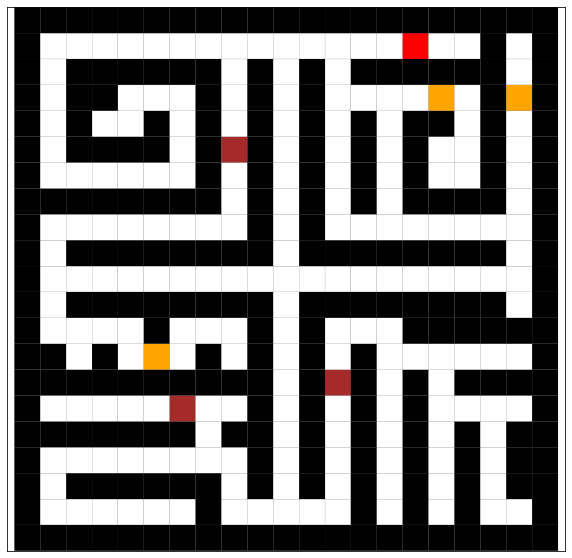

152


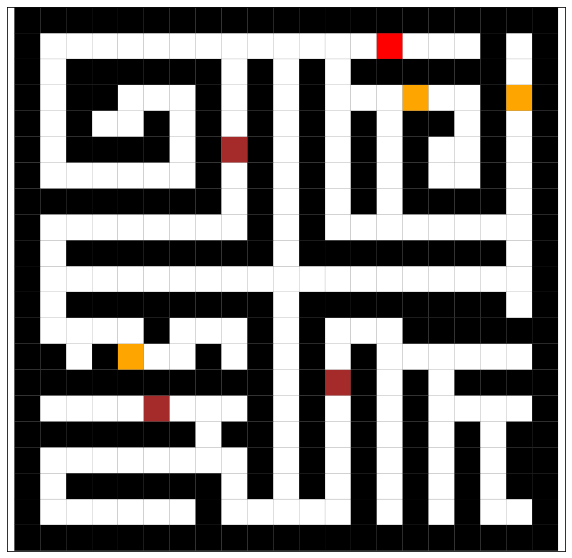

153


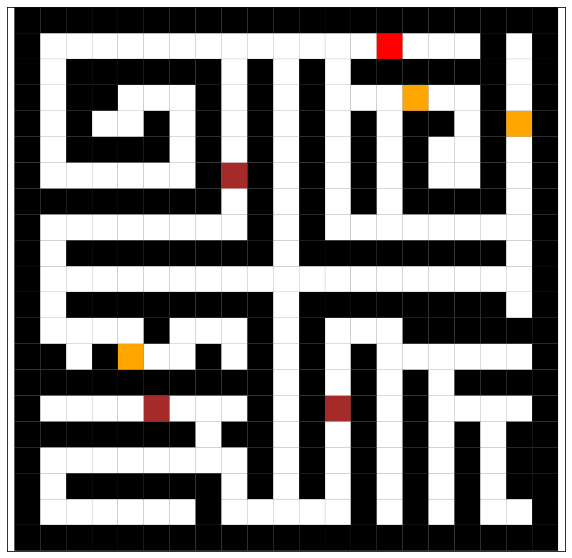

154


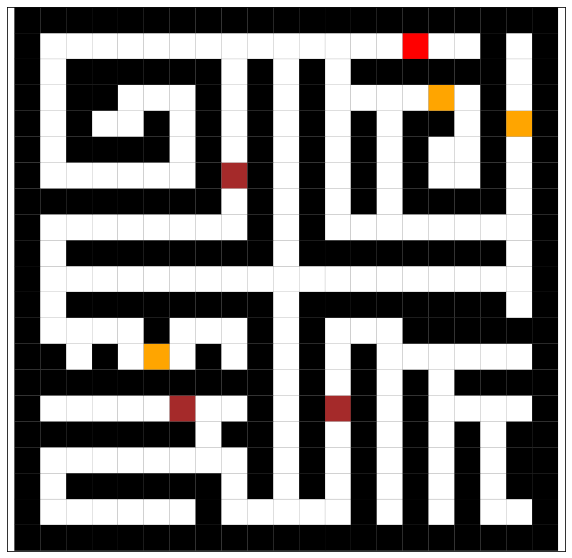

155


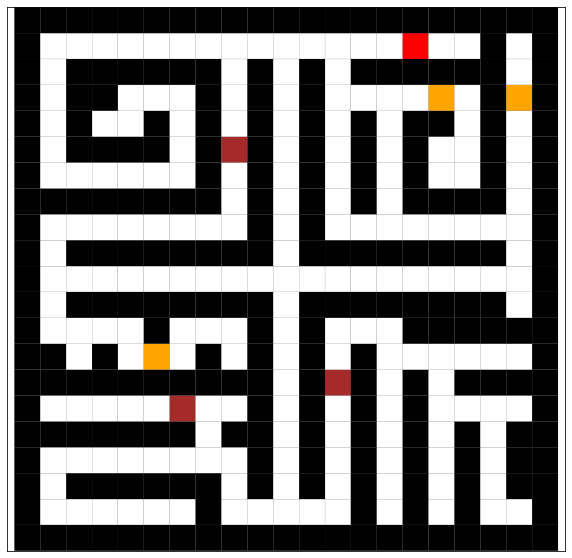

156


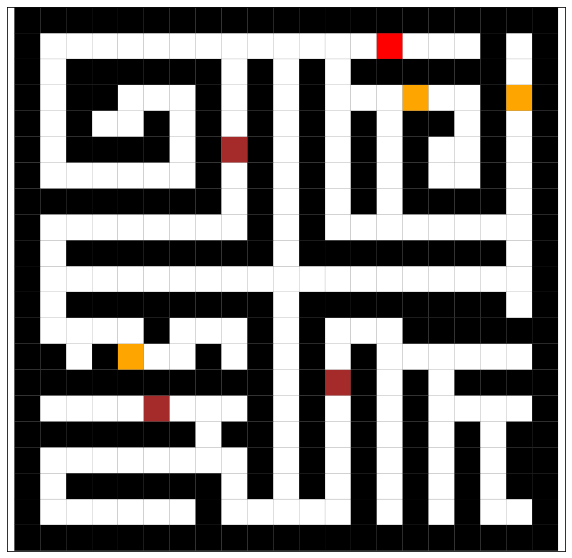

157


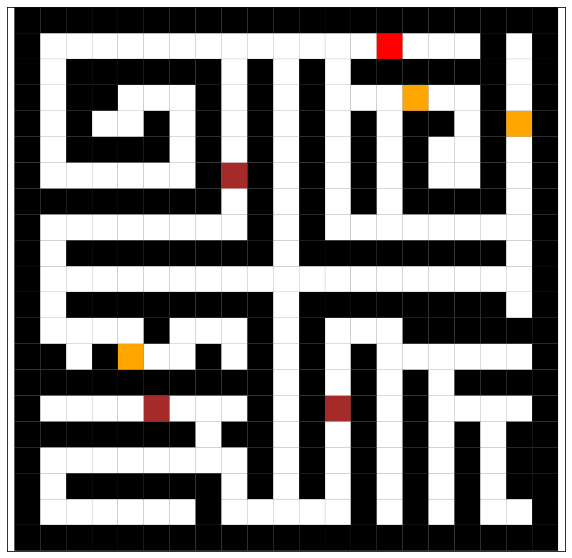

158


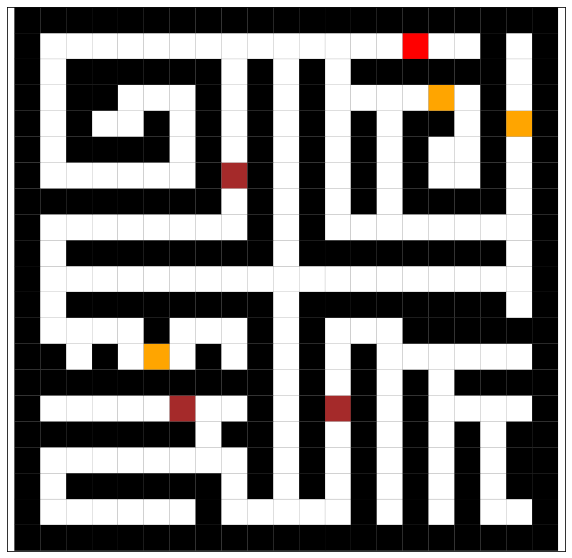

159


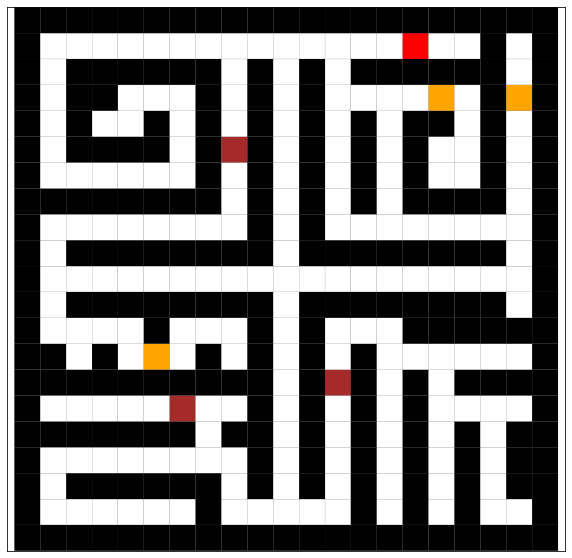

160


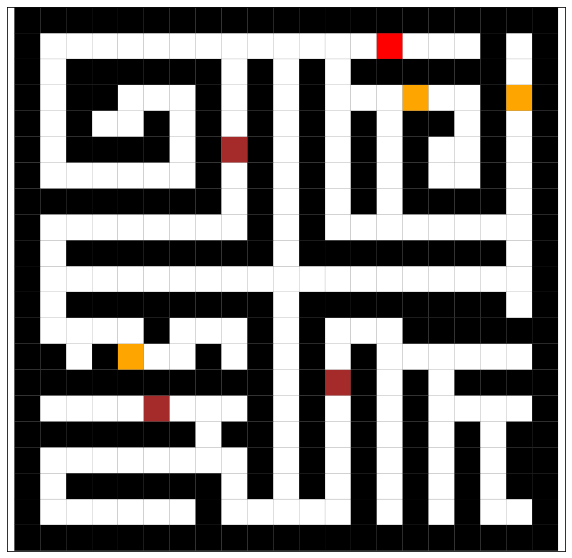

161


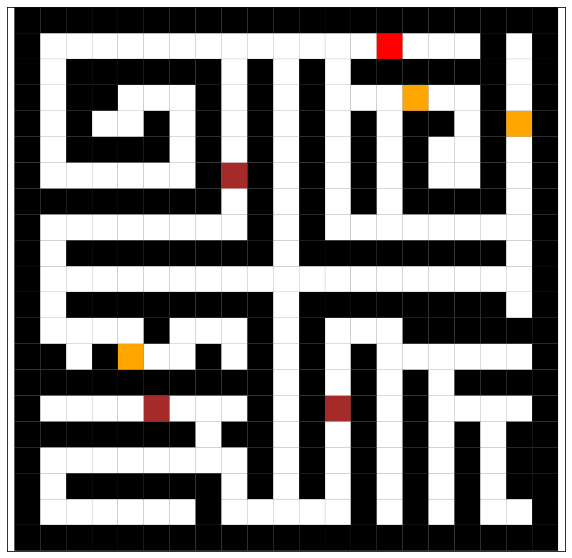

162


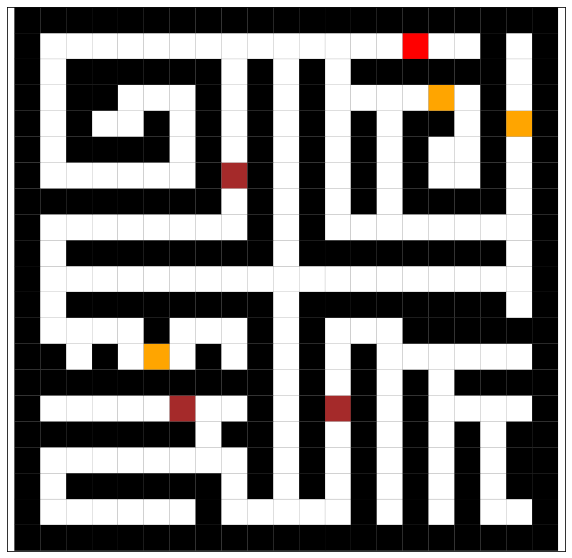

163


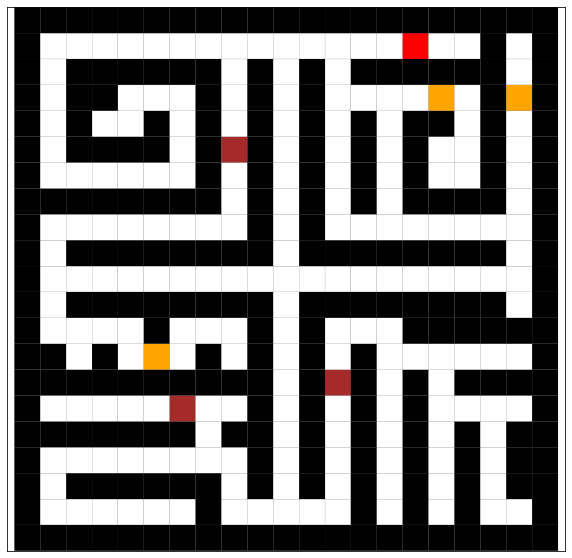

164


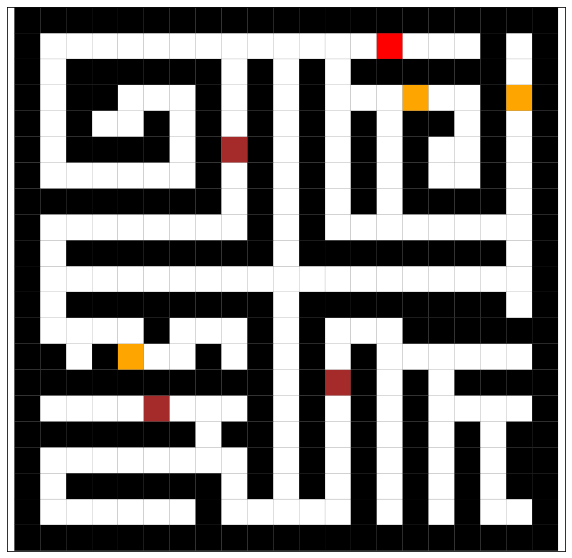

165


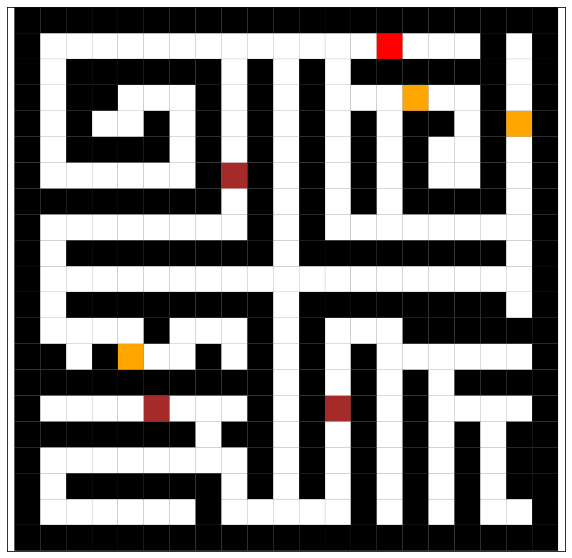

166


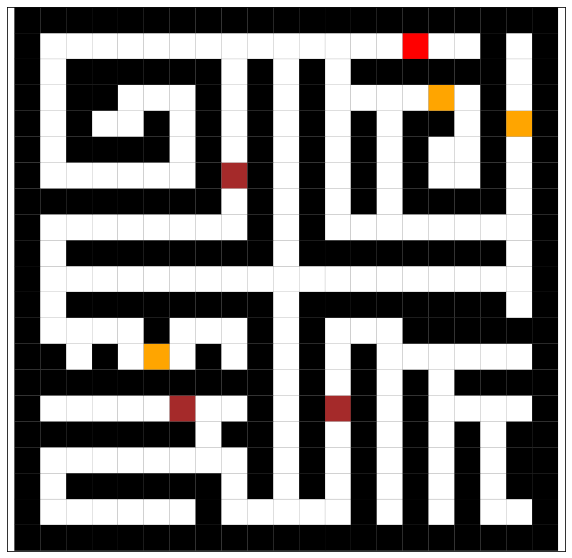

167


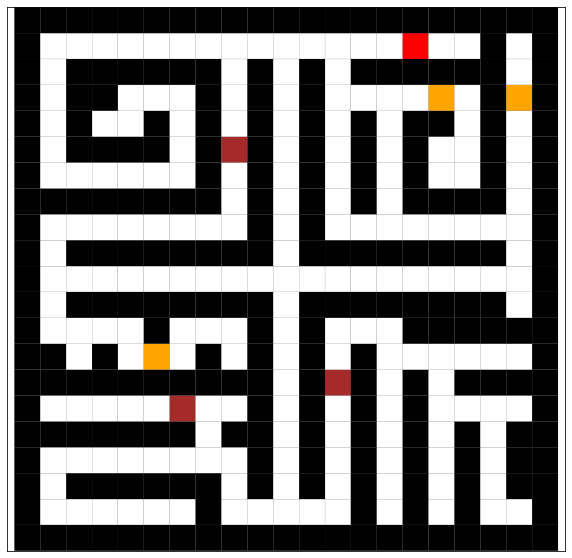

168


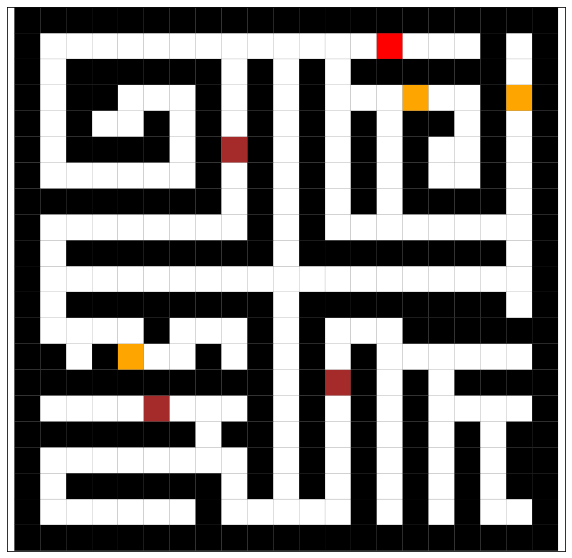

169


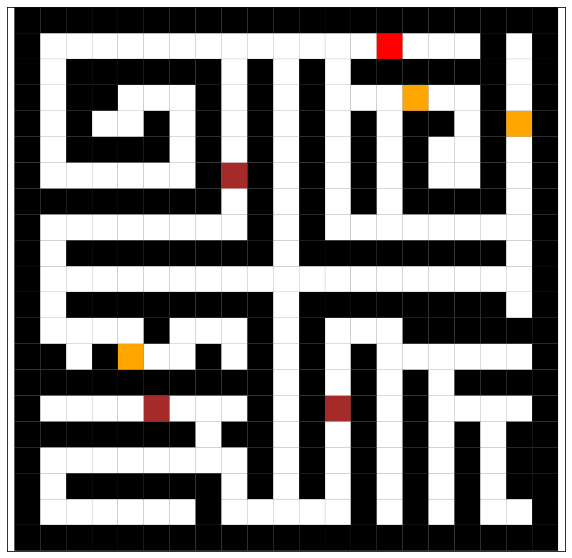

170


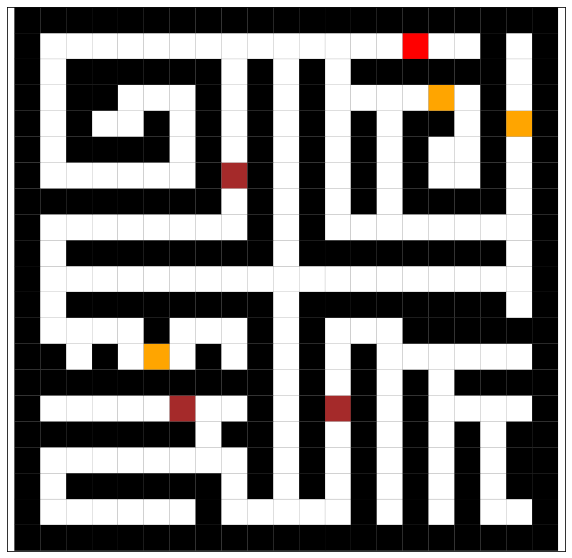

171


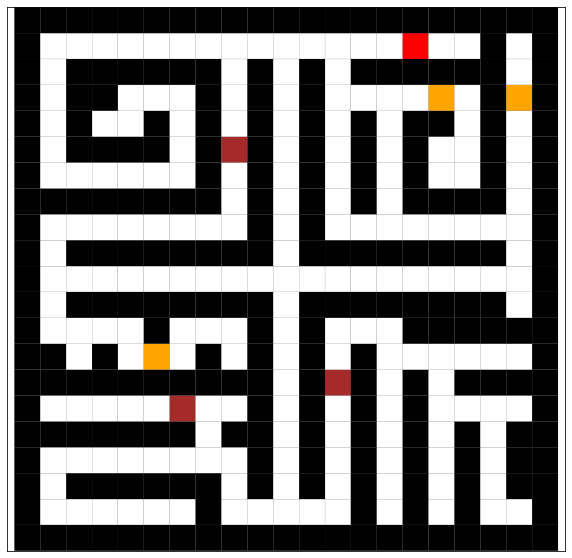

172


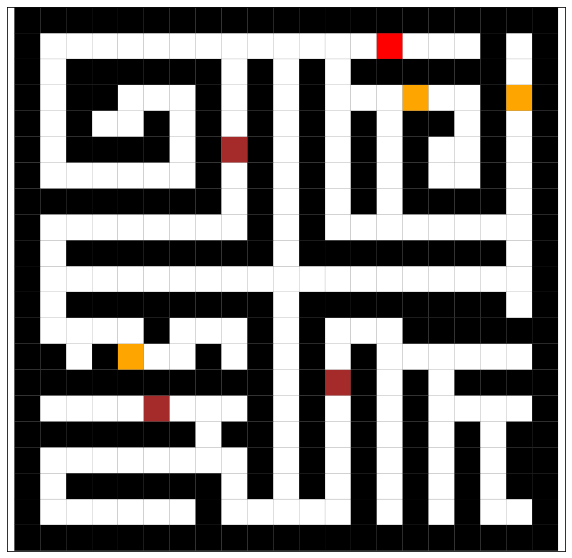

173


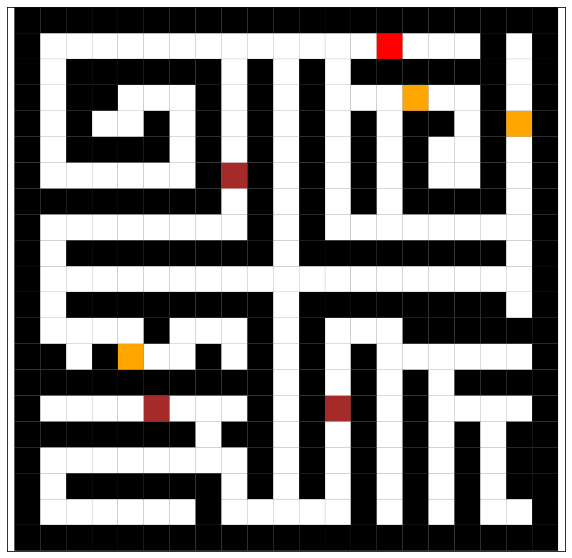

174


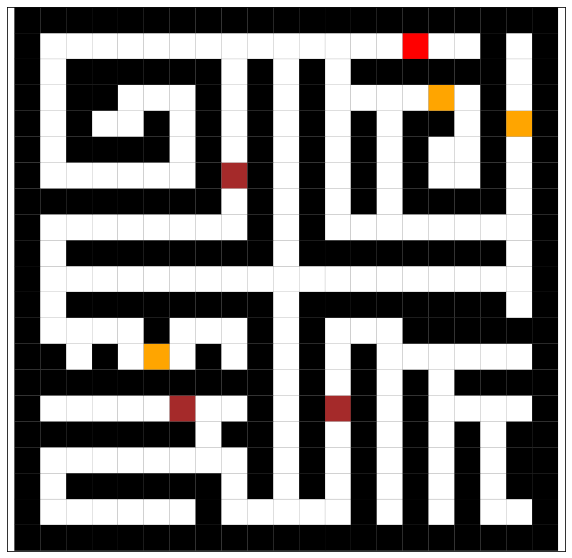

175


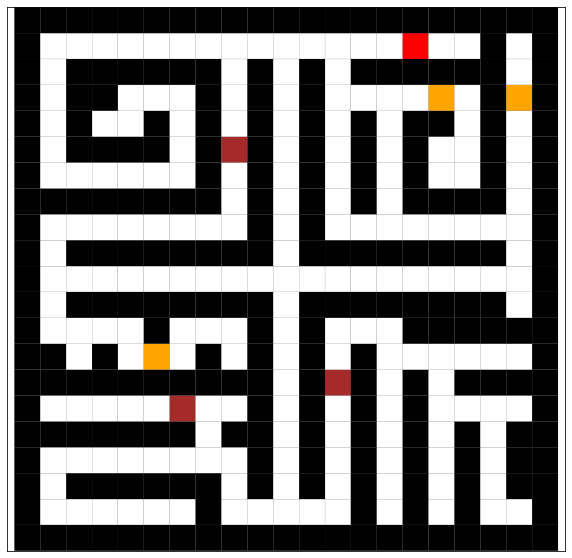

176


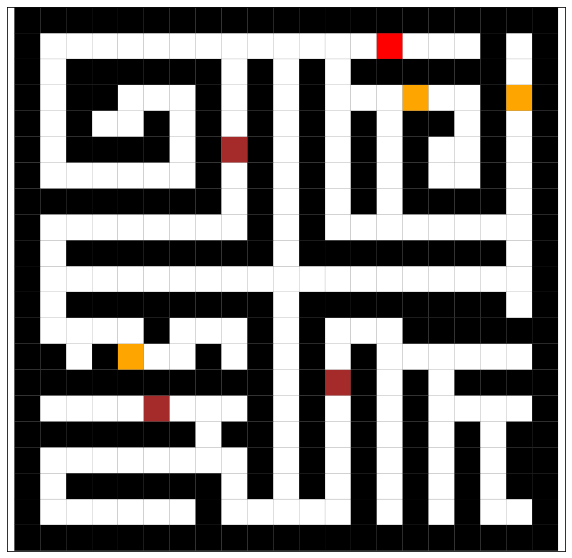

177


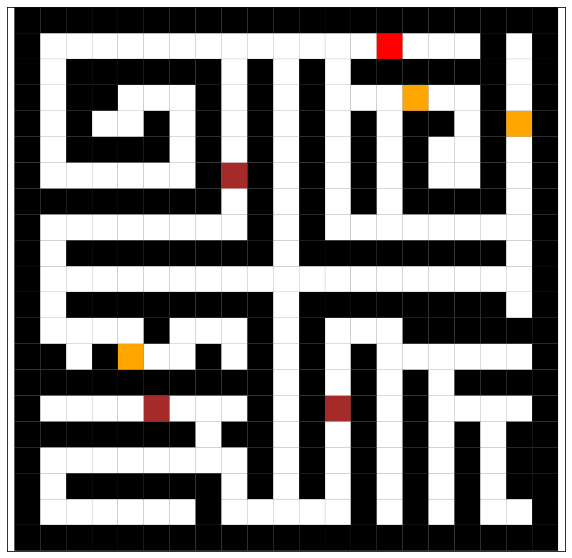

178


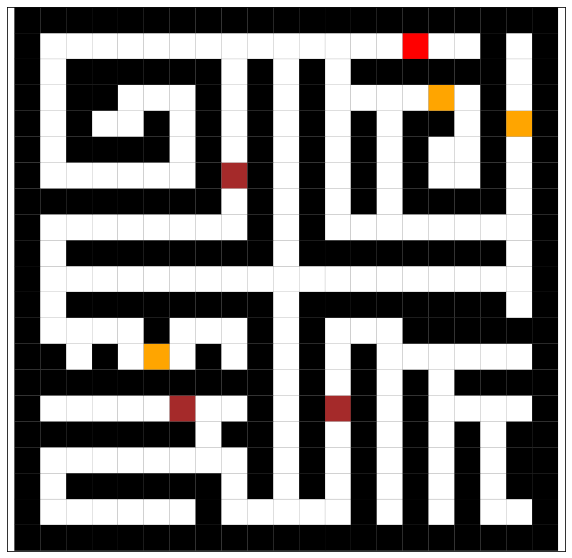

179


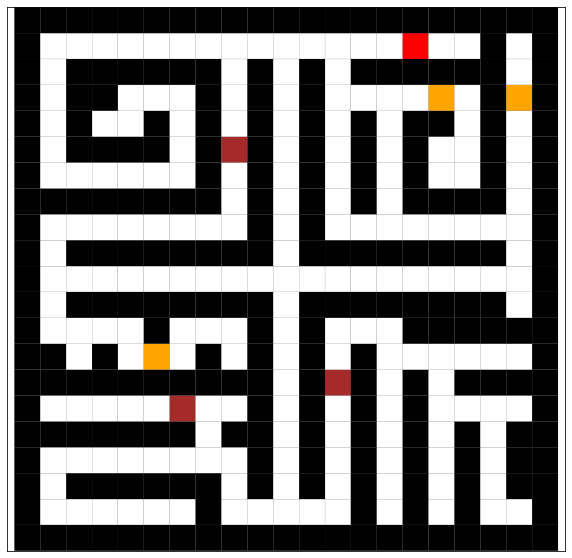

180


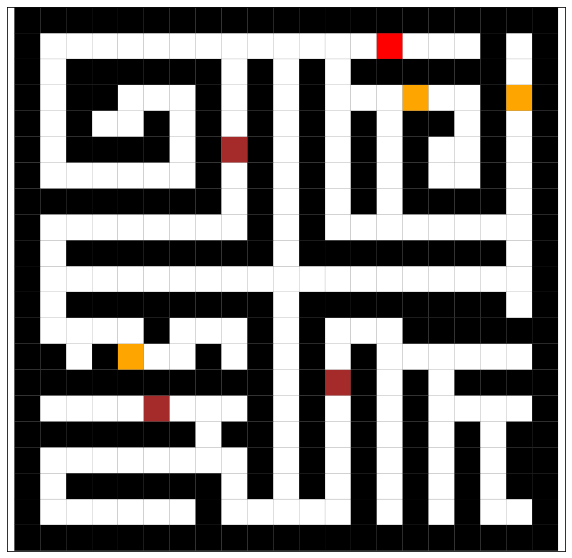

181


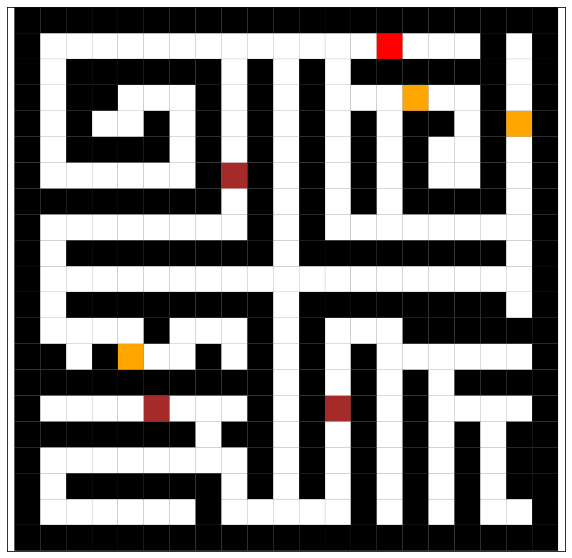

182


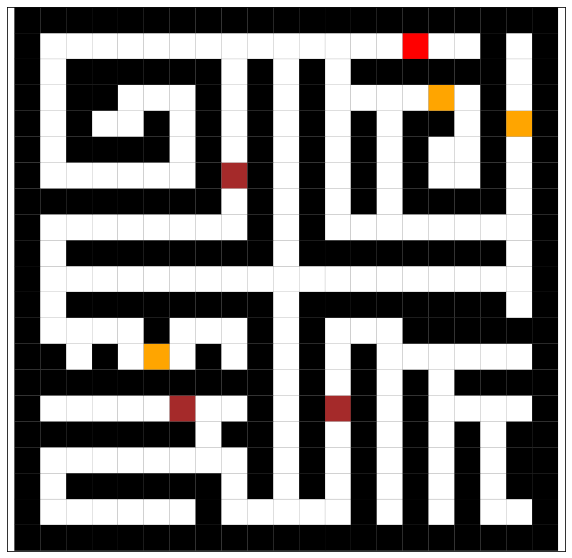

183


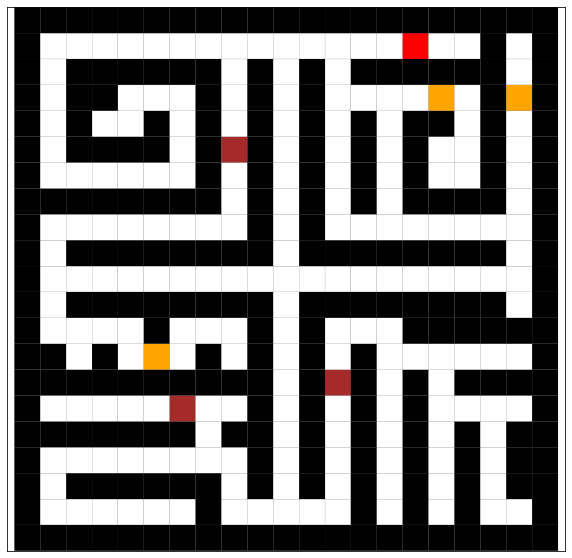

184


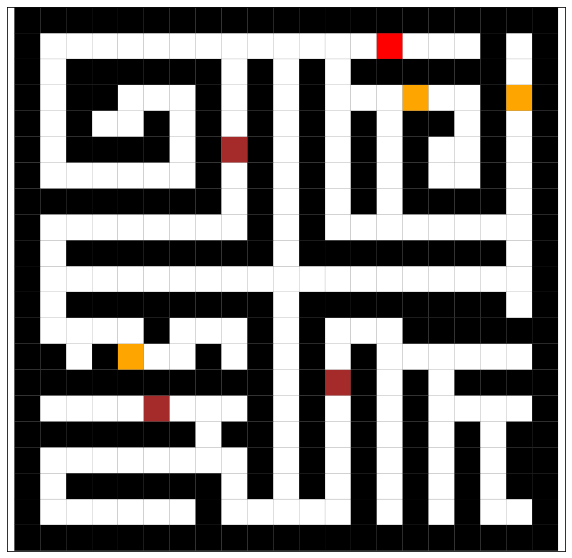

185


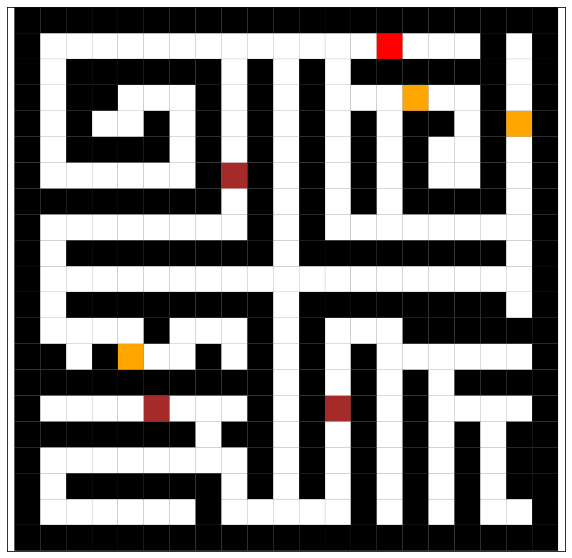

186


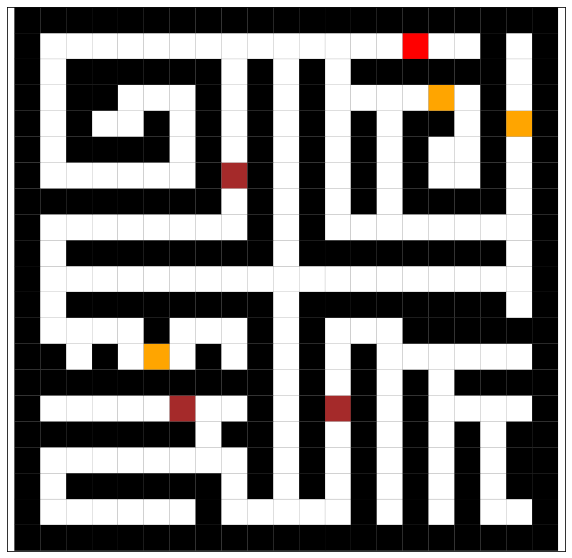

187


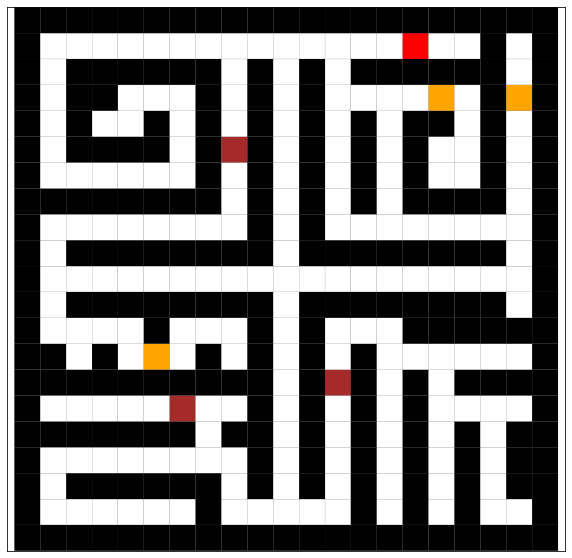

188


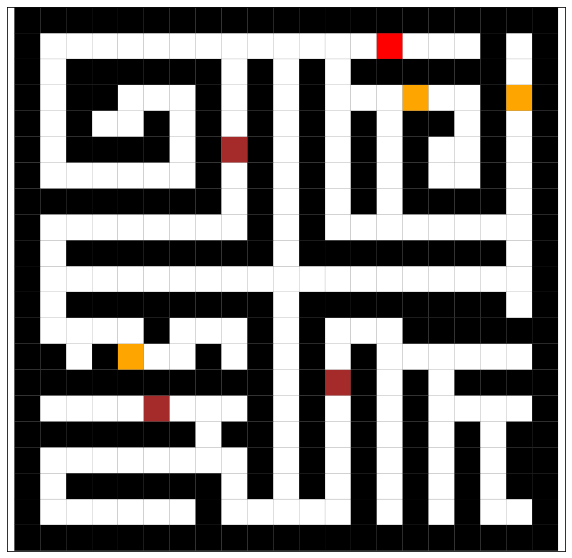

189


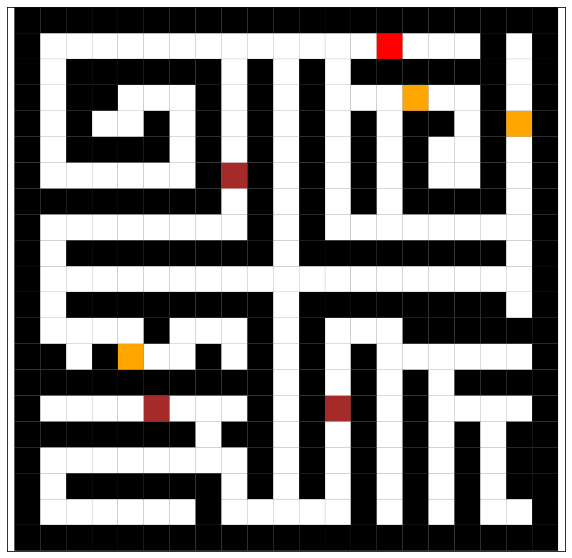

190


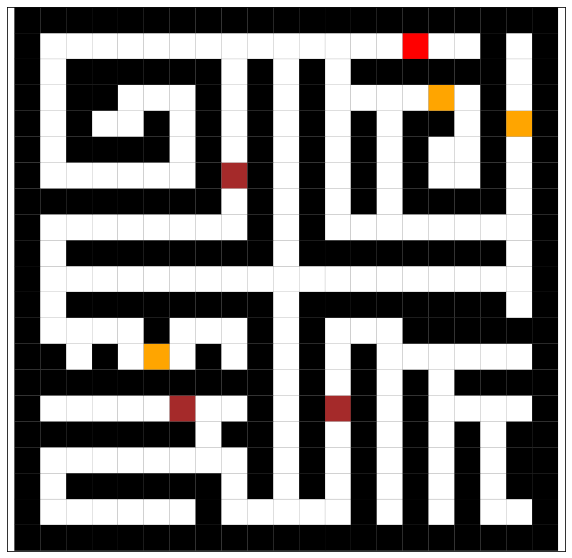

191


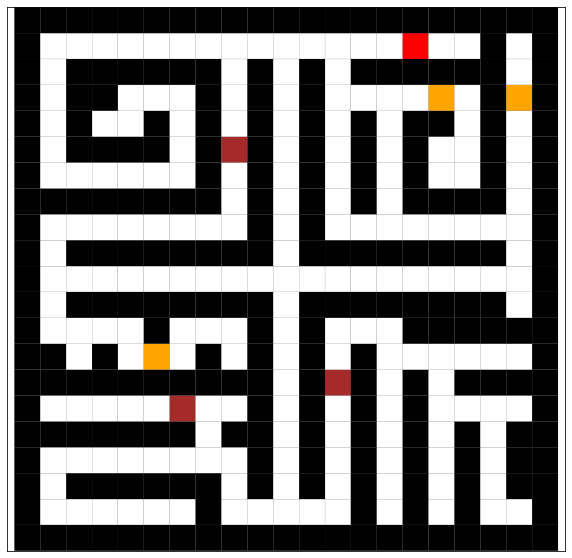

192


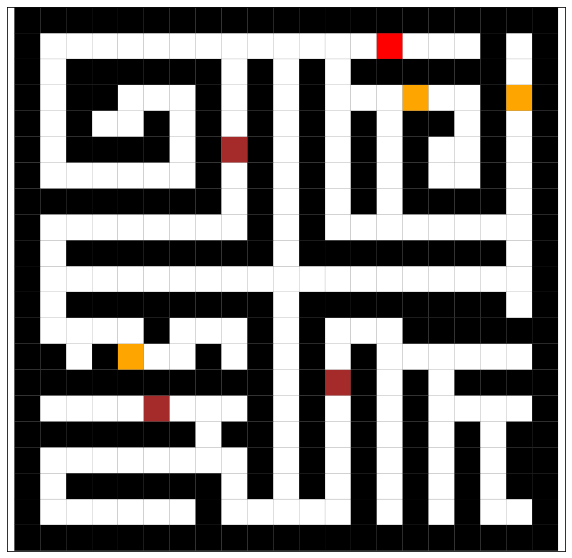

193


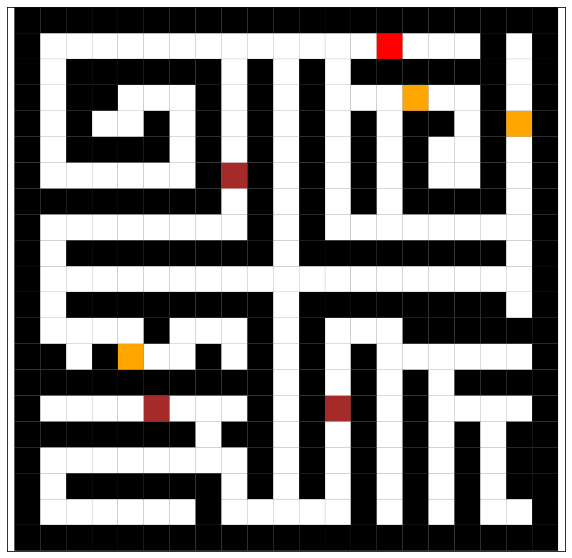

194


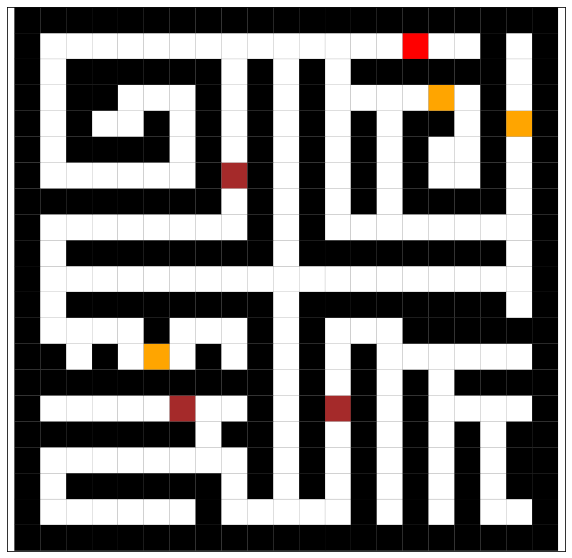

195


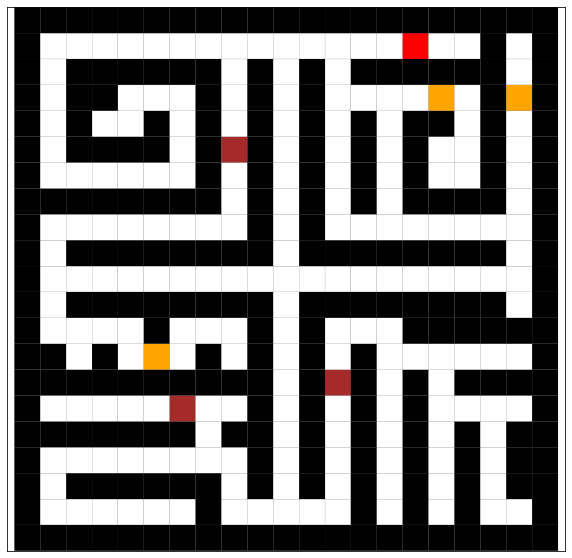

196


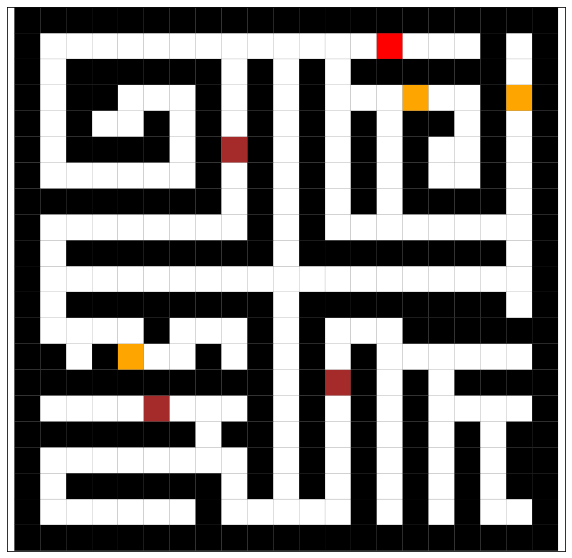

197


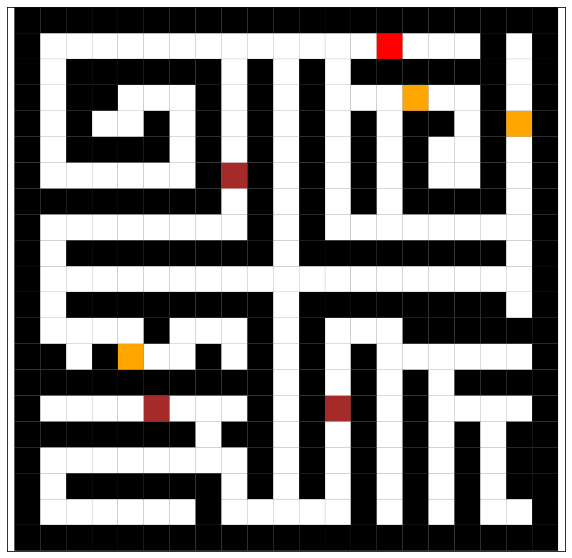

198


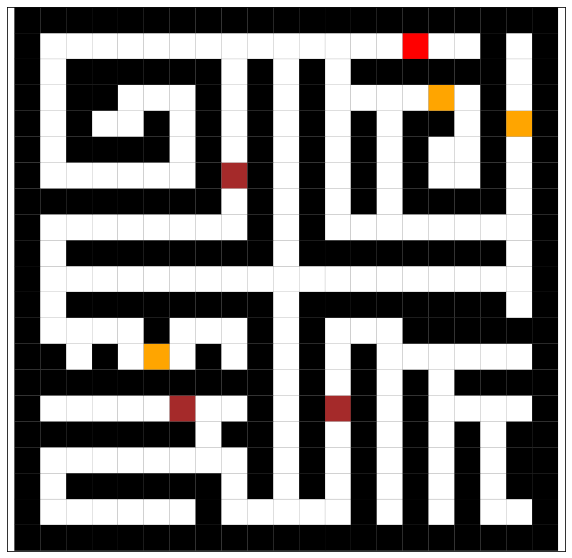

199


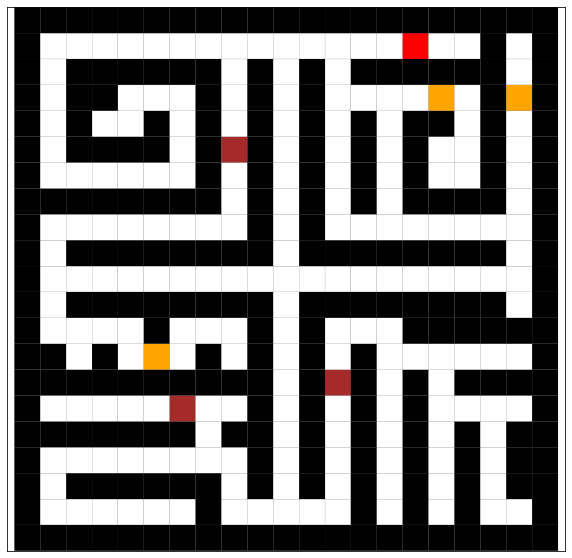

200


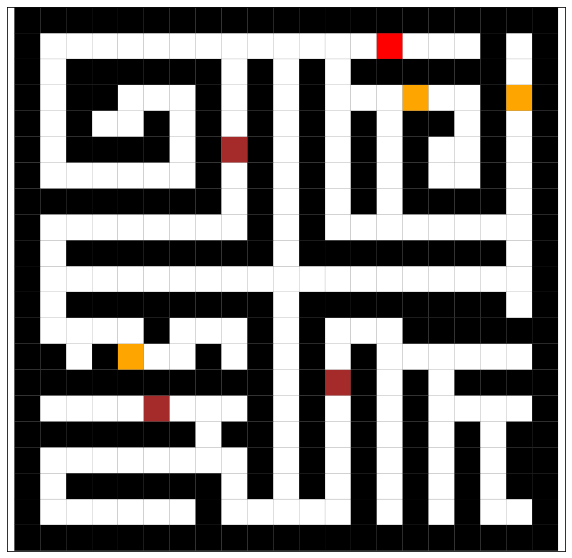

201


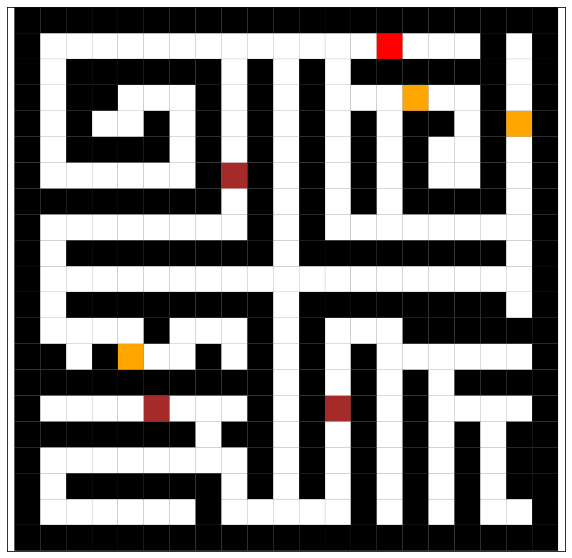

202


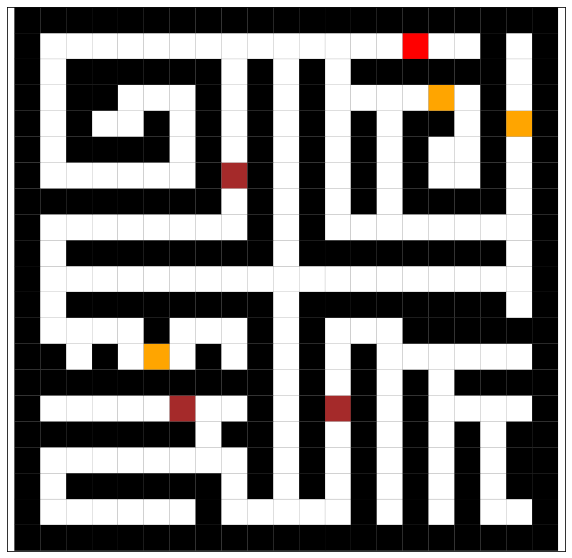

203


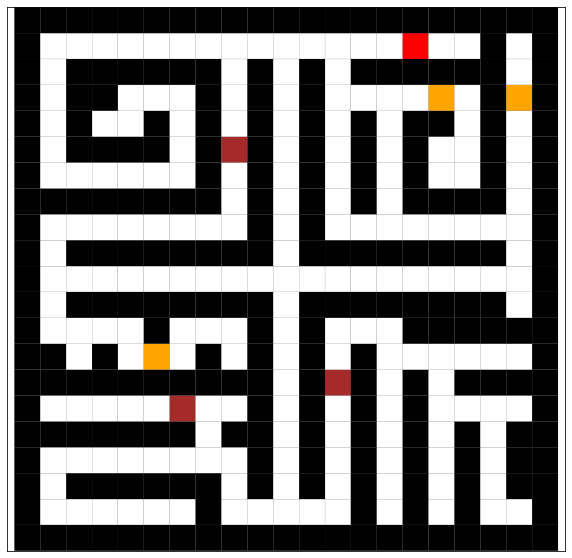

204


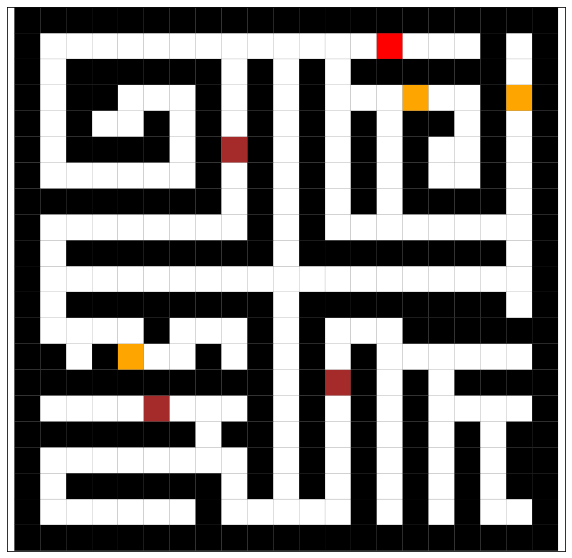

205


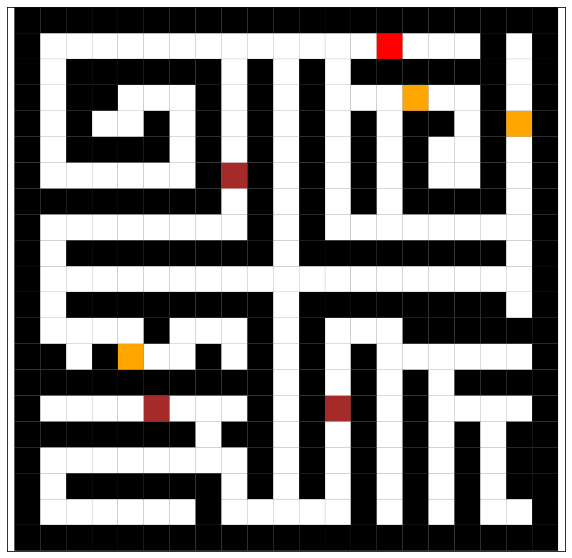

206


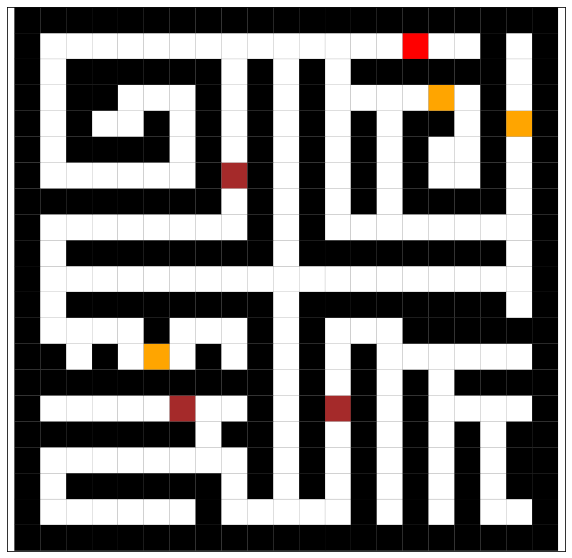

207


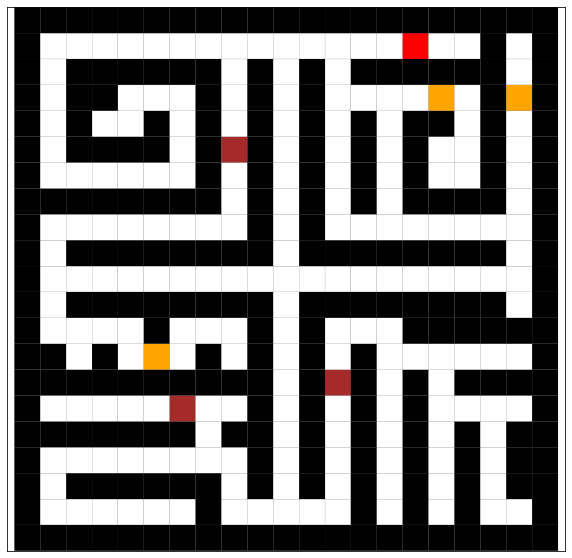

208


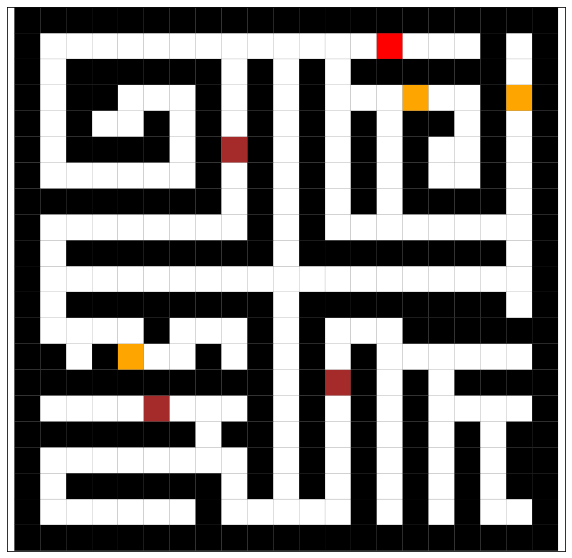

209


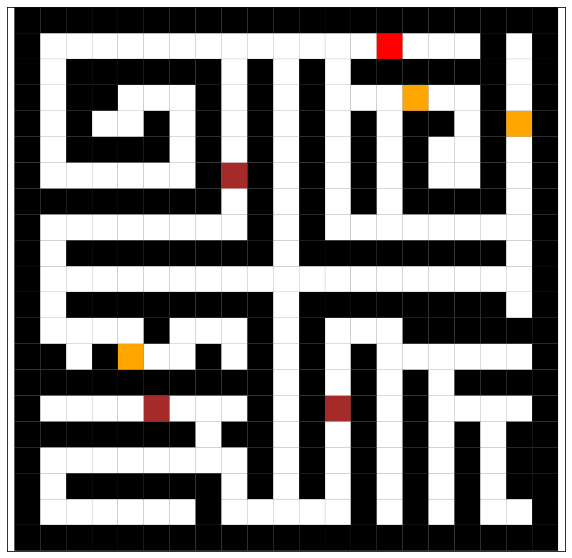

210


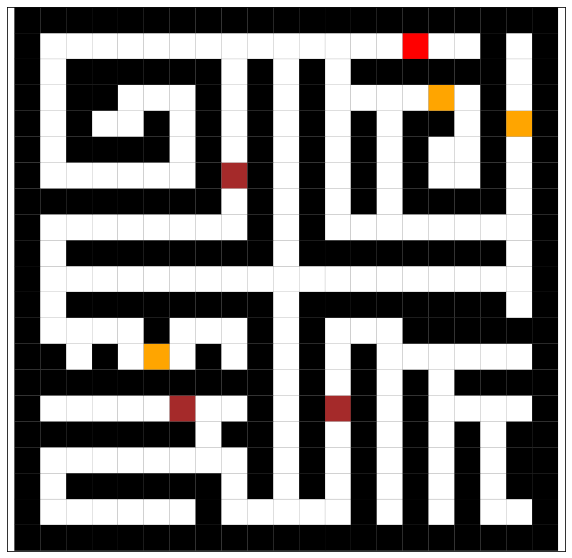

211


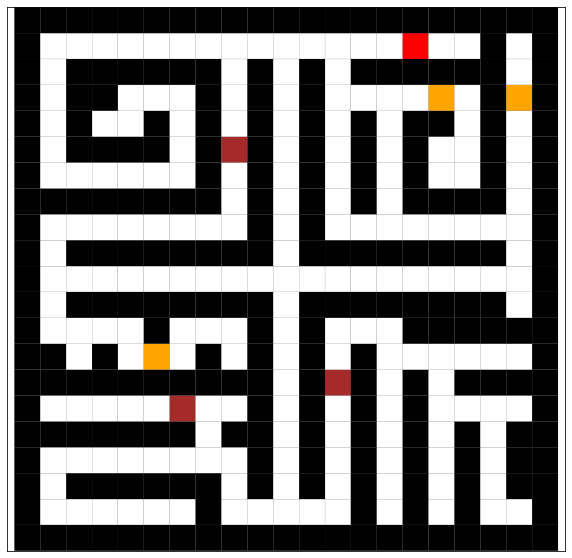

212


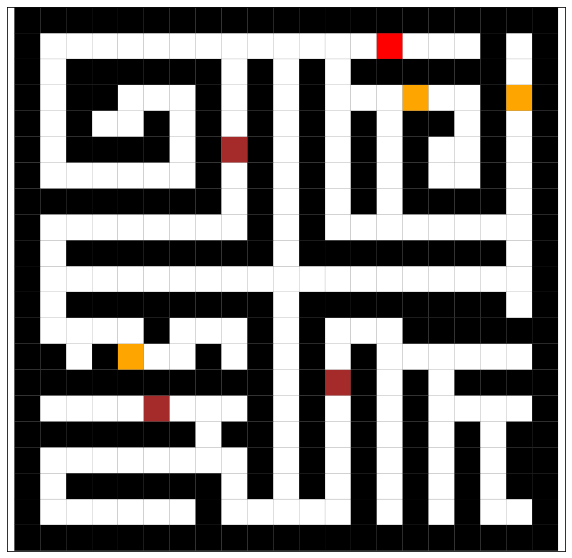

213


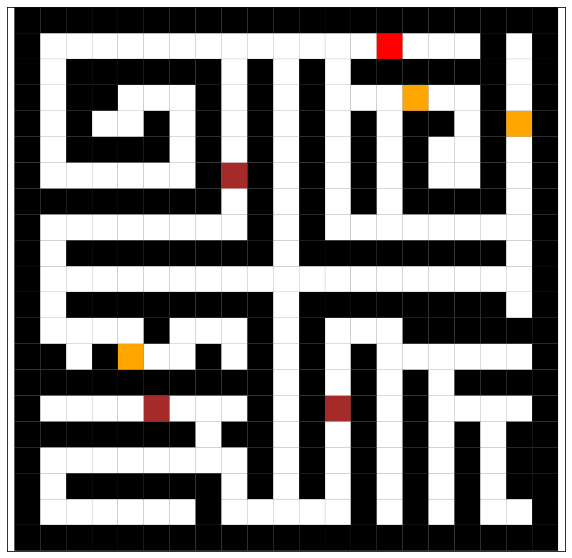

214


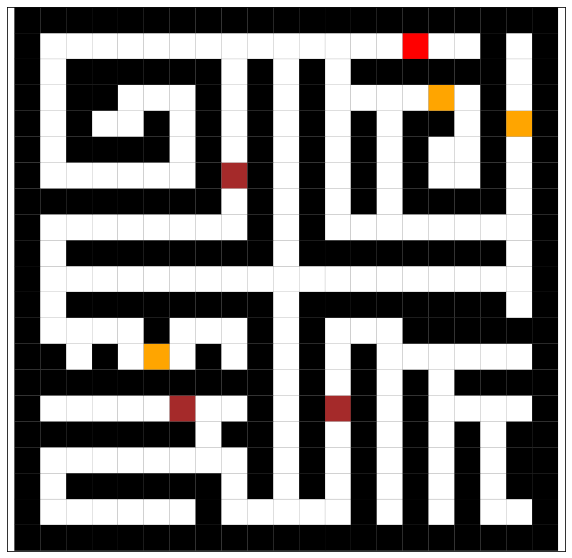

215


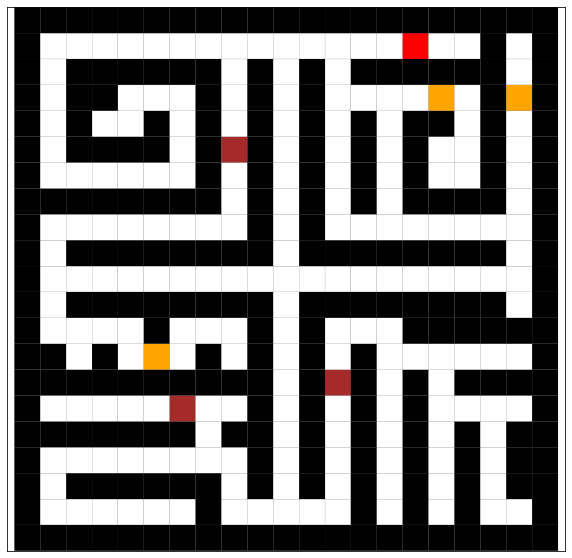

216


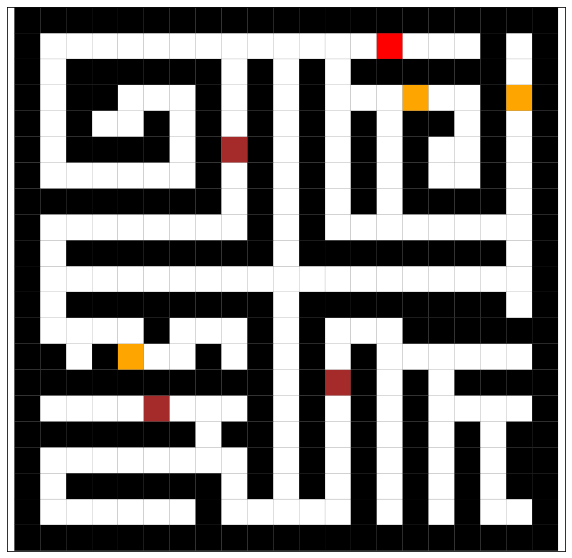

217


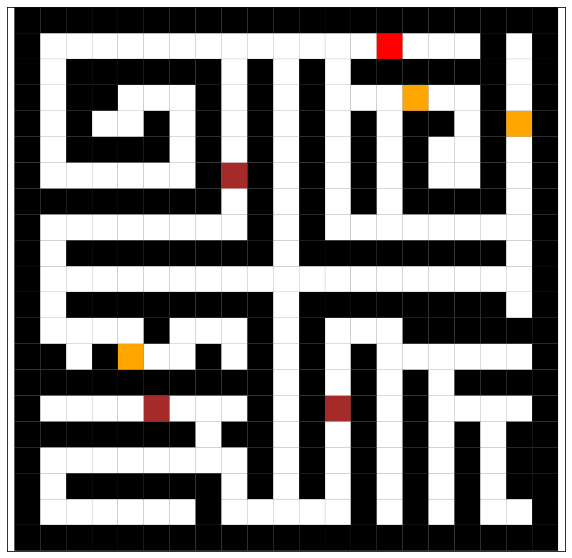

218


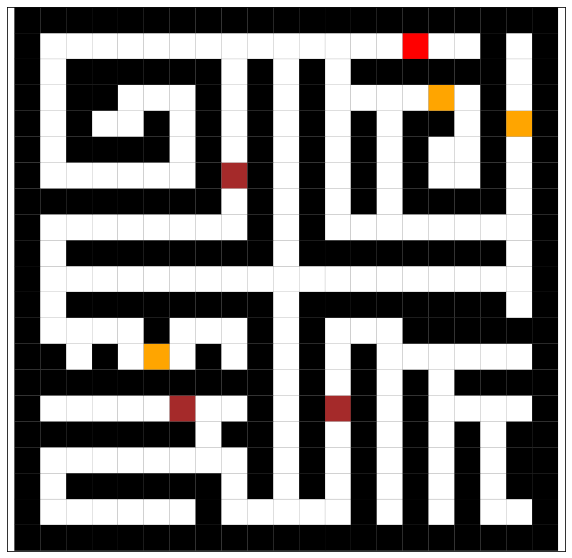

219


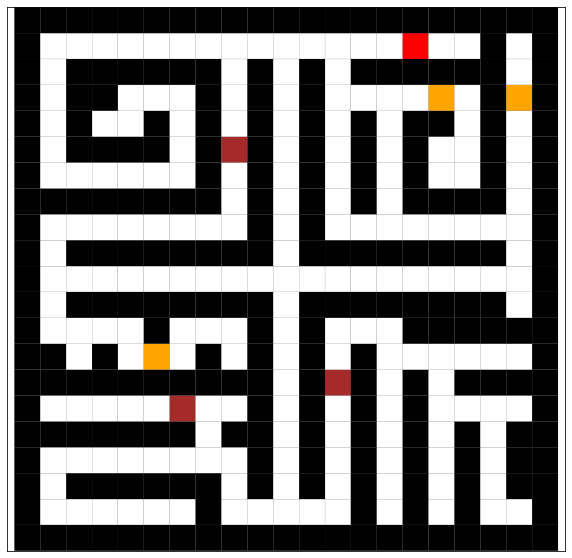

220


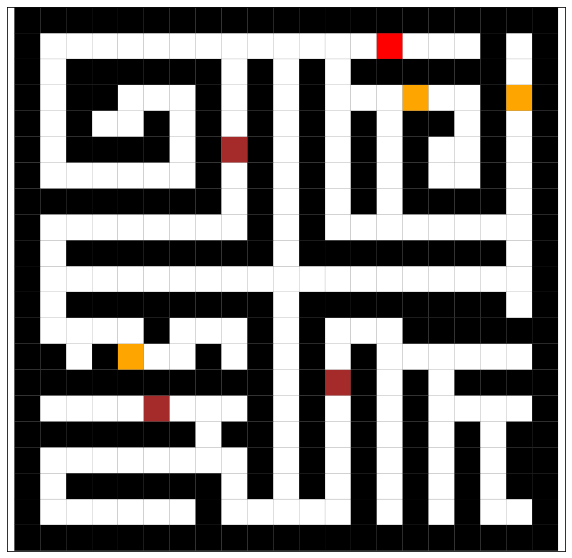

221


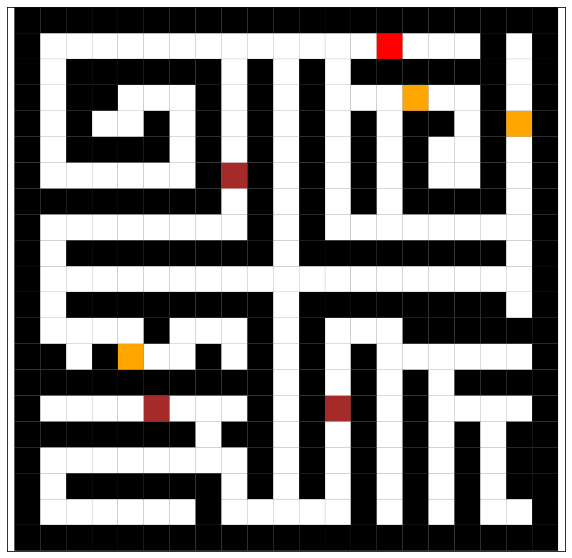

222


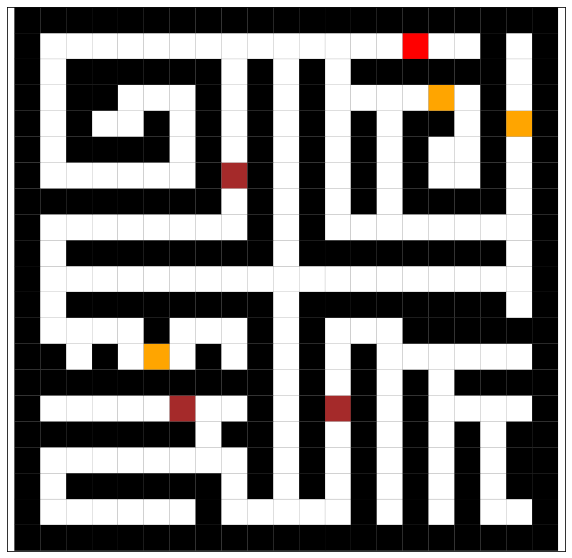

223


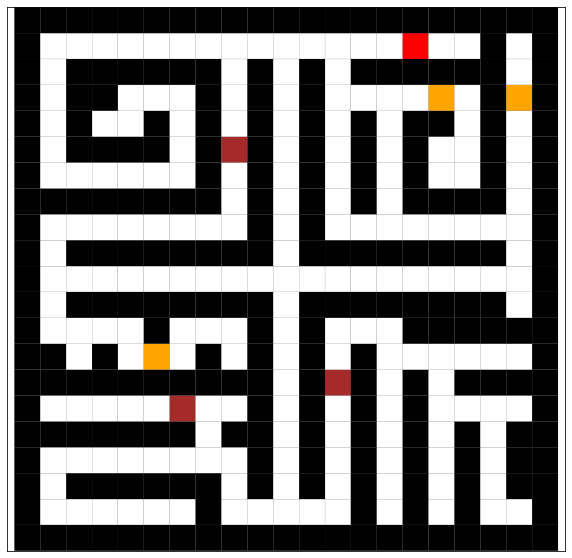

224


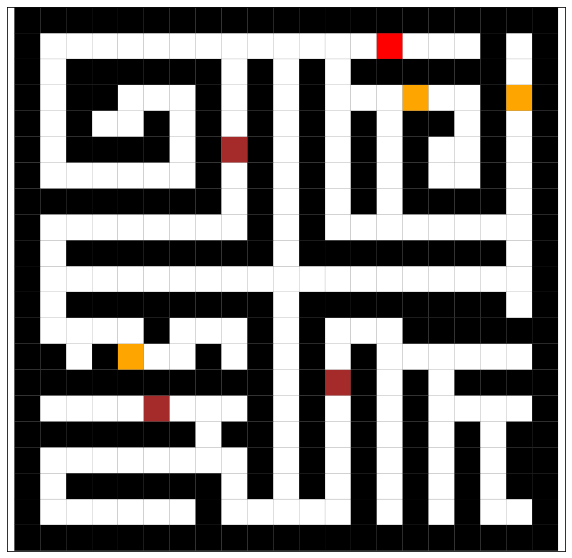

225


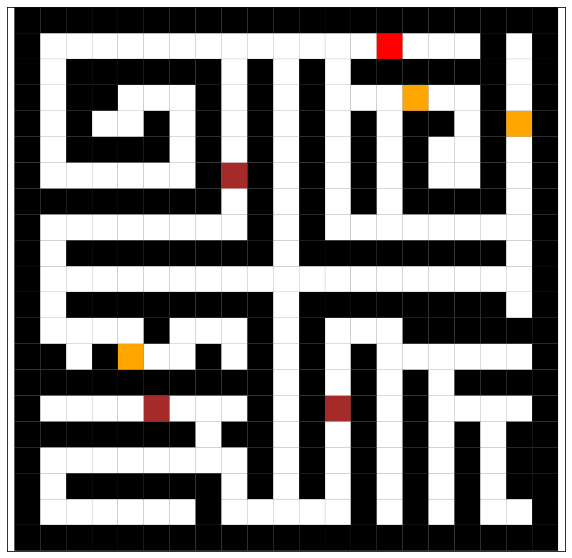

226


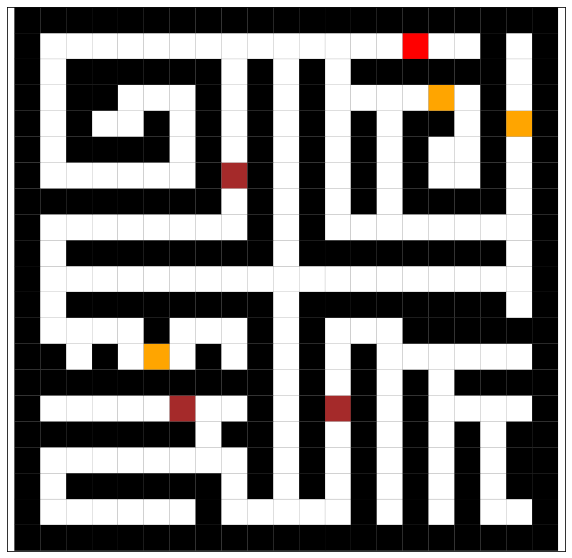

227


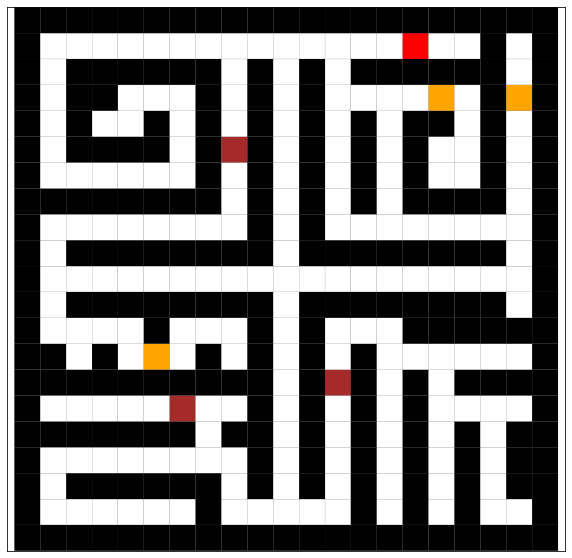

228


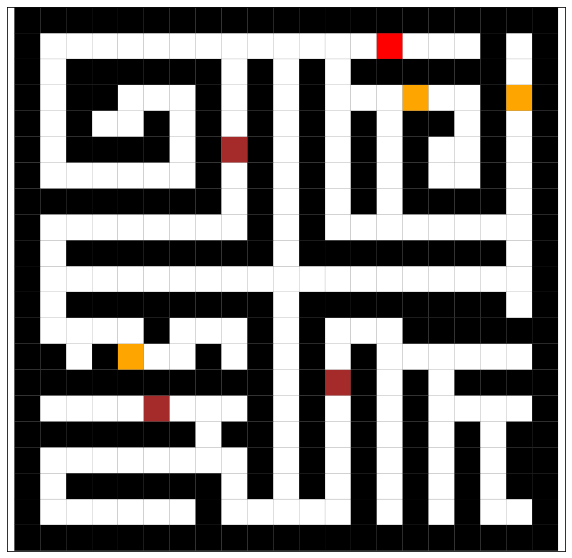

229


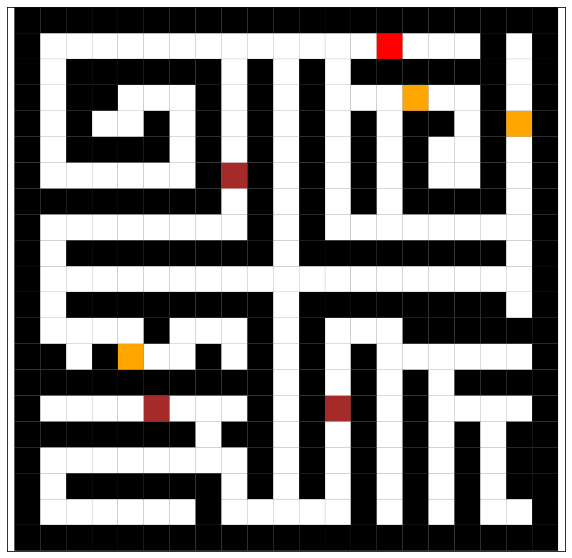

230


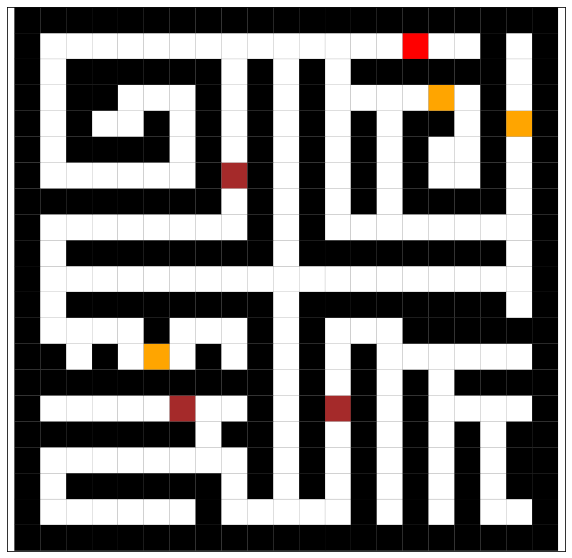

231


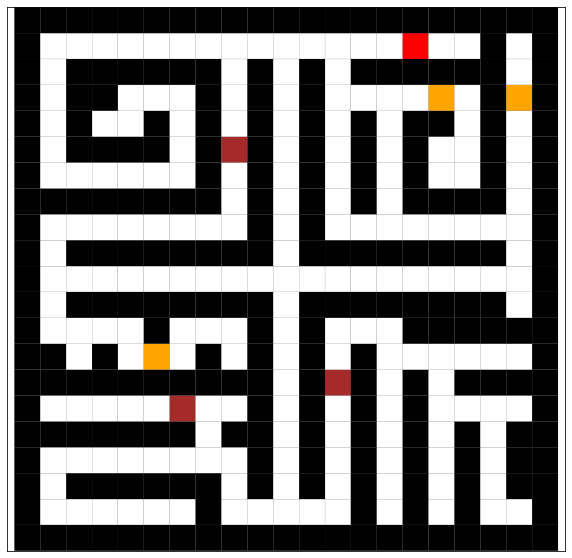

232


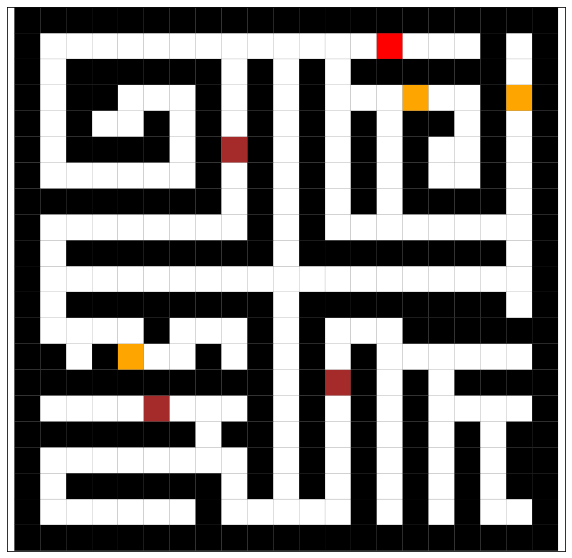

233


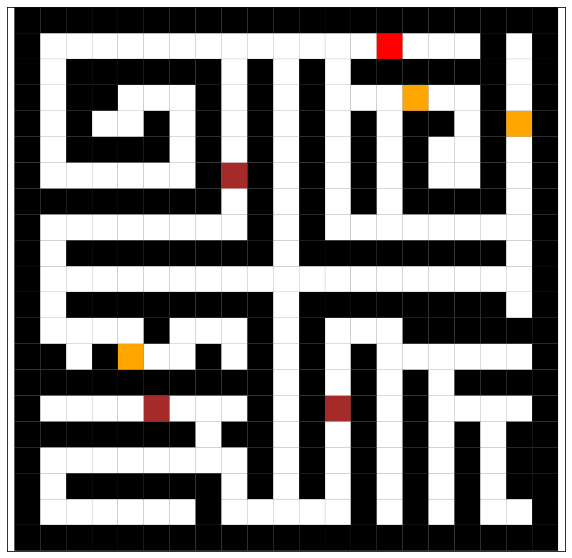

234


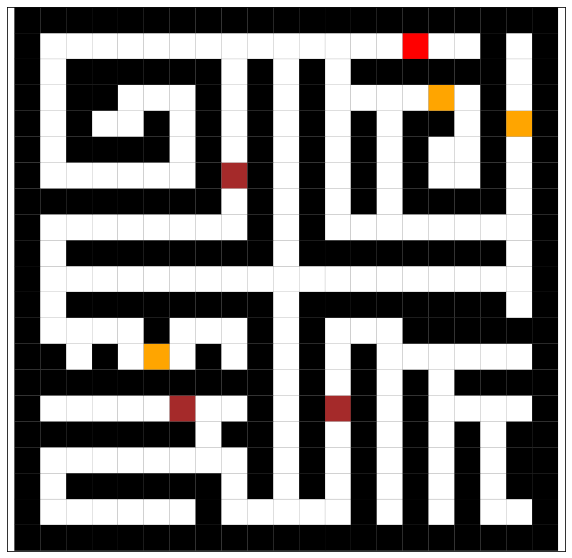

235


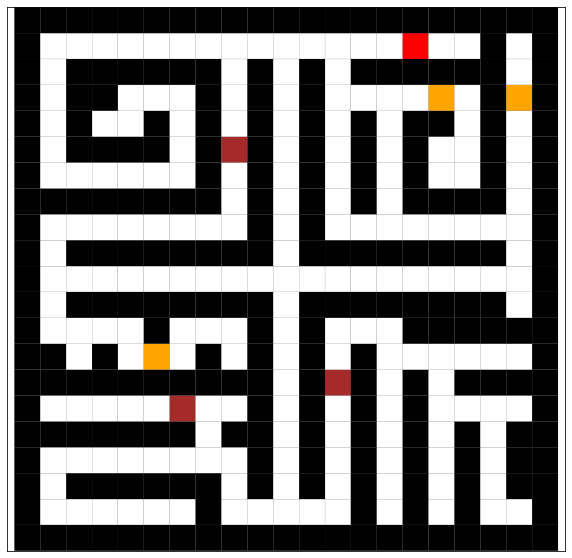

236


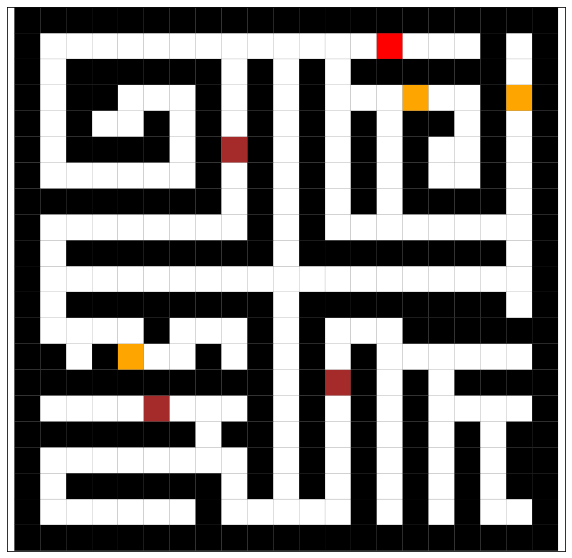

237


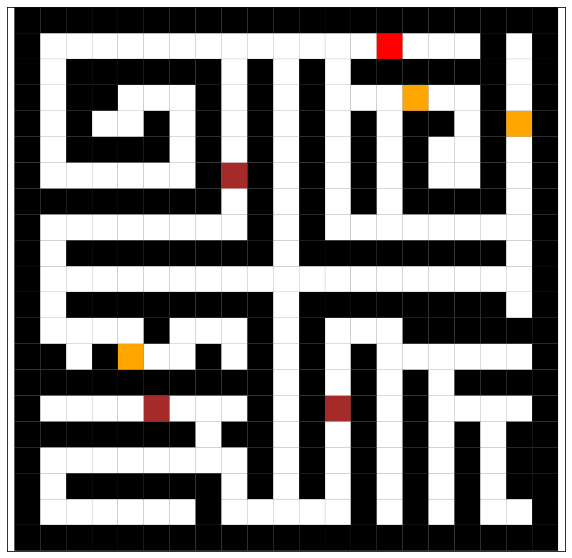

238


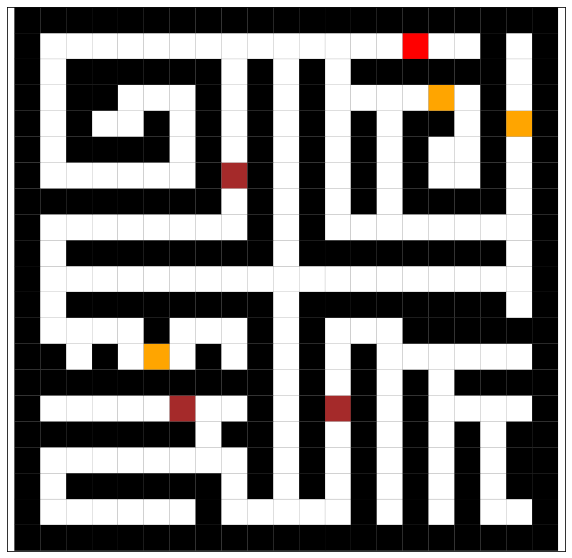

239


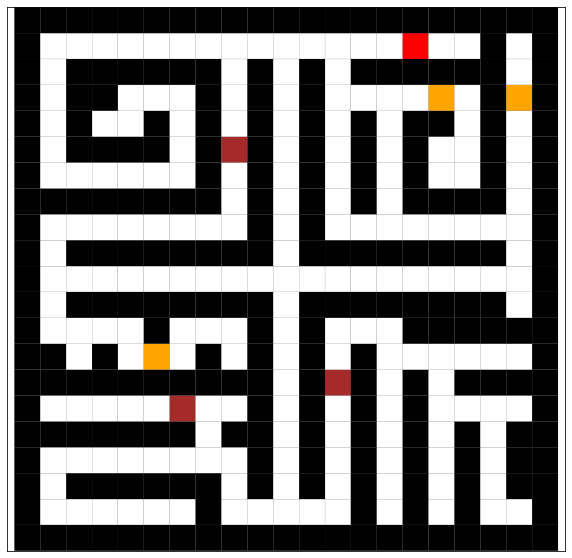

240


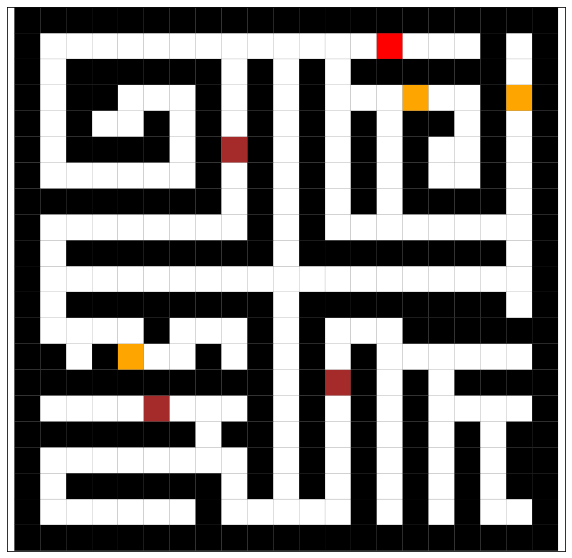

241


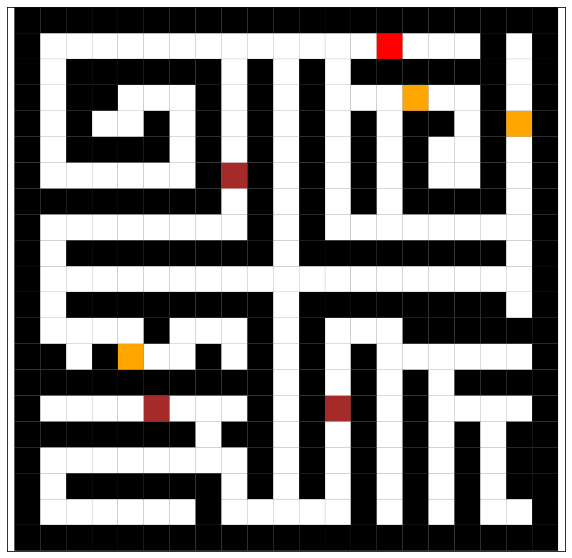

242


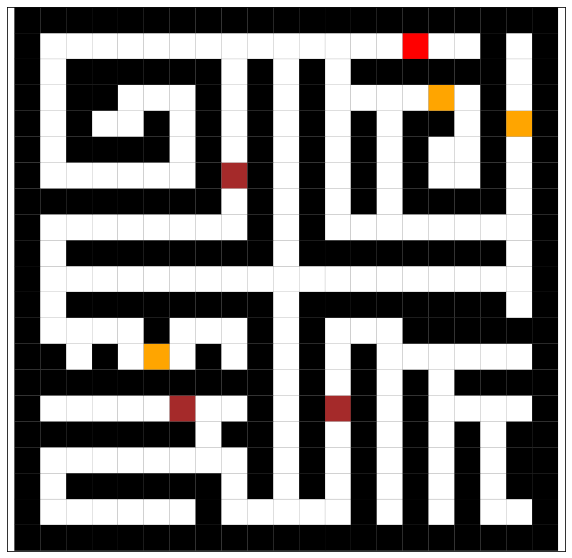

243


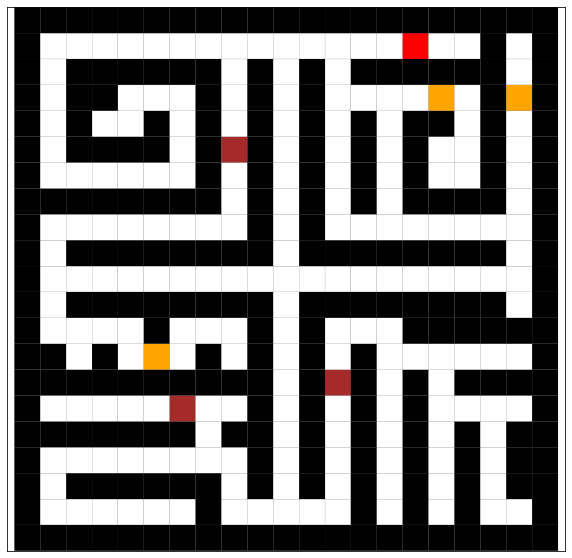

244


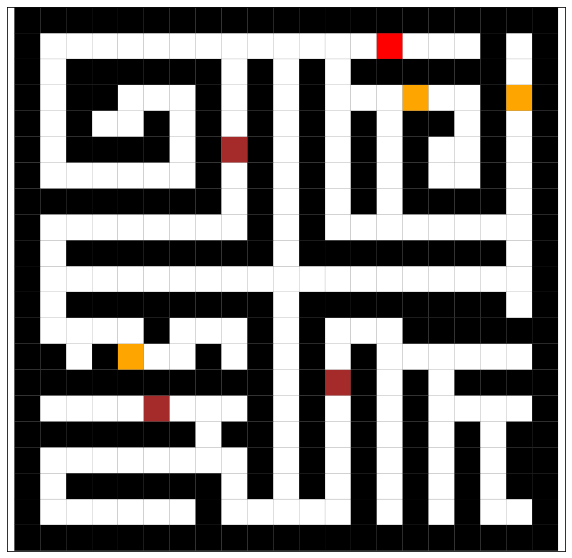

245


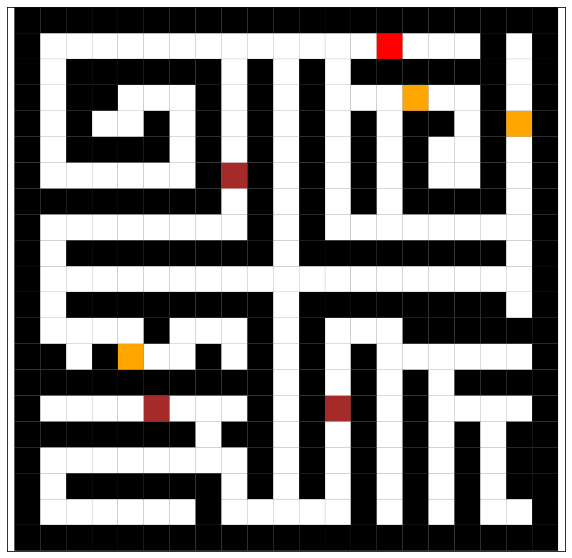

246


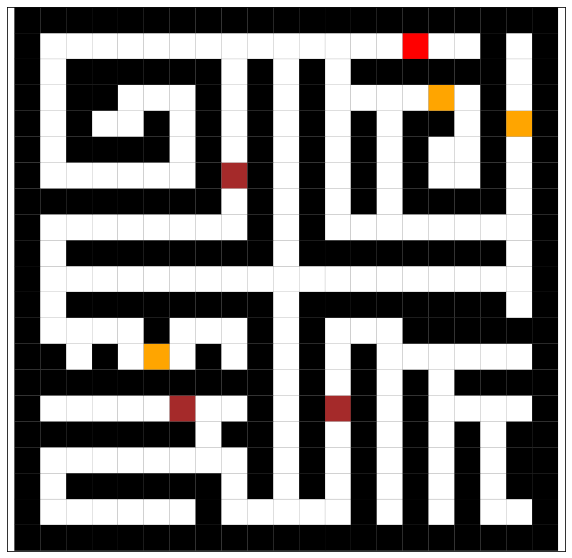

247


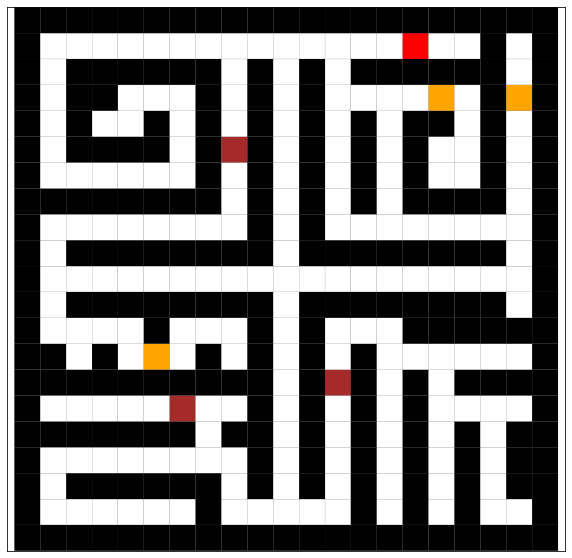

248


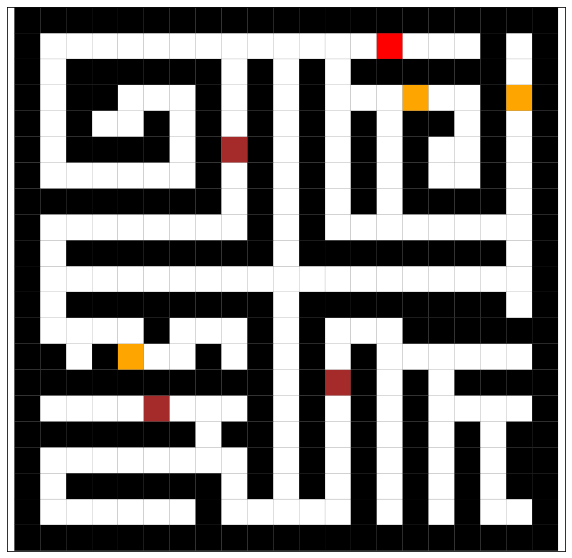

249


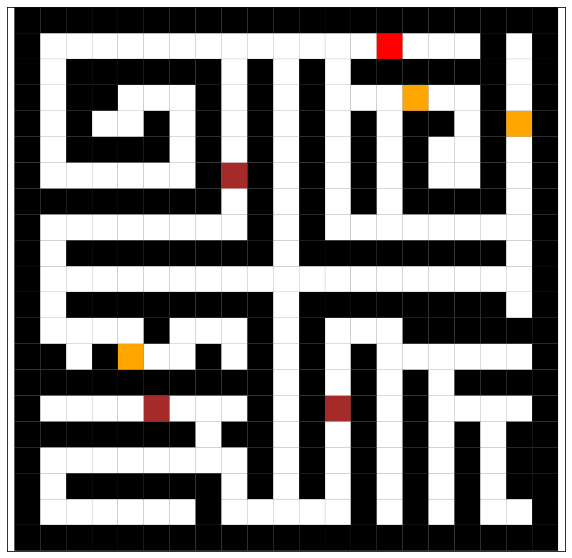

250


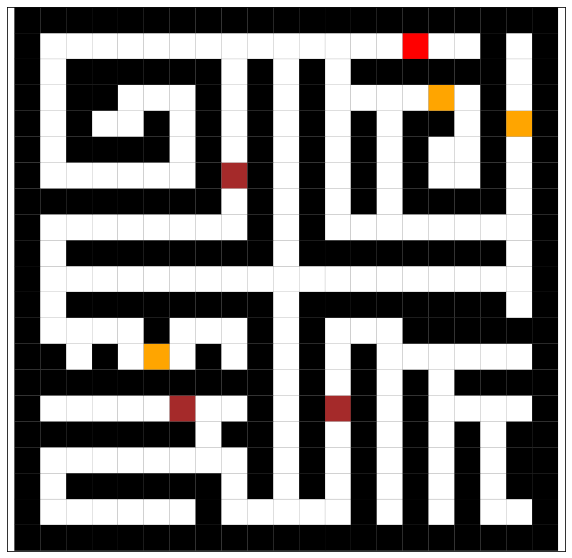

251


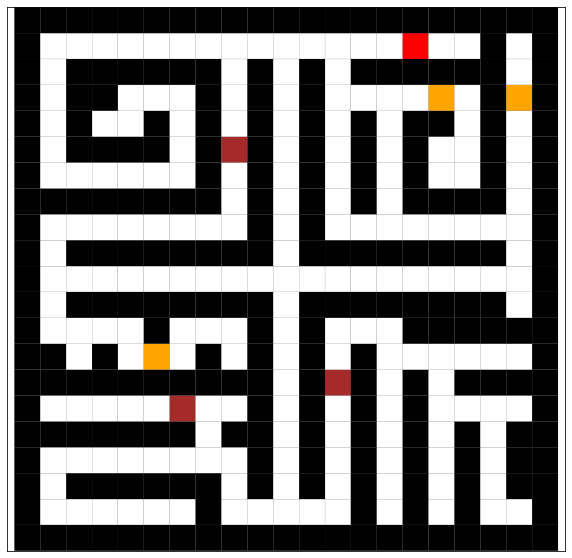

252


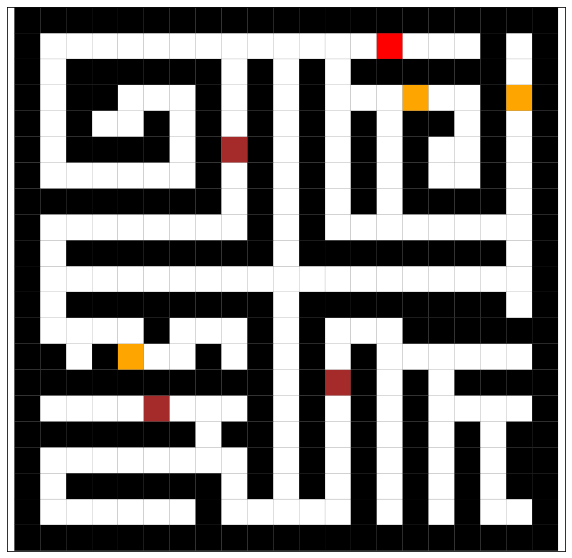

253


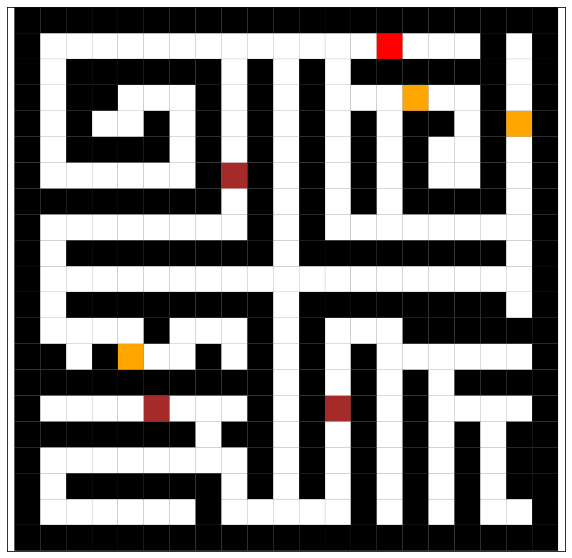

254


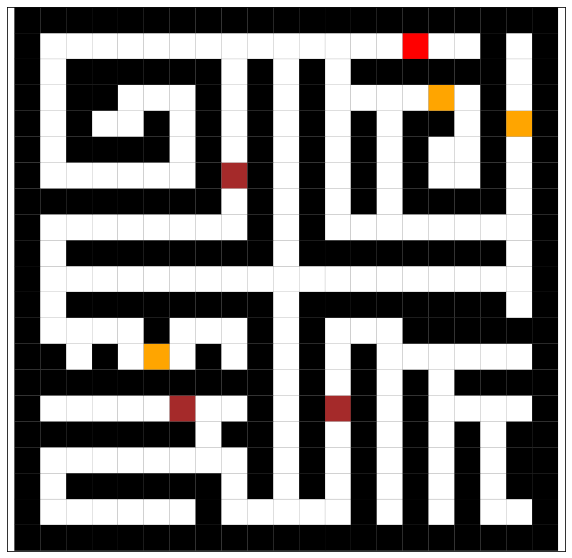

255


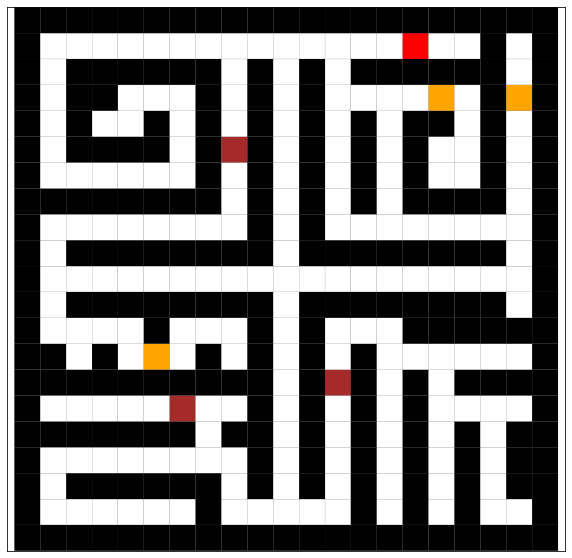

256


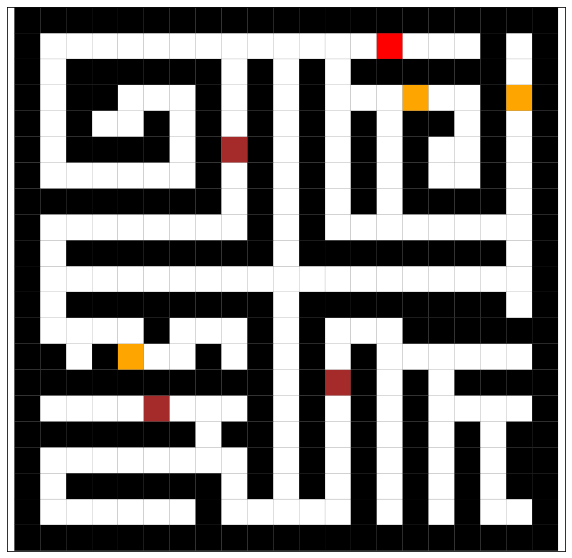

257


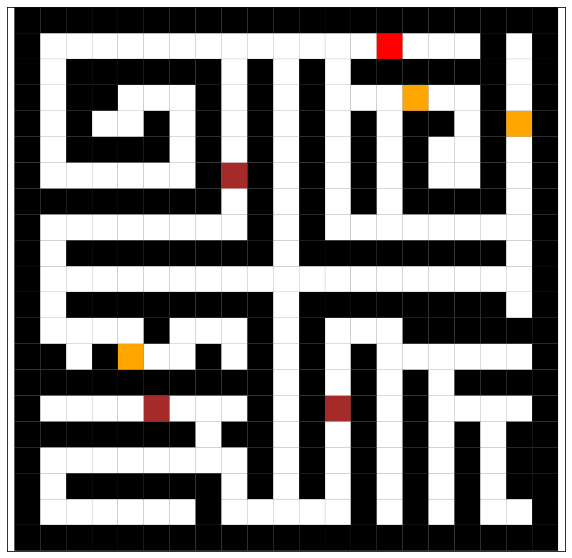

258


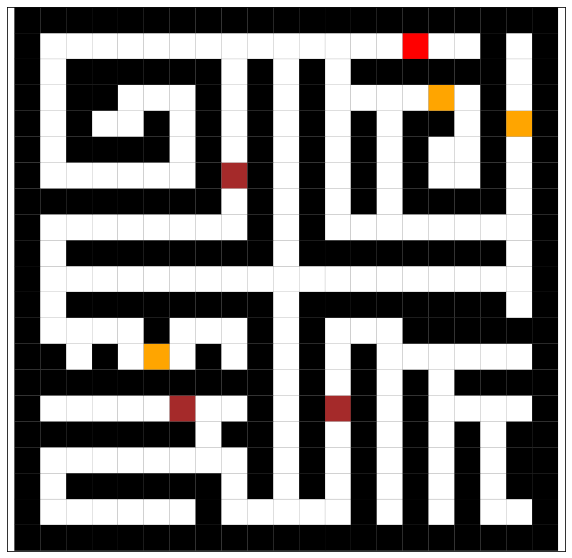

259


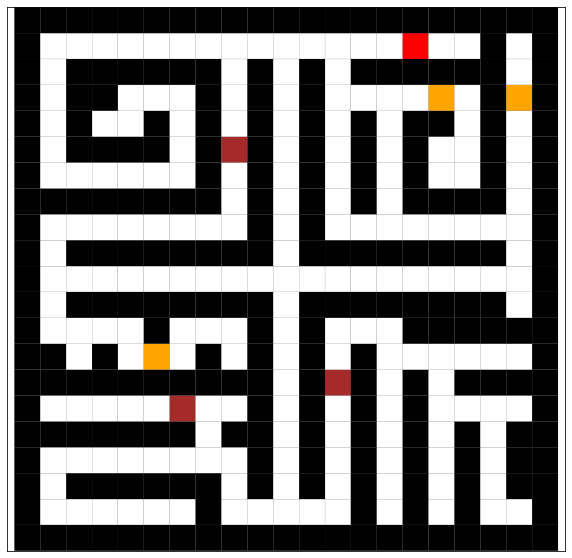

260


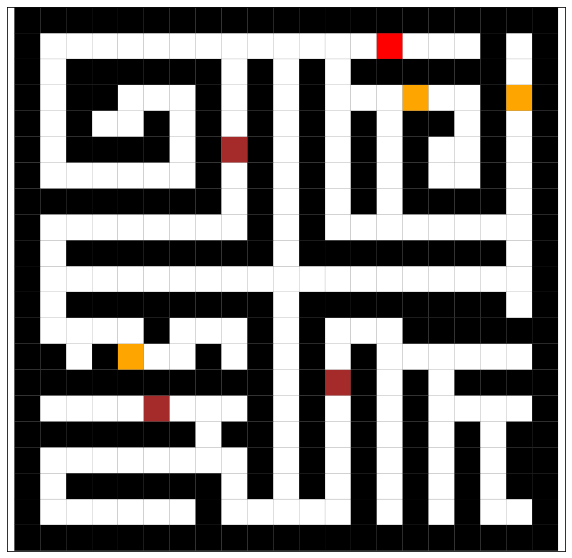

261


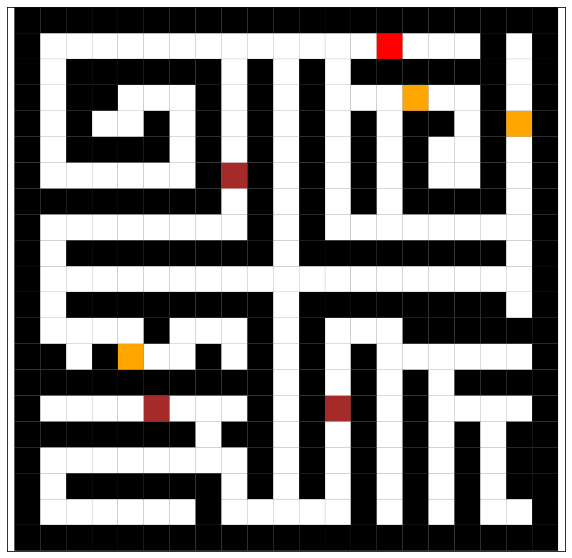

262


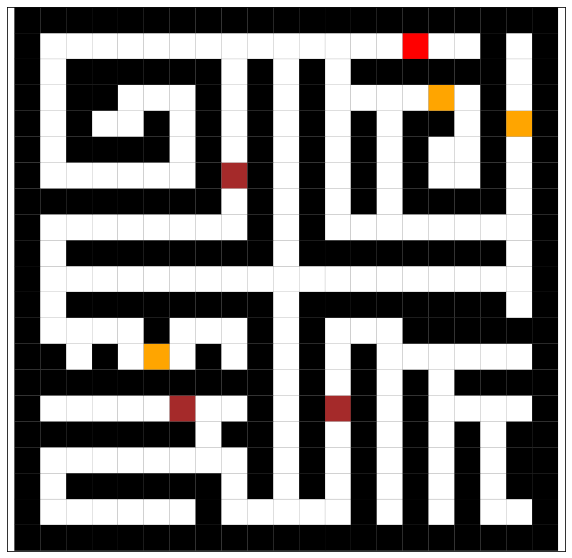

263


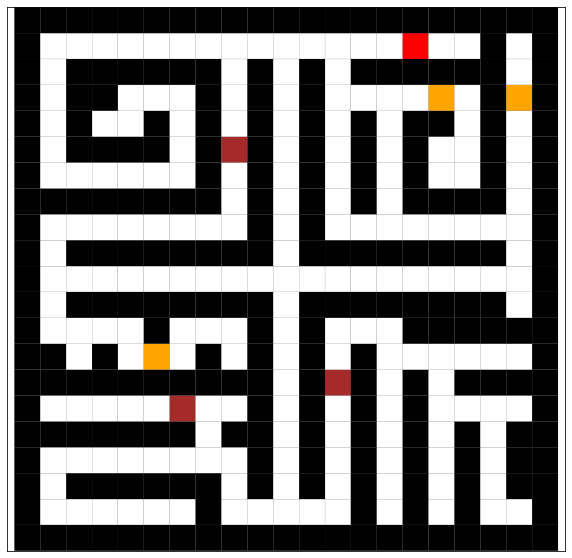

264


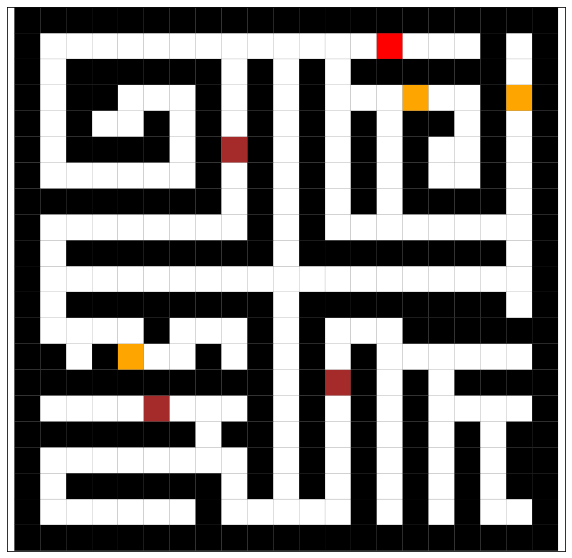

265


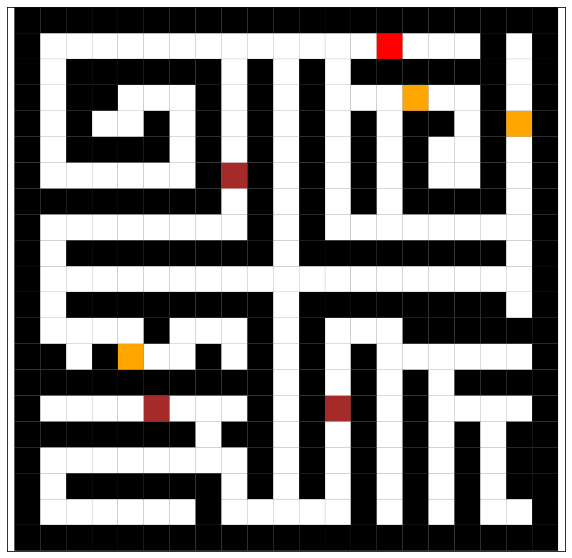

266


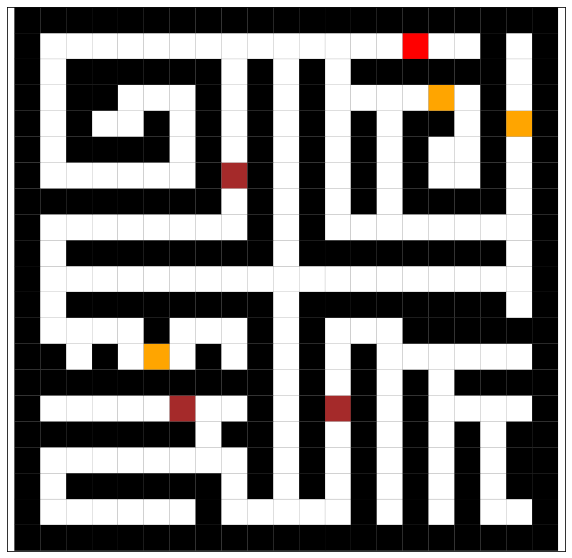

267


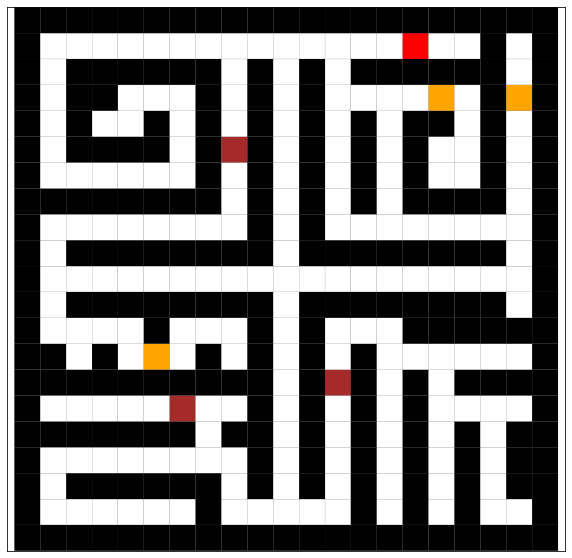

268


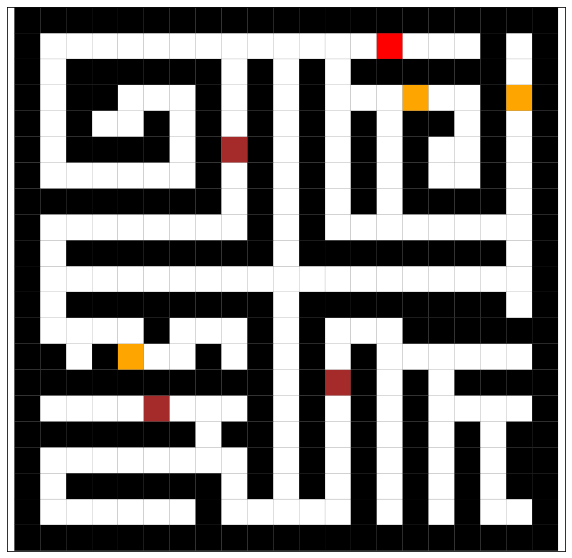

269


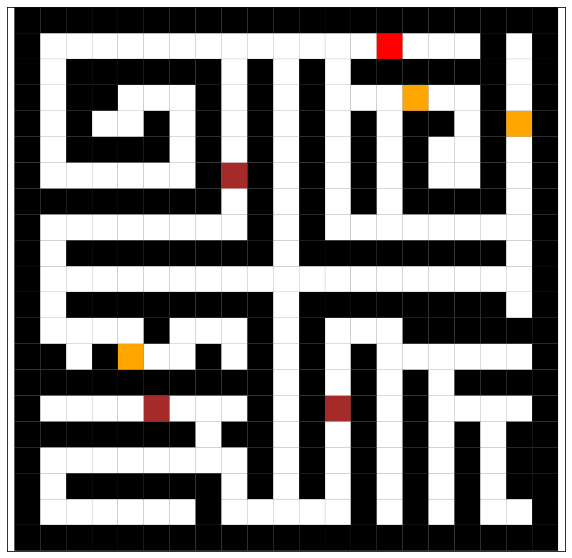

270


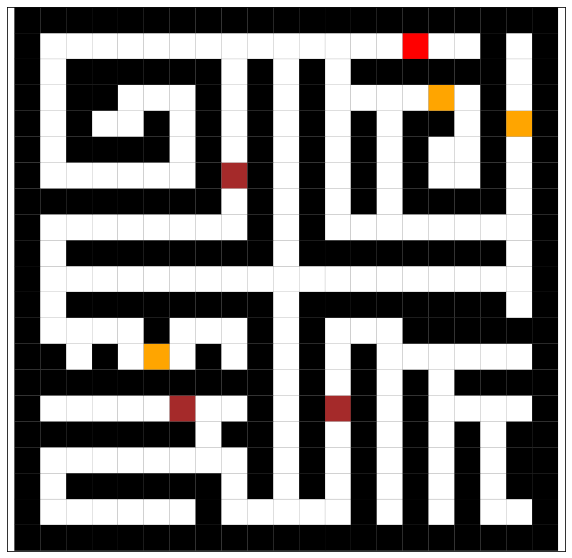

271


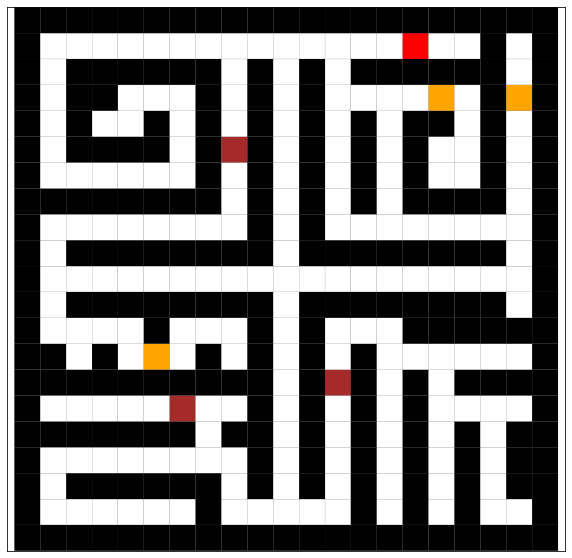

272


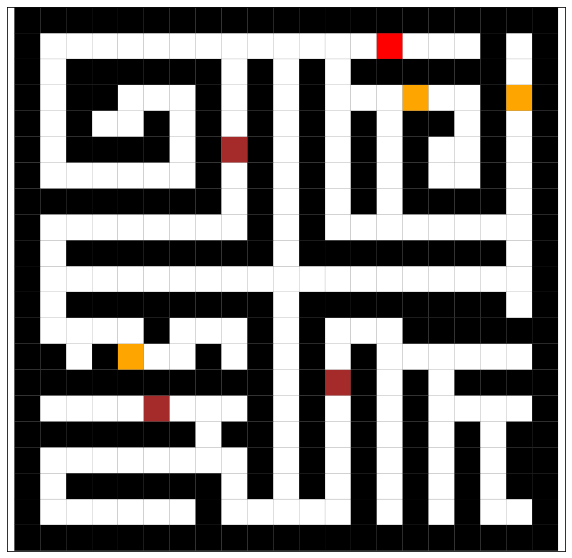

273


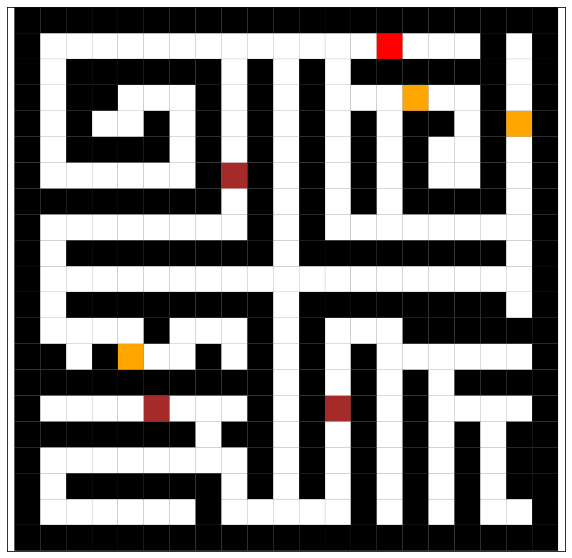

274


In [ ]:
g_greedy=take_input_and_generate_grid("input1.txt")
dim1_greedy=len(g_greedy)
dim2_greedy=len(g[0])
maze3 = generate_maze(dim1_greedy,dim2_greedy)
maze3.grid=g_greedy
steps=greedy_heuristic_converge(maze3)
print(len(steps))